In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD
from vis.utils import utils

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (Xception notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = Xception(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
print("Extracting features from Xception layers ...")
bnfeatures = base_model.predict(X)

Extracting features from Xception layers ...


In [8]:
print(bnfeatures)

[[  2.42947131e-01   5.61247230e-01   9.46019776e-03 ...,   1.69814959e-01
    3.43503983e-04   1.17251664e-01]
 [  2.98286259e-01   3.15055221e-01   5.58525184e-03 ...,   1.88527241e-01
    5.58711309e-03   3.94407623e-02]
 [  3.29330862e-01   3.36922675e-01   1.61813665e-02 ...,   1.68857634e-01
    4.59819421e-04   1.20187551e-01]
 ..., 
 [  2.27840275e-01   4.97228540e-02   5.39110489e-02 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.40965566e-01   1.15863711e-01   2.50896901e-01 ...,   0.00000000e+00
    5.84328547e-02   0.00000000e+00]
 [  1.94706500e-01   3.25994909e-01   3.90112922e-02 ...,   5.28134927e-02
    0.00000000e+00   0.00000000e+00]]


In [9]:
bnfeatures.shape

(10136, 2048)

In [10]:
# Adding a custom top layer to the model
predictions = Dense(num_classes, activation='softmax', name='predictions')(base_model.output)
model = Model(inputs=base_model.input, outputs=predictions)
#model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 111, 111, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 111, 111, 32)  128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 111, 111, 32)  0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [11]:
# Creating the top model for pre-training
bottleneck_features = Input(shape=bnfeatures.shape[1:], name='bottleneck_features')
predictions = Dense(num_classes, activation='softmax', name='predictions')(bottleneck_features)
top_model = Model(inputs=bottleneck_features, outputs=predictions)
top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bottleneck_features (InputLa (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 20)                40980     
Total params: 40,980
Trainable params: 40,980
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [13]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=100
history = []
tophistory = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='virussign-xception-pretrained-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()
init_top_weights = top_model.get_weights()

In [14]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    bnfeatures_train = bnfeatures[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    bnfeatures_test = bnfeatures[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
  
    print("[%d] Pre-training the top model ..." %(i))

    top_model.set_weights(init_top_weights)

    y_prob = top_model.predict(bnfeatures_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
    
    start = time.time()
    h = top_model.fit(bnfeatures_train, Y_train, validation_data=(bnfeatures_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    tophistory.append(h)
    
    pretrained_top_weights = top_model.get_weights()
          
    y_prob = top_model.predict(bnfeatures_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Pre-trained acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
   
    print("[%d] Fine-tuning the model ..." %(i))

    model.set_weights(init_weights)
    model.layers[-1].set_weights(init_top_weights)
    
    #y_prob = model.predict(X_test, verbose=0)  # Testing
    #y_pred = np.argmax(y_prob, axis=1)
    #print("[%d] Initial acurracy (model): %.4f" %(i,accuracy_score(y_test,y_pred)))
    
    model.layers[-1].set_weights(pretrained_top_weights)

    #y_prob = model.predict(X_test, verbose=0)  # Testing
    #y_pred = np.argmax(y_prob, axis=1)
    #print("[%d] Pre-trained acurracy (model): %.4f" %(i,accuracy_score(y_test,y_pred)))    
    
    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
        
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Pre-training the top model ...
[0] Initial acurracy (top_model): 0.0361
Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 0s - loss: 1.3024 - acc: 0.6403 - val_loss: 0.8710 - val_acc: 0.7695
Epoch 2/100
9112/9112 [==============================] - 0s - loss: 0.7584 - acc: 0.7844 - val_loss: 0.7183 - val_acc: 0.7998
Epoch 3/100
9112/9112 [==============================] - 0s - loss: 0.6465 - acc: 0.8121 - val_loss: 0.6536 - val_acc: 0.8193
Epoch 4/100
9112/9112 [==============================] - 0s - loss: 0.5812 - acc: 0.8307 - val_loss: 0.6105 - val_acc: 0.8340
Epoch 5/100
9112/9112 [==============================] - 0s - loss: 0.5364 - acc: 0.8432 - val_loss: 0.5790 - val_acc: 0.8408
Epoch 6/100
9112/9112 [==============================] - 0s - loss: 0.5008 - acc: 0.8558 - val_loss: 0.5531 - val_acc: 0.8525
Epoch 7/100
9112/9112 [==============================] - 0s - loss: 0.4732 - acc: 0.8642 - val_loss: 0.5372 - val_acc: 0

9112/9112 [==============================] - 136s - loss: 0.0285 - acc: 0.9929 - val_loss: 0.5825 - val_acc: 0.8789
Epoch 28/100
9112/9112 [==============================] - 136s - loss: 0.0272 - acc: 0.9929 - val_loss: 0.5809 - val_acc: 0.8818
Epoch 29/100
9112/9112 [==============================] - 136s - loss: 0.0260 - acc: 0.9937 - val_loss: 0.5786 - val_acc: 0.8877
Epoch 30/100
9112/9112 [==============================] - 136s - loss: 0.0222 - acc: 0.9948 - val_loss: 0.5785 - val_acc: 0.8818
Epoch 31/100
9112/9112 [==============================] - 135s - loss: 0.0189 - acc: 0.9956 - val_loss: 0.5939 - val_acc: 0.8838
Epoch 32/100
9112/9112 [==============================] - 135s - loss: 0.0197 - acc: 0.9954 - val_loss: 0.5897 - val_acc: 0.8799
Epoch 33/100
9112/9112 [==============================] - 135s - loss: 0.0201 - acc: 0.9958 - val_loss: 0.5931 - val_acc: 0.8818
Epoch 34/100
9112/9112 [==============================] - 135s - loss: 0.0174 - acc: 0.9960 - val_loss: 0.5977

9114/9114 [==============================] - 0s - loss: 0.1525 - acc: 0.9603 - val_loss: 0.4557 - val_acc: 0.8757
Epoch 54/100
9114/9114 [==============================] - 0s - loss: 0.1506 - acc: 0.9604 - val_loss: 0.4503 - val_acc: 0.8689
Epoch 55/100
9114/9114 [==============================] - 0s - loss: 0.1485 - acc: 0.9618 - val_loss: 0.4558 - val_acc: 0.8757
Epoch 56/100
9114/9114 [==============================] - 0s - loss: 0.1466 - acc: 0.9605 - val_loss: 0.4588 - val_acc: 0.8699
Epoch 57/100
9114/9114 [==============================] - 0s - loss: 0.1446 - acc: 0.9627 - val_loss: 0.4645 - val_acc: 0.8708
Epoch 58/100
9114/9114 [==============================] - 0s - loss: 0.1426 - acc: 0.9635 - val_loss: 0.4594 - val_acc: 0.8728
Epoch 59/100
9114/9114 [==============================] - 0s - loss: 0.1420 - acc: 0.9623 - val_loss: 0.4570 - val_acc: 0.8748
Epoch 60/100
9114/9114 [==============================] - 0s - loss: 0.1383 - acc: 0.9645 - val_loss: 0.4611 - val_acc: 0.87

9114/9114 [==============================] - 131s - loss: 0.0043 - acc: 0.9995 - val_loss: 0.5962 - val_acc: 0.8992
Epoch 80/100
9114/9114 [==============================] - 131s - loss: 0.0053 - acc: 0.9985 - val_loss: 0.5974 - val_acc: 0.8992
Epoch 81/100
9114/9114 [==============================] - 131s - loss: 0.0042 - acc: 0.9991 - val_loss: 0.5965 - val_acc: 0.8982
Epoch 82/100
9114/9114 [==============================] - 131s - loss: 0.0041 - acc: 0.9993 - val_loss: 0.6043 - val_acc: 0.8992
Epoch 83/100
9114/9114 [==============================] - 131s - loss: 0.0051 - acc: 0.9988 - val_loss: 0.5949 - val_acc: 0.8992
Epoch 84/100
9114/9114 [==============================] - 132s - loss: 0.0038 - acc: 0.9993 - val_loss: 0.5985 - val_acc: 0.8992
Epoch 85/100
9114/9114 [==============================] - 132s - loss: 0.0039 - acc: 0.9991 - val_loss: 0.6038 - val_acc: 0.8992
Epoch 86/100
9114/9114 [==============================] - 132s - loss: 0.0053 - acc: 0.9988 - val_loss: 0.6062

9116/9116 [==============================] - 0s - loss: 0.1747 - acc: 0.9543 - val_loss: 0.4679 - val_acc: 0.8735
Epoch 43/100
9116/9116 [==============================] - 0s - loss: 0.1731 - acc: 0.9547 - val_loss: 0.4657 - val_acc: 0.8627
Epoch 44/100
9116/9116 [==============================] - 0s - loss: 0.1692 - acc: 0.9546 - val_loss: 0.4732 - val_acc: 0.8696
Epoch 45/100
9116/9116 [==============================] - 0s - loss: 0.1674 - acc: 0.9560 - val_loss: 0.4752 - val_acc: 0.8637
Epoch 46/100
9116/9116 [==============================] - 0s - loss: 0.1657 - acc: 0.9562 - val_loss: 0.4723 - val_acc: 0.8686
Epoch 47/100
9116/9116 [==============================] - 0s - loss: 0.1629 - acc: 0.9565 - val_loss: 0.4679 - val_acc: 0.8725
Epoch 48/100
9116/9116 [==============================] - 0s - loss: 0.1589 - acc: 0.9591 - val_loss: 0.4757 - val_acc: 0.8706
Epoch 49/100
9116/9116 [==============================] - 0s - loss: 0.1567 - acc: 0.9593 - val_loss: 0.4740 - val_acc: 0.86

9116/9116 [==============================] - 133s - loss: 0.0070 - acc: 0.9988 - val_loss: 0.6645 - val_acc: 0.8902
Epoch 69/100
9116/9116 [==============================] - 133s - loss: 0.0063 - acc: 0.9982 - val_loss: 0.6605 - val_acc: 0.8961
Epoch 70/100
9116/9116 [==============================] - 133s - loss: 0.0086 - acc: 0.9982 - val_loss: 0.6643 - val_acc: 0.8902
Epoch 71/100
9116/9116 [==============================] - 133s - loss: 0.0080 - acc: 0.9984 - val_loss: 0.6485 - val_acc: 0.8922
Epoch 72/100
9116/9116 [==============================] - 133s - loss: 0.0074 - acc: 0.9982 - val_loss: 0.6593 - val_acc: 0.8931
Epoch 73/100
9116/9116 [==============================] - 132s - loss: 0.0058 - acc: 0.9988 - val_loss: 0.6590 - val_acc: 0.8931
Epoch 74/100
9116/9116 [==============================] - 133s - loss: 0.0077 - acc: 0.9977 - val_loss: 0.6719 - val_acc: 0.8902
Epoch 75/100
9116/9116 [==============================] - 132s - loss: 0.0076 - acc: 0.9980 - val_loss: 0.6585

9120/9120 [==============================] - 0s - loss: 0.0935 - acc: 0.9800 - val_loss: 0.5563 - val_acc: 0.8671
Epoch 95/100
9120/9120 [==============================] - 0s - loss: 0.0923 - acc: 0.9796 - val_loss: 0.5605 - val_acc: 0.8652
Epoch 96/100
9120/9120 [==============================] - 0s - loss: 0.0930 - acc: 0.9776 - val_loss: 0.5590 - val_acc: 0.8652
Epoch 97/100
9120/9120 [==============================] - 0s - loss: 0.0914 - acc: 0.9794 - val_loss: 0.5623 - val_acc: 0.8602
Epoch 98/100
9120/9120 [==============================] - 0s - loss: 0.0898 - acc: 0.9788 - val_loss: 0.5642 - val_acc: 0.8681
Epoch 99/100
9120/9120 [==============================] - 0s - loss: 0.0901 - acc: 0.9803 - val_loss: 0.5758 - val_acc: 0.8622
Epoch 100/100
9120/9120 [==============================] - 0s - loss: 0.0890 - acc: 0.9812 - val_loss: 0.5592 - val_acc: 0.8681
[3] Pre-trained acurracy (top_model): 0.8681
[3] Fine-tuning the model ...
Train on 9120 samples, validate on 1016 samples


9120/9120 [==============================] - 0s - loss: 0.2800 - acc: 0.9193 - val_loss: 0.4418 - val_acc: 0.8711
Epoch 19/100
9120/9120 [==============================] - 0s - loss: 0.2736 - acc: 0.9207 - val_loss: 0.4396 - val_acc: 0.8711
Epoch 20/100
9120/9120 [==============================] - 0s - loss: 0.2655 - acc: 0.9260 - val_loss: 0.4438 - val_acc: 0.8612
Epoch 21/100
9120/9120 [==============================] - 0s - loss: 0.2606 - acc: 0.9268 - val_loss: 0.4373 - val_acc: 0.8740
Epoch 22/100
9120/9120 [==============================] - 0s - loss: 0.2556 - acc: 0.9273 - val_loss: 0.4426 - val_acc: 0.8602
Epoch 23/100
9120/9120 [==============================] - 0s - loss: 0.2499 - acc: 0.9297 - val_loss: 0.4330 - val_acc: 0.8730
Epoch 24/100
9120/9120 [==============================] - 0s - loss: 0.2459 - acc: 0.9319 - val_loss: 0.4375 - val_acc: 0.8701
Epoch 25/100
9120/9120 [==============================] - 0s - loss: 0.2412 - acc: 0.9316 - val_loss: 0.4281 - val_acc: 0.87

9120/9120 [==============================] - 132s - loss: 0.0085 - acc: 0.9988 - val_loss: 0.6407 - val_acc: 0.8917
Epoch 46/100
9120/9120 [==============================] - 131s - loss: 0.0103 - acc: 0.9979 - val_loss: 0.6472 - val_acc: 0.8898
Epoch 47/100
9120/9120 [==============================] - 131s - loss: 0.0115 - acc: 0.9970 - val_loss: 0.6388 - val_acc: 0.8917
Epoch 48/100
9120/9120 [==============================] - 131s - loss: 0.0114 - acc: 0.9970 - val_loss: 0.6374 - val_acc: 0.8927
Epoch 49/100
9120/9120 [==============================] - 131s - loss: 0.0097 - acc: 0.9979 - val_loss: 0.6382 - val_acc: 0.8937
Epoch 50/100
9120/9120 [==============================] - 131s - loss: 0.0116 - acc: 0.9973 - val_loss: 0.6278 - val_acc: 0.8917
Epoch 51/100
9120/9120 [==============================] - 132s - loss: 0.0071 - acc: 0.9986 - val_loss: 0.6363 - val_acc: 0.8957
Epoch 52/100
9120/9120 [==============================] - 132s - loss: 0.0095 - acc: 0.9977 - val_loss: 0.6184

9125/9125 [==============================] - 0s - loss: 0.1211 - acc: 0.9698 - val_loss: 0.4881 - val_acc: 0.8655
Epoch 72/100
9125/9125 [==============================] - 0s - loss: 0.1196 - acc: 0.9711 - val_loss: 0.4865 - val_acc: 0.8665
Epoch 73/100
9125/9125 [==============================] - 0s - loss: 0.1182 - acc: 0.9692 - val_loss: 0.4822 - val_acc: 0.8684
Epoch 74/100
9125/9125 [==============================] - 0s - loss: 0.1173 - acc: 0.9707 - val_loss: 0.4904 - val_acc: 0.8615
Epoch 75/100
9125/9125 [==============================] - 0s - loss: 0.1167 - acc: 0.9694 - val_loss: 0.4919 - val_acc: 0.8645
Epoch 76/100
9125/9125 [==============================] - 0s - loss: 0.1152 - acc: 0.9706 - val_loss: 0.4875 - val_acc: 0.8645
Epoch 77/100
9125/9125 [==============================] - 0s - loss: 0.1131 - acc: 0.9708 - val_loss: 0.4871 - val_acc: 0.8625
Epoch 78/100
9125/9125 [==============================] - 0s - loss: 0.1115 - acc: 0.9726 - val_loss: 0.4875 - val_acc: 0.87

9125/9125 [==============================] - 132s - loss: 0.0041 - acc: 0.9993 - val_loss: 0.5933 - val_acc: 0.8971
Epoch 98/100
9125/9125 [==============================] - 133s - loss: 0.0049 - acc: 0.9990 - val_loss: 0.5879 - val_acc: 0.8932
Epoch 99/100
9125/9125 [==============================] - 133s - loss: 0.0054 - acc: 0.9985 - val_loss: 0.5846 - val_acc: 0.8942
Epoch 100/100
9125/9125 [==============================] - 133s - loss: 0.0056 - acc: 0.9992 - val_loss: 0.5914 - val_acc: 0.8971
[5] Test acurracy: 0.8971 (13538.7358 s)
[6] Pre-training the top model ...
[6] Initial acurracy (top_model): 0.0317
Train on 9127 samples, validate on 1009 samples
Epoch 1/100
9127/9127 [==============================] - 0s - loss: 0.8878 - acc: 0.7251 - val_loss: 0.6325 - val_acc: 0.8057
Epoch 2/100
9127/9127 [==============================] - 0s - loss: 0.5685 - acc: 0.8266 - val_loss: 0.5781 - val_acc: 0.8147
Epoch 3/100
9127/9127 [==============================] - 0s - loss: 0.5008 - ac

9127/9127 [==============================] - 132s - loss: 0.0452 - acc: 0.9886 - val_loss: 0.5931 - val_acc: 0.8900
Epoch 24/100
9127/9127 [==============================] - 131s - loss: 0.0320 - acc: 0.9923 - val_loss: 0.6024 - val_acc: 0.8860
Epoch 25/100
9127/9127 [==============================] - 132s - loss: 0.0301 - acc: 0.9931 - val_loss: 0.5931 - val_acc: 0.8900
Epoch 26/100
9127/9127 [==============================] - 131s - loss: 0.0276 - acc: 0.9933 - val_loss: 0.5935 - val_acc: 0.8910
Epoch 27/100
9127/9127 [==============================] - 133s - loss: 0.0228 - acc: 0.9952 - val_loss: 0.6262 - val_acc: 0.8900
Epoch 28/100
9127/9127 [==============================] - 133s - loss: 0.0282 - acc: 0.9946 - val_loss: 0.6156 - val_acc: 0.8900
Epoch 29/100
9127/9127 [==============================] - 134s - loss: 0.0257 - acc: 0.9928 - val_loss: 0.6238 - val_acc: 0.8840
Epoch 30/100
9127/9127 [==============================] - 134s - loss: 0.0216 - acc: 0.9949 - val_loss: 0.6183

9128/9128 [==============================] - 0s - loss: 0.1618 - acc: 0.9583 - val_loss: 0.4696 - val_acc: 0.8700
Epoch 50/100
9128/9128 [==============================] - 0s - loss: 0.1590 - acc: 0.9590 - val_loss: 0.4670 - val_acc: 0.8661
Epoch 51/100
9128/9128 [==============================] - 0s - loss: 0.1572 - acc: 0.9592 - val_loss: 0.4702 - val_acc: 0.8710
Epoch 52/100
9128/9128 [==============================] - 0s - loss: 0.1559 - acc: 0.9596 - val_loss: 0.4678 - val_acc: 0.8720
Epoch 53/100
9128/9128 [==============================] - 0s - loss: 0.1530 - acc: 0.9601 - val_loss: 0.4794 - val_acc: 0.8740
Epoch 54/100
9128/9128 [==============================] - 0s - loss: 0.1514 - acc: 0.9589 - val_loss: 0.4681 - val_acc: 0.8700
Epoch 55/100
9128/9128 [==============================] - 0s - loss: 0.1498 - acc: 0.9601 - val_loss: 0.4764 - val_acc: 0.8780
Epoch 56/100
9128/9128 [==============================] - 0s - loss: 0.1480 - acc: 0.9610 - val_loss: 0.4734 - val_acc: 0.87

9128/9128 [==============================] - 134s - loss: 0.0069 - acc: 0.9989 - val_loss: 0.6695 - val_acc: 0.8929
Epoch 76/100
9128/9128 [==============================] - 133s - loss: 0.0064 - acc: 0.9988 - val_loss: 0.6640 - val_acc: 0.8929
Epoch 77/100
9128/9128 [==============================] - 133s - loss: 0.0049 - acc: 0.9991 - val_loss: 0.6817 - val_acc: 0.8938
Epoch 78/100
9128/9128 [==============================] - 133s - loss: 0.0057 - acc: 0.9989 - val_loss: 0.6622 - val_acc: 0.8948
Epoch 79/100
9128/9128 [==============================] - 133s - loss: 0.0039 - acc: 0.9993 - val_loss: 0.6702 - val_acc: 0.8948
Epoch 80/100
9128/9128 [==============================] - 134s - loss: 0.0046 - acc: 0.9989 - val_loss: 0.6713 - val_acc: 0.8958
Epoch 81/100
9128/9128 [==============================] - 134s - loss: 0.0054 - acc: 0.9989 - val_loss: 0.6623 - val_acc: 0.8929
Epoch 82/100
9128/9128 [==============================] - 133s - loss: 0.0043 - acc: 0.9993 - val_loss: 0.6707

9130/9130 [==============================] - 132s - loss: 2.4809 - acc: 0.3687 - val_loss: 1.4990 - val_acc: 0.6213
Epoch 2/100
9130/9130 [==============================] - 133s - loss: 1.0019 - acc: 0.7097 - val_loss: 0.7780 - val_acc: 0.7734
Epoch 3/100
9130/9130 [==============================] - 134s - loss: 0.7131 - acc: 0.7862 - val_loss: 0.6516 - val_acc: 0.8062
Epoch 4/100
9130/9130 [==============================] - 134s - loss: 0.5604 - acc: 0.8271 - val_loss: 0.6243 - val_acc: 0.8151
Epoch 5/100
9130/9130 [==============================] - 133s - loss: 0.4740 - acc: 0.8527 - val_loss: 0.5550 - val_acc: 0.8419
Epoch 6/100
9130/9130 [==============================] - 134s - loss: 0.3959 - acc: 0.8796 - val_loss: 0.5400 - val_acc: 0.8400
Epoch 7/100
9130/9130 [==============================] - 134s - loss: 0.3321 - acc: 0.8953 - val_loss: 0.5943 - val_acc: 0.8479
Epoch 8/100
9130/9130 [==============================] - 134s - loss: 0.2746 - acc: 0.9166 - val_loss: 0.5417 - val_

9132/9132 [==============================] - 0s - loss: 0.2365 - acc: 0.9332 - val_loss: 0.4012 - val_acc: 0.8775
Epoch 27/100
9132/9132 [==============================] - 0s - loss: 0.2324 - acc: 0.9346 - val_loss: 0.4095 - val_acc: 0.8755
Epoch 28/100
9132/9132 [==============================] - 0s - loss: 0.2293 - acc: 0.9365 - val_loss: 0.3988 - val_acc: 0.8745
Epoch 29/100
9132/9132 [==============================] - 0s - loss: 0.2237 - acc: 0.9394 - val_loss: 0.4063 - val_acc: 0.8705
Epoch 30/100
9132/9132 [==============================] - 0s - loss: 0.2192 - acc: 0.9388 - val_loss: 0.4069 - val_acc: 0.8705
Epoch 31/100
9132/9132 [==============================] - 0s - loss: 0.2148 - acc: 0.9413 - val_loss: 0.3970 - val_acc: 0.8785
Epoch 32/100
9132/9132 [==============================] - 0s - loss: 0.2115 - acc: 0.9413 - val_loss: 0.3965 - val_acc: 0.8765
Epoch 33/100
9132/9132 [==============================] - 0s - loss: 0.2079 - acc: 0.9433 - val_loss: 0.4007 - val_acc: 0.87

9132/9132 [==============================] - 134s - loss: 0.0081 - acc: 0.9981 - val_loss: 0.6164 - val_acc: 0.8944
Epoch 53/100
9132/9132 [==============================] - 133s - loss: 0.0109 - acc: 0.9976 - val_loss: 0.6166 - val_acc: 0.8954
Epoch 54/100
9132/9132 [==============================] - 134s - loss: 0.0084 - acc: 0.9986 - val_loss: 0.6159 - val_acc: 0.8944
Epoch 55/100
9132/9132 [==============================] - 134s - loss: 0.0085 - acc: 0.9976 - val_loss: 0.6199 - val_acc: 0.8944
Epoch 56/100
9132/9132 [==============================] - 134s - loss: 0.0095 - acc: 0.9974 - val_loss: 0.6126 - val_acc: 0.8934
Epoch 57/100
9132/9132 [==============================] - 133s - loss: 0.0066 - acc: 0.9988 - val_loss: 0.6377 - val_acc: 0.8944
Epoch 58/100
9132/9132 [==============================] - 134s - loss: 0.0085 - acc: 0.9979 - val_loss: 0.6287 - val_acc: 0.8954
Epoch 59/100
9132/9132 [==============================] - 135s - loss: 0.0070 - acc: 0.9985 - val_loss: 0.6204

In [15]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.8946


In [16]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Accuracy.pdf', format='pdf')
    plt.show()

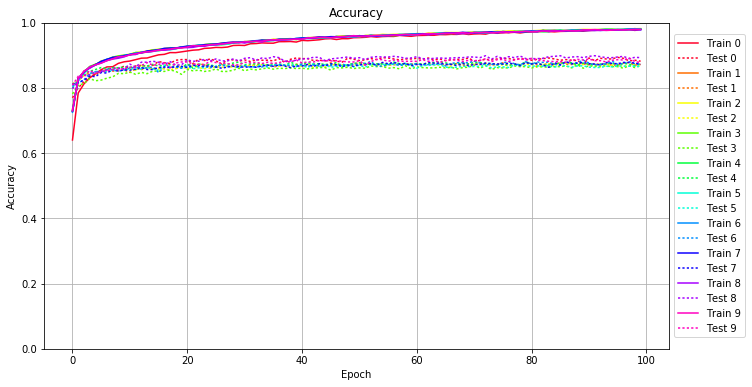

In [17]:
plot_acc(tophistory)

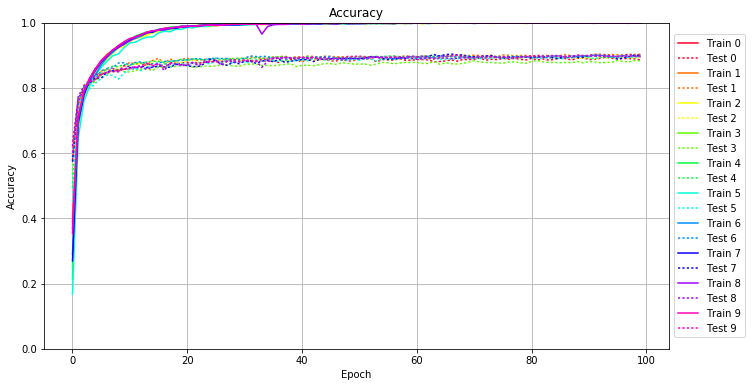

In [18]:
plot_acc(history)

In [19]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Loss.pdf', format='pdf')
    plt.show()

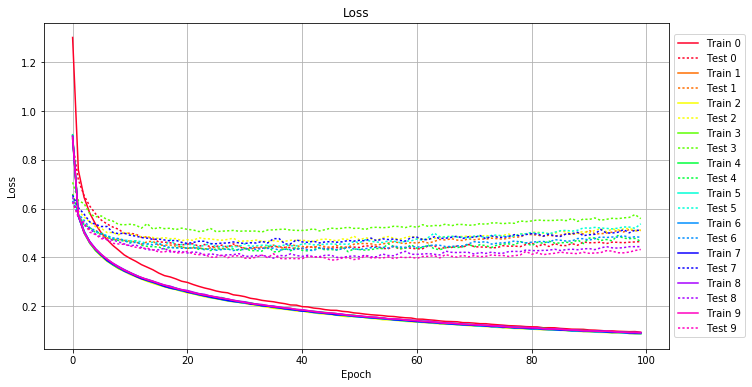

In [20]:
plot_loss(tophistory)

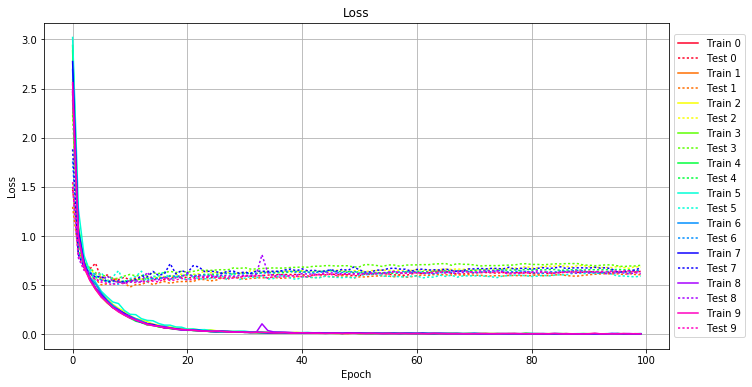

In [21]:
plot_loss(history)

Plotting the confusion matrix


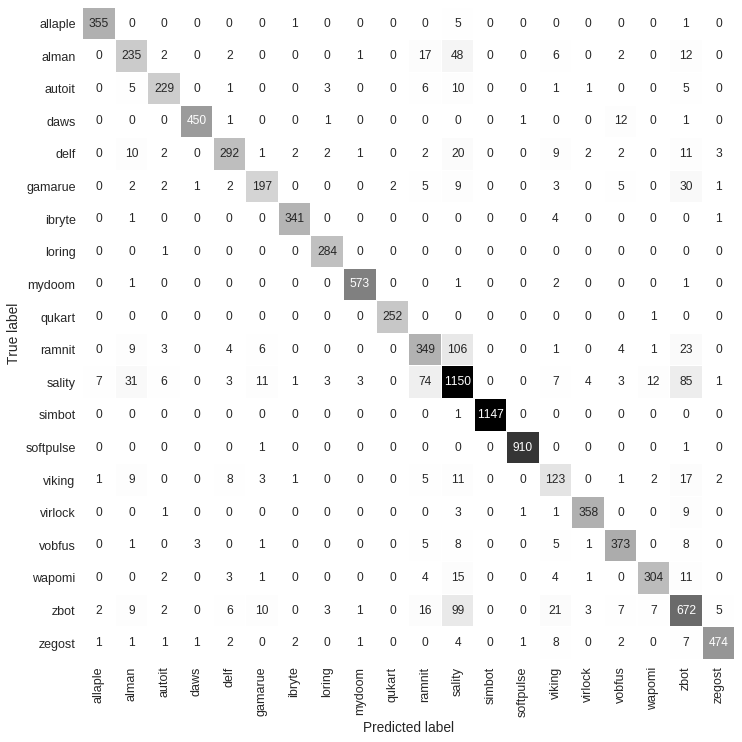

In [22]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 12}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


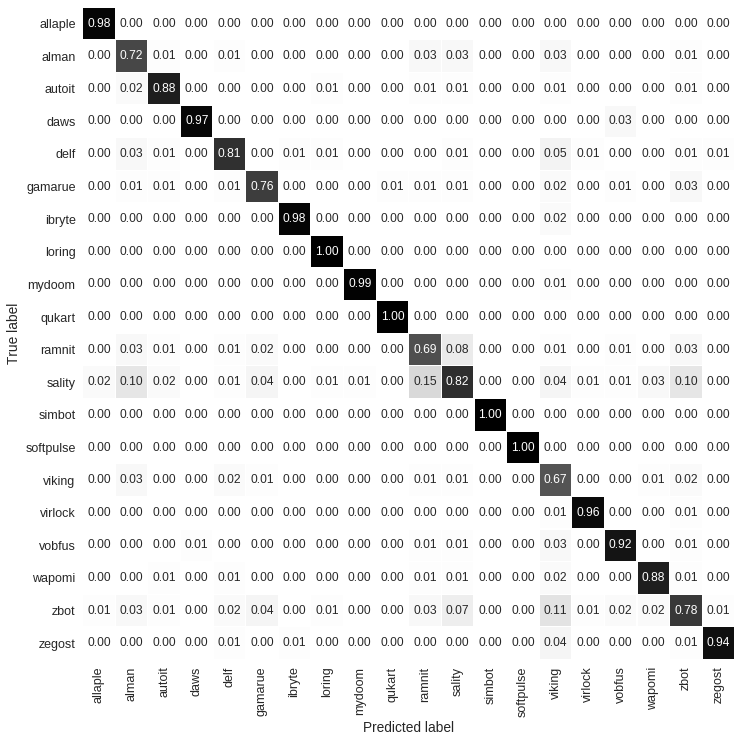

In [23]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 12}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [24]:
for h in tophistory:
    print(h.history)

{'acc': [0.64025460941107049, 0.78435030733942457, 0.81211589113257243, 0.83066286215978924, 0.84317383680351998, 0.85579455668095228, 0.86424495176435878, 0.86479367871782675, 0.87521949078138717, 0.8799385426858729, 0.88224319583810773, 0.88652326612748844, 0.89102282714592562, 0.8915715540470629, 0.89661984196663735, 0.90122914837576817, 0.90276558384547845, 0.9081431079894644, 0.90803336270343227, 0.91044776124636051, 0.91308165057067603, 0.9156057946089593, 0.91670324846356455, 0.92109306419596948, 0.92197102721685686, 0.92405618964003511, 0.92361720818192217, 0.92504389820860811, 0.92998244078981973, 0.93053116779561829, 0.92998244073748904, 0.93525021949078135, 0.93590869193960424, 0.93788410897208896, 0.93722563652326607, 0.93700614584654018, 0.941615452255671, 0.94172519764636464, 0.94216417920913897, 0.94051799829640448, 0.94567603160667257, 0.94468832319509155, 0.94600526783108396, 0.94743195785777001, 0.95017559272977115, 0.95094381046462628, 0.94820017569728643, 0.95083406

In [25]:
for h in history:
    print(h.history)

{'acc': [0.38707199308095636, 0.70862598776084695, 0.78039947322212466, 0.82122475866480182, 0.85667251985883164, 0.87500000010466139, 0.89201053560983723, 0.91022827041264265, 0.92756804219456068, 0.932506584828103, 0.94633450395083407, 0.9512730465320457, 0.95807726085970968, 0.96784460057910859, 0.9698200176115932, 0.97563652337068418, 0.98123353819139592, 0.98189201053555752, 0.98353819139596133, 0.9863915716586561, 0.9873792801748984, 0.98694029850746268, 0.99100087806778692, 0.99100087806778692, 0.99056189640035119, 0.99209833197472286, 0.9928665496049166, 0.9928665496049166, 0.99374451273046527, 0.9948419667420626, 0.99561018437225635, 0.99539069359086918, 0.9958296752583049, 0.99604916593503068, 0.99659789288849865, 0.99659789288849865, 0.99703687445127309, 0.99670763827919229, 0.99714661984196662, 0.99703687445127309, 0.99659789288849865, 0.99714661984196662, 0.99692712906057945, 0.99703687445127309, 0.99736611062335379, 0.99791483757682176, 0.99813432835820892, 0.997695346795

In [26]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

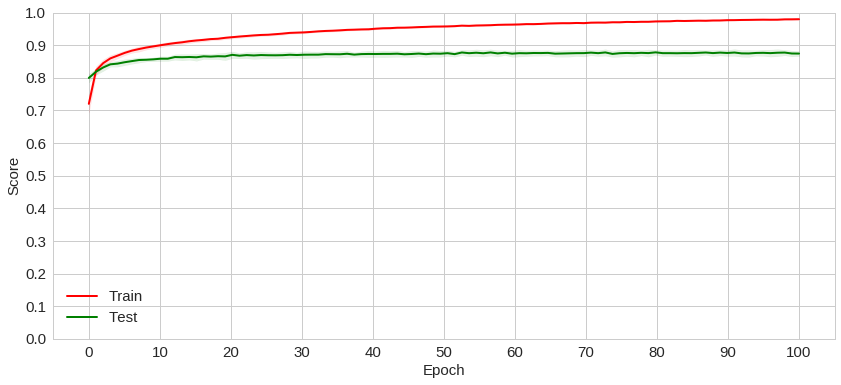

In [27]:
plot_mean_acc(tophistory)

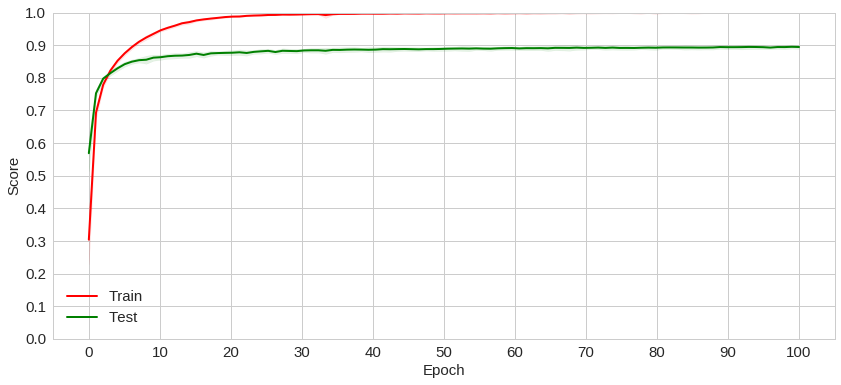

In [28]:
plot_mean_acc(history)

In [29]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

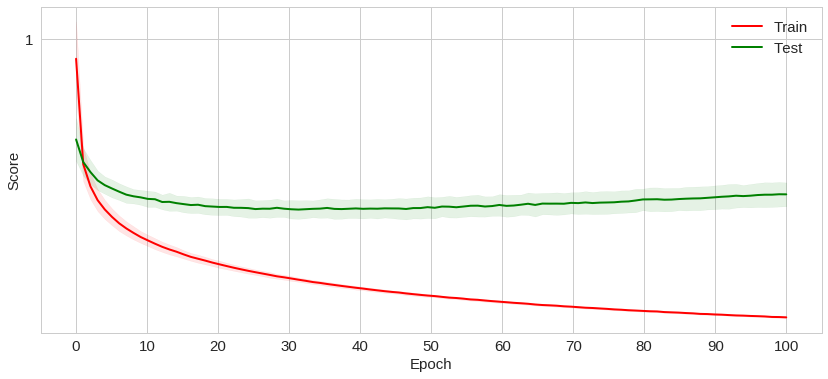

In [30]:
plot_mean_loss(tophistory)

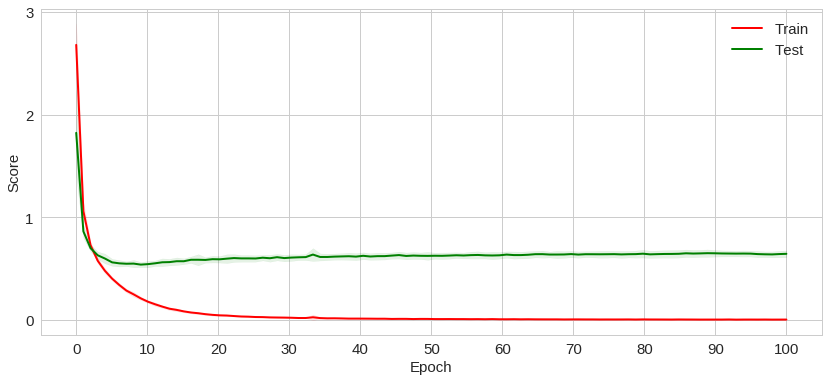

In [31]:
plot_mean_loss(history)

In [33]:
tophistory = [{'acc': [0.64025460941107049, 0.78435030733942457, 0.81211589113257243, 0.83066286215978924, 0.84317383680351998, 0.85579455668095228, 0.86424495176435878, 0.86479367871782675, 0.87521949078138717, 0.8799385426858729, 0.88224319583810773, 0.88652326612748844, 0.89102282714592562, 0.8915715540470629, 0.89661984196663735, 0.90122914837576817, 0.90276558384547845, 0.9081431079894644, 0.90803336270343227, 0.91044776124636051, 0.91308165057067603, 0.9156057946089593, 0.91670324846356455, 0.92109306419596948, 0.92197102721685686, 0.92405618964003511, 0.92361720818192217, 0.92504389820860811, 0.92998244078981973, 0.93053116779561829, 0.92998244073748904, 0.93525021949078135, 0.93590869193960424, 0.93788410897208896, 0.93722563652326607, 0.93700614584654018, 0.941615452255671, 0.94172519764636464, 0.94216417920913897, 0.94051799829640448, 0.94567603160667257, 0.94468832319509155, 0.94600526783108396, 0.94743195785777001, 0.95017559272977115, 0.95094381046462628, 0.94820017569728643, 0.95083406507393264, 0.95072431968323901, 0.95379719062265955, 0.95412642679474036, 0.95500438986795844, 0.95730904302019315, 0.95566286226445063, 0.95719929762949951, 0.95785777007832251, 0.95763827919227396, 0.96082089557471873, 0.95939420554803279, 0.95807726080737898, 0.9603819139596137, 0.96082089557471873, 0.96125987718982375, 0.96125987708516247, 0.9633450395606713, 0.96312554877928414, 0.96411325724319574, 0.96389376656646997, 0.96630816516172902, 0.96367427573275211, 0.96521071115013168, 0.96575943815593035, 0.9646619843013251, 0.96938103604881887, 0.96729587367797132, 0.96894205443371373, 0.96927129071045592, 0.97036874456506117, 0.96828358208955223, 0.97091747157085972, 0.97135645302897278, 0.97212467076382791, 0.97344161545215102, 0.97256365232660225, 0.97168568920105358, 0.97311237928007022, 0.97344161545215102, 0.97388059701492535, 0.97453906935908696, 0.97410008790097391, 0.97585601409974065, 0.97640474100087793, 0.97673397717295873, 0.97706321334503954, 0.97717295873573307, 0.97750219490781387, 0.9772827041264267, 0.97892888498683051, 0.97618525027182146, 0.97947761199262917], 'loss': [1.3024081180135445, 0.7584412150261588, 0.64646676462716024, 0.58118587407864841, 0.53643800764360172, 0.50075070885736972, 0.47318880426140603, 0.44955575767057415, 0.43010207134134631, 0.41014357550924968, 0.39628309927246252, 0.3842441698665468, 0.37045360297043139, 0.3599412195691945, 0.34926953796653815, 0.33589178538301517, 0.32541950841134215, 0.31999533382081691, 0.31188390292129148, 0.30230717548055541, 0.29758745526095248, 0.28888195412948114, 0.28133304447223473, 0.27461715185192198, 0.26921223729351718, 0.26245441137959397, 0.25757693561469391, 0.25490874929894891, 0.24667990147491836, 0.24365698774463782, 0.23918619152743947, 0.23237130399122899, 0.22898308915773749, 0.22387975247624259, 0.22080205685742807, 0.21811407907842228, 0.21369875335609631, 0.21018611413407892, 0.20506812456776113, 0.20434617959584345, 0.19824905249374389, 0.19691854315017587, 0.19228364183151272, 0.19003230278381034, 0.1858793206650296, 0.18332621177839961, 0.18288193746446202, 0.17888634567516115, 0.17692685684580045, 0.17268833261607927, 0.17059353824714699, 0.16740363212245091, 0.16492075230386616, 0.16321912793159693, 0.16139468681508767, 0.1586387601596834, 0.15759574363533083, 0.15468599599531807, 0.15248167378741256, 0.15150828312843698, 0.14700246922822247, 0.14673029174136948, 0.14421250172044436, 0.14239912879791461, 0.13967934433988985, 0.13752888440039202, 0.13690333985793057, 0.13613200140585494, 0.13254876737012689, 0.13229375963832748, 0.13055488800824577, 0.12824108906227627, 0.12813965104932426, 0.12561362178520324, 0.12387352782817553, 0.12215065657830845, 0.12004877973586661, 0.11922011869167214, 0.11816030806151265, 0.11622330076711235, 0.11535717930262082, 0.11497930609363542, 0.11156790843029049, 0.11166961689964526, 0.11139893856249534, 0.10888927518222498, 0.10746796109940107, 0.10577533103008874, 0.10543618965452443, 0.10507458966483768, 0.10244819307348203, 0.10178651018321672, 0.10024686634239656, 0.098417789470060968, 0.098669932142907424, 0.097134929493763025, 0.096318551012959996, 0.095456078825183241, 0.095929381837438765, 0.093142388262593814], 'val_acc': [0.76953125, 0.7998046875, 0.8193359375, 0.833984375, 0.8408203125, 0.8525390625, 0.8564453125, 0.8603515625, 0.8603515625, 0.8662109375, 0.861328125, 0.8671875, 0.869140625, 0.8662109375, 0.869140625, 0.880859375, 0.876953125, 0.875, 0.884765625, 0.88671875, 0.88671875, 0.8740234375, 0.888671875, 0.8837890625, 0.888671875, 0.8828125, 0.873046875, 0.88671875, 0.8857421875, 0.8818359375, 0.8857421875, 0.880859375, 0.88671875, 0.884765625, 0.884765625, 0.8828125, 0.8896484375, 0.8779296875, 0.8876953125, 0.8916015625, 0.8896484375, 0.8896484375, 0.8837890625, 0.884765625, 0.8828125, 0.884765625, 0.8818359375, 0.87890625, 0.8916015625, 0.8876953125, 0.8837890625, 0.8857421875, 0.8896484375, 0.88671875, 0.892578125, 0.8916015625, 0.888671875, 0.8857421875, 0.888671875, 0.888671875, 0.890625, 0.8876953125, 0.8916015625, 0.8857421875, 0.888671875, 0.8837890625, 0.8857421875, 0.8876953125, 0.88671875, 0.8916015625, 0.8818359375, 0.8837890625, 0.8876953125, 0.8857421875, 0.888671875, 0.890625, 0.8896484375, 0.88671875, 0.8896484375, 0.8876953125, 0.884765625, 0.8876953125, 0.8896484375, 0.8916015625, 0.888671875, 0.884765625, 0.88671875, 0.884765625, 0.8837890625, 0.873046875, 0.8916015625, 0.8837890625, 0.890625, 0.888671875, 0.888671875, 0.8935546875, 0.890625, 0.8828125, 0.884765625, 0.8818359375], 'val_loss': [0.8710099128074944, 0.71825796505436301, 0.65359812323004007, 0.61045558867044747, 0.57899412256665528, 0.55307350913062692, 0.53719771967735142, 0.52474090782925487, 0.51556900568539277, 0.49887048173695803, 0.49920477287378162, 0.49539935687789693, 0.48282831197138876, 0.48469330897205509, 0.47675318375695497, 0.46350400761002675, 0.46268901825533248, 0.46002443190081976, 0.45375618690741248, 0.45145991325262003, 0.45462679099000525, 0.45611180074047297, 0.44560280979203526, 0.45307513637089869, 0.44353856992529472, 0.44491359581297729, 0.45027036826650146, 0.44196329692204017, 0.4557152861598297, 0.44365090188512113, 0.43576433846465079, 0.44030851092247758, 0.43872445411398076, 0.43787621836963808, 0.43832751238005585, 0.44607959940913133, 0.4437886102059565, 0.44116870726429624, 0.44062696639957721, 0.43468715534982039, 0.43648874917198555, 0.44135780164469907, 0.44409575031022541, 0.43758800329305814, 0.43766882770978555, 0.43771499635113287, 0.44054934616360697, 0.43897160018786963, 0.44212768333818531, 0.44236558516240621, 0.4408167071214848, 0.44788277276893496, 0.44590115497885563, 0.44432595574198785, 0.43694929904995661, 0.43605049978214083, 0.44522493278236652, 0.434326204919671, 0.44064893322320131, 0.43773038973995426, 0.43518972950369061, 0.43578901065575337, 0.44778092926389945, 0.44851693104556034, 0.4354338344851385, 0.4412422833297569, 0.44097590413639409, 0.44639459452264418, 0.44192704739816691, 0.45309125214089363, 0.44433033102450281, 0.44260770909431812, 0.44279993323198141, 0.43954455214361587, 0.44031581354283844, 0.44815168790364623, 0.44600661717367984, 0.44659029989156807, 0.44427386267580005, 0.45314021863805465, 0.46006239658959203, 0.44400797629191402, 0.45536475831909229, 0.44502328554744963, 0.45681528491263634, 0.44924584435375436, 0.44849063022263636, 0.45678098771486475, 0.44990660776852565, 0.46371318333751788, 0.46032168759836622, 0.46068626507189947, 0.46230407681207453, 0.45677701676686411, 0.46272016705381702, 0.46201197846016839, 0.46034561201003044, 0.46237202344258321, 0.46356037553090346, 0.46509422297657466]},
{'acc': [0.73491332020601574, 0.8240070223599012, 0.8519859558557088, 0.86131226703841779, 0.87261356174985072, 0.87798990592743076, 0.8856703972957729, 0.89269256107844308, 0.89357033164610533, 0.89861751146841817, 0.90070221655353633, 0.90783410156560562, 0.90838270802651677, 0.90937019978433897, 0.91672152742524404, 0.91397849471521453, 0.91748957665886877, 0.92034233057213788, 0.92045205188001589, 0.92275619925389507, 0.92725477306000992, 0.92802282213667697, 0.92999780577003943, 0.93197278929876348, 0.93219223182296085, 0.9331797235938627, 0.93614219899812712, 0.93855606758832566, 0.93965328066710552, 0.93921439544867336, 0.94206714962353855, 0.94228659205617726, 0.94305464130288186, 0.94481018222892965, 0.94678516567917492, 0.94722405109380403, 0.94755321492587941, 0.95029624762282916, 0.95095457556165575, 0.94952819837612468, 0.95139346061005048, 0.95238095238095233, 0.95336844424341294, 0.95479482124582671, 0.95413649330700023, 0.95369760818012661, 0.95797673908272984, 0.95731841132702056, 0.95819618188160305, 0.9580864604821665, 0.95852534572675818, 0.96017116524028967, 0.96028088663972622, 0.96039060786912545, 0.96181698504157676, 0.96050032925548223, 0.96269475532148341, 0.96346280447662935, 0.96225587008997149, 0.96445029624753131, 0.96390168970814127, 0.96488918157060177, 0.96697388643336346, 0.96730305025235896, 0.96708360763660306, 0.96719332894448107, 0.96927803397727996, 0.96829054202326093, 0.96916831248628488, 0.96938775510204078, 0.97059468948869876, 0.97114329602808869, 0.97202106658267118, 0.9701558043749049, 0.97169190256747862, 0.97147246004328125, 0.97213078779899054, 0.97136273864384459, 0.97344744349352641, 0.97377660741716043, 0.97377660750871897, 0.97509326320325485, 0.9759710336662788, 0.97564186965108624, 0.97739741057713403, 0.97553214834320823, 0.97597103357472026, 0.97586131235840079, 0.97684880412930275, 0.97794601711652407, 0.97805573851596062, 0.97816545973227997, 0.97838490243959453, 0.97893350888742592, 0.97827518104015798, 0.97970155822568905, 0.97849462374747254, 0.98003072214932307, 0.98167654167593432, 0.97981127944200841], 'loss': [0.88526627584222584, 0.57420149027634171, 0.50567308919116383, 0.4608336694674296, 0.43223798219404752, 0.40937908897280617, 0.38874419122143011, 0.3713317767737177, 0.36093734694280616, 0.34572522780705317, 0.33800384528168154, 0.32437004204222264, 0.31405702216964765, 0.30558992610025854, 0.29977403377424555, 0.29273931358057809, 0.2833164336324549, 0.27591652513557496, 0.26979588739948362, 0.26549561139599182, 0.25687223892607447, 0.25162840643249795, 0.24862608097743799, 0.24290505398554527, 0.23875982905064649, 0.23434933317657206, 0.22938901120590385, 0.22383943481654067, 0.22008963801344419, 0.21738724145667973, 0.21232375214830784, 0.20942120992721422, 0.20767551223018438, 0.20255064380608395, 0.19888624303257071, 0.19577586659023263, 0.19270186010148929, 0.18852922031302344, 0.18559720096604876, 0.18373410161752202, 0.18208458548951678, 0.17692838442451159, 0.17526473669674095, 0.1724882831509657, 0.17065590065784403, 0.16907992245192482, 0.16591160713200614, 0.16260651092414719, 0.16166819709551186, 0.15808811233131043, 0.15828801255320832, 0.15537665093418587, 0.15248369634321496, 0.15056493175325358, 0.14849725940495906, 0.146582248704277, 0.14458019070332187, 0.14258903627309827, 0.1420109039092825, 0.13829713081542483, 0.13679169399947066, 0.13492899666184105, 0.13282883678686994, 0.13167662991160542, 0.12929171744945778, 0.12772640544043995, 0.12651377695941443, 0.12561347936266787, 0.12444296013257314, 0.12300619746879028, 0.12099072641255904, 0.118000009099407, 0.11826579594510099, 0.11816538038132404, 0.11557594331466553, 0.11536475581468289, 0.11302863236370383, 0.11307831082247002, 0.10940936684693478, 0.10951030460043855, 0.1076238487918884, 0.10653911352759264, 0.1045359384447552, 0.10366600671517814, 0.1018012175097365, 0.10101129905628692, 0.10124419521011489, 0.099919226904278499, 0.099251361839703775, 0.097152378724833607, 0.096966669901907901, 0.095956565990033632, 0.093617299008793231, 0.094601835659853278, 0.092143348290035024, 0.091265554726450801, 0.091800705867167334, 0.090019197527557077, 0.088274889699795911, 0.088402354360176127], 'val_acc': [0.8121330726403313, 0.82191780658617408, 0.83953033011486855, 0.84540117253529345, 0.84246575365794385, 0.8483365932789334, 0.85420743383306819, 0.85127201215628312, 0.85225048947007687, 0.85518590554799123, 0.84735811876457501, 0.85909980080598958, 0.85616438006234963, 0.86105674796841614, 0.86007827532034797, 0.86105674703527102, 0.85909980080598958, 0.86497064136012425, 0.85909980080598958, 0.86497064136012425, 0.86986301019933587, 0.87279843000983071, 0.87181995642861743, 0.87181995642861743, 0.86497064229326937, 0.86399216777891097, 0.87181995736176254, 0.86692758852255092, 0.8679060621037642, 0.86888453568497748, 0.86692758945569603, 0.86888453661812259, 0.87084148378054926, 0.87084148471369438, 0.86986300926619076, 0.86399216777891097, 0.8679060621037642, 0.86888453568497748, 0.86692759038884115, 0.87279843000983071, 0.86692758852255092, 0.8679060621037642, 0.87279843000983071, 0.8679060621037642, 0.8679060621037642, 0.87671232433468393, 0.87084148284740415, 0.86986300926619076, 0.86888453568497748, 0.87475537717225738, 0.87573385075347066, 0.87084148284740415, 0.87573385075347066, 0.86888453568497748, 0.87573385075347066, 0.86986300926619076, 0.87084148284740415, 0.87279843000983071, 0.87475537717225738, 0.87279843187612094, 0.87279843000983071, 0.87084148284740415, 0.87279843000983071, 0.87181995642861743, 0.87279843000983071, 0.87084148284740415, 0.87181995642861743, 0.87475537717225738, 0.86692758852255092, 0.87377690359104399, 0.87181995642861743, 0.87377690359104399, 0.87573385075347066, 0.86888453568497748, 0.87279843000983071, 0.87671232433468393, 0.87475537717225738, 0.87181995642861743, 0.86986300926619076, 0.87671232433468393, 0.87377690359104399, 0.86986300926619076, 0.87181995642861743, 0.87377690359104399, 0.87279843000983071, 0.87671232433468393, 0.87279843000983071, 0.87181995642861743, 0.87573385075347066, 0.87377690359104399, 0.87084148284740415, 0.87377690359104399, 0.87181995736176254, 0.87377690359104399, 0.86986300926619076, 0.86986300926619076, 0.87573385075347066, 0.87769079791589721, 0.86986300926619076, 0.87181995642861743], 'val_loss': [0.62796408095471778, 0.56993400659813109, 0.53688244836554366, 0.51302055005574643, 0.51238496000869405, 0.49001047621734456, 0.48058354802094327, 0.4715883155624927, 0.47511583635193494, 0.46963945211233926, 0.46710586404234694, 0.46382825904746344, 0.45413522406275258, 0.46442542320624025, 0.46629282024391944, 0.44946230636679962, 0.45039099868233889, 0.45097687656202018, 0.44663323932591598, 0.44296176653581354, 0.43719208198590404, 0.43921851831143849, 0.43881447185669276, 0.43471372744648074, 0.43918916658605878, 0.44129692330963749, 0.43598801906014667, 0.44269487727433443, 0.44881502050294042, 0.44733503224955118, 0.43747994691541753, 0.43306647639160289, 0.44188900387056768, 0.44311130422016209, 0.44117317204555012, 0.45070510756483195, 0.44012950892412556, 0.43858169656522106, 0.45259446839286188, 0.44761503293587229, 0.44413294913493273, 0.44467991051480993, 0.44056925420383258, 0.44972516893096626, 0.44427943994052371, 0.44140979919469608, 0.44838622524703758, 0.44258571444913097, 0.44191773960625647, 0.45417900484077151, 0.45661389274675757, 0.45753705407900158, 0.45569533868073148, 0.450287111356869, 0.45583556417864246, 0.45878958284997046, 0.46448484659759937, 0.45941769841756791, 0.45702047903856641, 0.46108184220089804, 0.45891233105367368, 0.46491437415166809, 0.45917582134451945, 0.46542596836836825, 0.47400410843620333, 0.47144554996256555, 0.47719893608948055, 0.47119520032392687, 0.46936376047297429, 0.47640322148230352, 0.47261155064534643, 0.47568557044040549, 0.4751821831123878, 0.47895769924277382, 0.47699686254505907, 0.47524141815073317, 0.47901779575777559, 0.48425626354563139, 0.4833002927786112, 0.49534808163662802, 0.49339106415752448, 0.49175748628879823, 0.48672013724559493, 0.49116815265628383, 0.48738892278446633, 0.49124403344313505, 0.49640714395937097, 0.49422709463918174, 0.49918505699559057, 0.49671172052407692, 0.51143088019565186, 0.49695662970759691, 0.4968688430338149, 0.49992641214573041, 0.50375461479357742, 0.51127951458745102, 0.50455680914386258, 0.51451474577023604, 0.50870744390312639, 0.51098260615574187]},
{'acc': [0.72784115845511599, 0.82525230390348681, 0.84927599829715195, 0.86243966667732685, 0.87044756482598451, 0.88284335250444401, 0.88712154464169313, 0.88997367282037199, 0.89732338760755936, 0.90039491007442063, 0.90368582716946433, 0.90818341377797285, 0.90982887241703314, 0.91333918385256696, 0.91684949549733152, 0.91849495397946879, 0.92025010985415878, 0.9233216323471739, 0.92145677939377735, 0.9245283019914079, 0.92639315499711217, 0.9283677051338306, 0.93154892512401399, 0.93264589742800286, 0.93352347520842471, 0.93352347531304014, 0.93736287845546296, 0.93736287850777067, 0.93911803422553752, 0.94021500663414181, 0.94109258462379464, 0.94284774028925378, 0.94328652917946465, 0.94668714348398419, 0.94580956570356234, 0.94942957447934118, 0.94899078548451488, 0.95008775784081145, 0.94975866613392246, 0.95052654678333015, 0.95206230808214531, 0.95425625274243087, 0.95469504173725728, 0.95458534450162758, 0.95601140866942869, 0.95623080303607255, 0.95645019755963956, 0.95908293126705912, 0.9593023256337031, 0.95897323403142953, 0.95721807815673954, 0.96028960085898551, 0.9606186925658744, 0.96149627039860408, 0.96423870139396106, 0.96336112335200053, 0.96423870123703781, 0.96423870128934563, 0.96456779294392681, 0.96456779289161909, 0.96621325142606407, 0.9655550681169015, 0.96731022378236065, 0.96698113218008719, 0.96785870996050904, 0.97016235196103962, 0.96961386578289133, 0.96994295748978032, 0.96873628789785404, 0.96928477407600233, 0.97049144366792861, 0.97136902155296589, 0.97082053532250989, 0.97191750773111418, 0.97400175515577003, 0.97268538832821416, 0.97465993856954802, 0.97476963596210087, 0.97312417732304046, 0.97465993862185574, 0.97520842474769631, 0.975976305397104, 0.97608600263273371, 0.9758666081614743, 0.97476963580517773, 0.97784115845511599, 0.97575691097815243, 0.97784115845511599, 0.97838964463326428, 0.97937691970162355, 0.97915752533497968, 0.97849934186889398, 0.97882843352347526, 0.97959631422519056, 0.98102237834068384, 0.97773146116717857, 0.97849934181658627, 0.98036419487459825, 0.98124177281194325, 0.98179025888547611], 'loss': [0.89552178512073599, 0.57139865580019378, 0.50011895601557976, 0.45755994649454396, 0.42957562979714503, 0.40347816116091134, 0.38376958768270475, 0.36980669954305367, 0.35383574998708295, 0.34241027227092491, 0.32984686824981452, 0.32070128271170695, 0.31061186076204417, 0.30155075982559559, 0.29347926705173361, 0.28616083819074239, 0.27925790159155162, 0.27283036383216241, 0.26778529196676848, 0.26082297721522163, 0.25429407452584984, 0.25143898102263185, 0.24365942566579976, 0.23888337584036701, 0.23415568907724341, 0.2307133615971553, 0.22623321708878597, 0.22097457140461821, 0.21790697620123192, 0.21533837554851296, 0.21180179715156555, 0.20699747432449922, 0.20303409855883076, 0.19945001372672738, 0.19572805639760124, 0.19125015308533702, 0.18908843028017072, 0.18693794823362411, 0.18420259205656336, 0.18010861096072481, 0.17998498553976566, 0.17473604924038555, 0.17305206172348062, 0.16917086398525685, 0.16739426931826468, 0.16568994668556336, 0.16292933416816424, 0.15891516498302671, 0.15669423245635666, 0.1581591871052575, 0.15697342214902382, 0.15224637175506017, 0.14942766370978361, 0.14820764191896574, 0.14434784729264188, 0.14396113402464766, 0.14225118929955874, 0.14012372742859405, 0.1373551540884233, 0.13606034289226557, 0.13539263015975028, 0.13275867603807504, 0.13232126469123567, 0.12917171308166786, 0.12800746509489022, 0.12560139988770136, 0.12571403853670449, 0.12377049060258075, 0.12224332985973714, 0.12020521563571396, 0.11926761104146238, 0.11768829908848018, 0.11627617002697355, 0.1149918374888674, 0.11261243963905886, 0.11191241716138099, 0.1102776569087498, 0.10834258720246047, 0.10783612410349509, 0.10704359525308739, 0.10551504464186613, 0.10437458763393513, 0.10369116620386624, 0.10336857488662489, 0.10268791277532047, 0.10110451844359448, 0.10036815149107227, 0.097204695934263854, 0.096689984457385081, 0.095644020810952149, 0.094737567886965163, 0.093437698259851612, 0.092247060625542152, 0.091912187783014049, 0.090094427664377225, 0.091558652391764306, 0.090129792539892409, 0.087818711731270663, 0.086858496141831248, 0.085994819000186809], 'val_acc': [0.81078431606292722, 0.82156863072339226, 0.83725490429822136, 0.84313725887560376, 0.84901961018057426, 0.84901961181678021, 0.85588235691481951, 0.86078432027031393, 0.85882353338540773, 0.85686274907168225, 0.85784314122854499, 0.85392157260109391, 0.86862745752521586, 0.85980392554227048, 0.85784314122854499, 0.85784314122854499, 0.85882353338540773, 0.85490196475795666, 0.85980392554227048, 0.86470588632658418, 0.85784314122854499, 0.86764706279717241, 0.86176471242717667, 0.85882353338540773, 0.86078431769913322, 0.8647058888977649, 0.86274510458403941, 0.86666667064030967, 0.86274509944167788, 0.8647058888977649, 0.86568627848344692, 0.8696078496820786, 0.86764706279717241, 0.87156863399580409, 0.8696078496820786, 0.8696078496820786, 0.86666667321149038, 0.8696078496820786, 0.8696078496820786, 0.86862745752521586, 0.86666667321149038, 0.87352941830952957, 0.8627451020128587, 0.8696078496820786, 0.86372549674090215, 0.86862745752521586, 0.87254902615266683, 0.87058824183894135, 0.86764706279717241, 0.8696078496820786, 0.87254902615266683, 0.87058824183894135, 0.87352941830952957, 0.87058823926776063, 0.86568628105462764, 0.86960784711089789, 0.87254902615266683, 0.87254902615266683, 0.87254902615266683, 0.86862745752521586, 0.87254902615266683, 0.87352941830952957, 0.87549020262325516, 0.87156863399580409, 0.8696078496820786, 0.87254902615266683, 0.86568628105462764, 0.87352941830952957, 0.87352941830952957, 0.86764706536835312, 0.87450981046639231, 0.87058824183894135, 0.87156863399580409, 0.87156863399580409, 0.87058824183894135, 0.87058824183894135, 0.86764706536835312, 0.87352941830952957, 0.87058824183894135, 0.87156863399580409, 0.87156863399580409, 0.86372549674090215, 0.87058824183894135, 0.87352941830952957, 0.86764706279717241, 0.87647059478011791, 0.87549020262325516, 0.87450981046639231, 0.87058824183894135, 0.87156863399580409, 0.87549020262325516, 0.8696078496820786, 0.86372549674090215, 0.87156863399580409, 0.8696078496820786, 0.86666667064030967, 0.86764706536835312, 0.86862745752521586, 0.87156863399580409, 0.8696078496820786], 'val_loss': [0.66093831085691268, 0.5918751710770177, 0.56542209153081857, 0.54518231474885759, 0.5257087491014425, 0.51984633869108032, 0.5019612947369323, 0.50213950355263315, 0.49279687663211541, 0.50322381653914261, 0.49586623215353959, 0.49198062254809866, 0.48392131844279812, 0.4851464839177389, 0.48157322805593994, 0.47814529298567304, 0.48130275592500088, 0.47704594557483992, 0.47739439482855445, 0.46885161097800615, 0.47311416679956747, 0.46994472499936818, 0.48064448853552927, 0.47692883299188871, 0.47588670742058869, 0.47250926968112006, 0.4706883328674617, 0.47374336869255002, 0.478946057761855, 0.46600008925934339, 0.46759967544645653, 0.4678104518054455, 0.47140687585936164, 0.46544899896115943, 0.46546007888209001, 0.46911040412298605, 0.46548660226604516, 0.46644136673752584, 0.47045929635162737, 0.46994478373295245, 0.47067112039920744, 0.46790972211964282, 0.46571130112416165, 0.47317061368010793, 0.47517422406715065, 0.47225873532394569, 0.46789774548572799, 0.47568649656422363, 0.47399370002596841, 0.4874960560360741, 0.4721311016368917, 0.48051688668783754, 0.4766085062020769, 0.46953909064451343, 0.48102831547924629, 0.4856981571019609, 0.47856811242652875, 0.47506613343926696, 0.48145938664743237, 0.48713412174644571, 0.48004494569191308, 0.47552719342193622, 0.47425009774993737, 0.47786756014684217, 0.4840575237231165, 0.48544618528559985, 0.48590808326855539, 0.4854695711683199, 0.48620754462705612, 0.48713862273851227, 0.48545566936486911, 0.4861814367793747, 0.49063663941878805, 0.48508761655721888, 0.48720483806237636, 0.49069130715843307, 0.49583051313672388, 0.48735494152271858, 0.49788729611010402, 0.4947455706833816, 0.50283656305400659, 0.50365031738388899, 0.49907160233574982, 0.49789155407331648, 0.49779721047910724, 0.50945236337806021, 0.50427450338268986, 0.49859467597436341, 0.49991769236289924, 0.5067321468273055, 0.49927192261900782, 0.51112595523280147, 0.51776333274790565, 0.50536325373698265, 0.51648111375857386, 0.51347328095186695, 0.51672748199650642, 0.51949226161237927, 0.51045488260932348, 0.51255644305007686]},
{'acc': [0.73124999999999996, 0.82894736842105265, 0.84692982456140353, 0.86578947368421055, 0.87247807017543855, 0.87796052631578947, 0.88706140350877194, 0.89418859649122806, 0.89824561403508774, 0.90000000000000002, 0.90197368421052626, 0.9084429824561403, 0.90811403508771926, 0.91129385964912279, 0.91589912280701757, 0.9174342105263158, 0.91984649122807016, 0.92214912280701755, 0.92302631578947369, 0.92346491228070171, 0.9263157894736842, 0.92785087719298243, 0.9297149122807018, 0.93245614035087721, 0.93486842105263157, 0.93497807017543855, 0.93344298245614032, 0.93815789473684208, 0.93717105263157896, 0.94067982456140353, 0.94035087719298249, 0.94144736842105259, 0.9441885964912281, 0.9441885964912281, 0.94484649122807018, 0.94594298245614039, 0.94813596491228069, 0.94835526315789476, 0.95032894736842111, 0.94769736842105268, 0.95328947368421058, 0.95307017543859651, 0.95076754385964912, 0.95383771929824557, 0.95328947368421058, 0.95548245614035088, 0.95712719298245619, 0.95778508771929827, 0.95855263157894732, 0.9575657894736842, 0.95712719298245619, 0.96019736842105263, 0.9604166666666667, 0.95953947368421055, 0.95975877192982462, 0.96239035087719293, 0.96250000000000002, 0.96228070175438596, 0.96304824561403513, 0.96436403508771928, 0.96633771929824563, 0.96600877192982459, 0.96337719298245617, 0.96611842105263157, 0.96776315789473688, 0.96732456140350875, 0.96842105263157896, 0.96864035087719302, 0.96754385964912282, 0.96984649122807021, 0.96962719298245614, 0.97017543859649125, 0.97028508771929822, 0.97192982456140353, 0.97072368421052635, 0.97291666666666665, 0.97171052631578947, 0.97291666666666665, 0.97357456140350873, 0.97236842105263155, 0.9743421052631579, 0.97335526315789478, 0.97664473684210529, 0.97576754385964914, 0.97478070175438591, 0.97554824561403508, 0.97532894736842102, 0.97664473684210529, 0.9765350877192982, 0.97686403508771935, 0.97675438596491226, 0.97828947368421049, 0.97883771929824559, 0.98004385964912277, 0.97960526315789476, 0.97763157894736841, 0.97938596491228069, 0.97883771929824559, 0.98026315789473684, 0.98124999999999996], 'loss': [0.89841216028782356, 0.57043968250876975, 0.50313528462460166, 0.45815307989455106, 0.42709568592540004, 0.40638489022589569, 0.38603558263234927, 0.36886298917887506, 0.35438703361310459, 0.34372533392487908, 0.33489351272583007, 0.32208549296646788, 0.31345054036692571, 0.30404609629982399, 0.29845177661954309, 0.28824368370206732, 0.28108442483241097, 0.27440487177748429, 0.26930431859535081, 0.26277762055397036, 0.25807761089843617, 0.25124329820013885, 0.24712242431807938, 0.24212129387939185, 0.23692672325853717, 0.23123514233973988, 0.22815775646452319, 0.22345629099168277, 0.2216699719951864, 0.21572902338546618, 0.21225883626101311, 0.21084454890928769, 0.20518811752921656, 0.20082848553071941, 0.20176969698646613, 0.19451064723625519, 0.19220771899348812, 0.18884143269898598, 0.18648435724409004, 0.18382125831486887, 0.17958119349521504, 0.17832880119482677, 0.17480222397206122, 0.17203041299393301, 0.17128755335222212, 0.16831295124271459, 0.16311838890899691, 0.16213559045603401, 0.16022640816998063, 0.15766207792779854, 0.15692328146675177, 0.15389347081644494, 0.15223294297854106, 0.15015335760095663, 0.14831428292550539, 0.14649222440886916, 0.14564472206851892, 0.14228695474172892, 0.14041849638809237, 0.13837698052326838, 0.13613988852553199, 0.13549656483687852, 0.1335740279471665, 0.13224673124781827, 0.12920094137651877, 0.12872966154102694, 0.12695625565553967, 0.12533594746338694, 0.12383340147503635, 0.12172627889534883, 0.12063925864926556, 0.1192425467988901, 0.11806909572659877, 0.11853586743798172, 0.11527222392328998, 0.11287337729805394, 0.11256668298390873, 0.11096994101739767, 0.10959895653159994, 0.10870345266241777, 0.10785110514414938, 0.10802519684820844, 0.10532032499710718, 0.10500164024139705, 0.10381005972362402, 0.10270480790682006, 0.10107459564480865, 0.099150653863162325, 0.099667446263003764, 0.099255105068809107, 0.097841898979325048, 0.095572923908108162, 0.094778293867905941, 0.093535221172006508, 0.092250319426519831, 0.093043314377989683, 0.091424794991811123, 0.089753488830307079, 0.09009609443315289, 0.089001945576124022], 'val_acc': [0.78149606486943768, 0.8080708666110602, 0.81299212598425197, 0.82874015701098702, 0.82185039417011529, 0.82381890045376271, 0.82972440851016305, 0.8336614168535067, 0.84448818850704999, 0.84350393935451362, 0.84842519591173793, 0.84153543213221027, 0.8474409444125619, 0.84350393653854605, 0.85137795181724973, 0.85137795181724973, 0.85039370031807371, 0.85531496250723293, 0.8503936998487458, 0.84153543260153818, 0.85629921447573687, 0.85236220378575367, 0.85433070772276154, 0.85039370313404117, 0.85236220425508158, 0.85826771841274474, 0.85039370313404117, 0.85039370266471326, 0.854330710538729, 0.86023621953378515, 0.85236220378575367, 0.85728346362827335, 0.85531496250723293, 0.85826771841274474, 0.86122047150228909, 0.8572834664442408, 0.86023621953378515, 0.85925197038124868, 0.86122047525691237, 0.85925197038124868, 0.86023622000311306, 0.8582677165354331, 0.86023621953378515, 0.86220472628676048, 0.86220472628676048, 0.85433070772276154, 0.86220472628676048, 0.86122047150228909, 0.86318897590862487, 0.85925196850393704, 0.86122047150228909, 0.86023622234975261, 0.8671259833133127, 0.86515747937630483, 0.86614173134480876, 0.86023621953378515, 0.86220472394012093, 0.85826771559677728, 0.86811023575114454, 0.85826771606610519, 0.8641732278771288, 0.86220472628676048, 0.861220471971617, 0.861220471971617, 0.86318897543929696, 0.86122047244094491, 0.86318897825526442, 0.85826771606610519, 0.86220472440944884, 0.86318897543929696, 0.87007874203479196, 0.86023622281908052, 0.86811023809778409, 0.85629921165976941, 0.86220472394012093, 0.86122047150228909, 0.86122047150228909, 0.86712598612928016, 0.86515747984563274, 0.86515748219227229, 0.861220471971617, 0.86515747984563274, 0.86417322740780089, 0.86318897543929696, 0.86515747937630483, 0.86515748313092811, 0.86712598612928016, 0.86122047244094491, 0.87106299118732844, 0.86023621953378515, 0.86811023528181663, 0.86515748219227229, 0.8671259833133127, 0.86712598612928016, 0.86515747984563274, 0.86515748031496065, 0.86023622000311306, 0.86811023528181663, 0.86220472440944884, 0.86811023575114454], 'val_loss': [0.70805701232097285, 0.63360588302410492, 0.6206443132612649, 0.57887485959222462, 0.56657124809392789, 0.57026731641596462, 0.55515250485889089, 0.54950699336298803, 0.53544200936288344, 0.53387224859389382, 0.53606648809151858, 0.53291422438140457, 0.52010915896994625, 0.53876001999427481, 0.51593819716725298, 0.52300426670474798, 0.51816917969808574, 0.51979220883671462, 0.51429102433420071, 0.5201467652878482, 0.51502149665038888, 0.5128888265105096, 0.50615763196384345, 0.50884565527506875, 0.51922537517499212, 0.50604199028324603, 0.50774985672099382, 0.50902662000721544, 0.51092907480756189, 0.50737671358015857, 0.50857192010703078, 0.50796285315277423, 0.50827416646528956, 0.50446577506015211, 0.51213176404474314, 0.51308678156938259, 0.51505322199943659, 0.5159697804799831, 0.51216500724425662, 0.51083357686976216, 0.51064284322380027, 0.51275340232706634, 0.51754737213688473, 0.50869584848139959, 0.51387679466141722, 0.52031702362825938, 0.51789441116852686, 0.51986432991469078, 0.52376630310978423, 0.51904459828355054, 0.51987514556816405, 0.51449678327011006, 0.52239109798404204, 0.52385641934279548, 0.52188647786883169, 0.52332278729006687, 0.52811725149536137, 0.52644229128003017, 0.52256273260105435, 0.52839969785762109, 0.52328510602682232, 0.53421445333263218, 0.52735950109272955, 0.53130464807842992, 0.53023652821047296, 0.53685975151664056, 0.52998403938751626, 0.53534013120144497, 0.53520777509236106, 0.53183617991648291, 0.53336657641050367, 0.53851659387077611, 0.53605099720846017, 0.54138242520836977, 0.54162971761063206, 0.53850562734459251, 0.54105072551132838, 0.54004947276919801, 0.54960849755401242, 0.54687260224669643, 0.54972048236750271, 0.55378388360236208, 0.55170569704311256, 0.55149448365401033, 0.55197301134089005, 0.55402879516457071, 0.55087286541617697, 0.55964017690196732, 0.54792633614631525, 0.55747411111890222, 0.55559315435234535, 0.56209638893770308, 0.55241264921667921, 0.55634048438136463, 0.56049872697122183, 0.55899199503373109, 0.5622693047405517, 0.56424816323030291, 0.57583587384881929, 0.55919685804843811]},
{'acc': [0.72850877192982455, 0.82510964912280704, 0.84539473684210531, 0.86436403508771931, 0.87094298245614032, 0.88037280701754383, 0.88388157894736841, 0.89024122807017547, 0.89616228070175441, 0.89835526315789471, 0.90186403508771928, 0.90317982456140355, 0.90986842105263155, 0.90942982456140353, 0.912390350877193, 0.91677631578947372, 0.91732456140350882, 0.91929824561403506, 0.92072368421052631, 0.92598684210526316, 0.92675438596491233, 0.92730263157894732, 0.9297149122807018, 0.9319078947368421, 0.93157894736842106, 0.93234649122807023, 0.93223684210526314, 0.93388157894736845, 0.93728070175438594, 0.94078947368421051, 0.93947368421052635, 0.93914473684210531, 0.94232456140350873, 0.9452850877192982, 0.94561403508771935, 0.94495614035087716, 0.94725877192982455, 0.9486842105263158, 0.94945175438596496, 0.94967105263157892, 0.94945175438596496, 0.95394736842105265, 0.95339912280701755, 0.95186403508771933, 0.95296052631578942, 0.95449561403508776, 0.95515350877192984, 0.9570175438596491, 0.95778508771929827, 0.95581140350877192, 0.9604166666666667, 0.95690789473684212, 0.96129385964912284, 0.95997807017543857, 0.96052631578947367, 0.96151315789473679, 0.95975877192982462, 0.96151315789473679, 0.96381578947368418, 0.962609649122807, 0.9631578947368421, 0.96502192982456136, 0.96524122807017543, 0.96666666666666667, 0.96600877192982459, 0.96765350877192979, 0.96633771929824563, 0.96885964912280698, 0.96688596491228074, 0.96885964912280698, 0.96907894736842104, 0.96918859649122802, 0.96831140350877198, 0.96984649122807021, 0.97182017543859645, 0.9721491228070176, 0.97116228070175437, 0.9709429824561403, 0.97236842105263155, 0.97236842105263155, 0.97258771929824561, 0.97346491228070176, 0.97182017543859645, 0.97247807017543864, 0.9754385964912281, 0.97565789473684206, 0.9743421052631579, 0.97554824561403508, 0.97697368421052633, 0.9765350877192982, 0.97675438596491226, 0.97752192982456143, 0.97785087719298247, 0.97774122807017538, 0.97828947368421049, 0.97807017543859653, 0.97883771929824559, 0.97960526315789476, 0.97916666666666663, 0.98070175438596496], 'loss': [0.90363668391579077, 0.57794674279396996, 0.50850905493686072, 0.46230804355520949, 0.4324528711929656, 0.41072763800621032, 0.39107488602922674, 0.37448993074266534, 0.36027976734596384, 0.34904965653754116, 0.33713849474463548, 0.32599381940406663, 0.31533528221280949, 0.30942760214470982, 0.30173536309024745, 0.29143685437085337, 0.28538462132738346, 0.28001169363657635, 0.27363914162443398, 0.26553210840936292, 0.26055626581635394, 0.25559069346963315, 0.24986595396409955, 0.24585091199791223, 0.24117578074597476, 0.23528691755052197, 0.23530340571152536, 0.22818375747454794, 0.22381494646532493, 0.21952957678259466, 0.21676334717817475, 0.21382327330739875, 0.2082540488033964, 0.20413245903818231, 0.19989207423569863, 0.2001313302600593, 0.19426291679081165, 0.19302962939990195, 0.19036714212413419, 0.18636185662788257, 0.18484327139561638, 0.17912695862744984, 0.17885336980485081, 0.17631394099770931, 0.17434349232598356, 0.17167498673263348, 0.16947393908835293, 0.164952004086553, 0.16408175758102483, 0.16323433377240834, 0.15809270438917897, 0.15609144605042641, 0.15455167259563479, 0.15314425162056036, 0.15162996278520216, 0.14735178408915536, 0.14890335939432445, 0.1457142141304518, 0.14295108169317244, 0.14204449779108952, 0.14074619446407285, 0.13856781734186308, 0.13568425609877235, 0.13403455855553612, 0.13202838434984809, 0.12980743834846897, 0.12964686108262916, 0.1288766814951311, 0.12714291975686426, 0.12524513374818, 0.12403470604566105, 0.12218246969737505, 0.12081678117576398, 0.11895787773425119, 0.11804146212443971, 0.11563393763805691, 0.11637595906330828, 0.11482907141509809, 0.11294011993889223, 0.11195460348798518, 0.11068719055568962, 0.1095606941664428, 0.10921545473107121, 0.10734668745283495, 0.10522526490845178, 0.10417692436460863, 0.10312519248640328, 0.10205909994087721, 0.099926181608124789, 0.10014497033859554, 0.098964798241330865, 0.097377548954988777, 0.096024601462117415, 0.095145010190051893, 0.094837504742961182, 0.093481923888127011, 0.093250310786983426, 0.091850378181327852, 0.091603977376954596, 0.089932681502480252], 'val_acc': [0.79921260124116433, 0.8277559102050901, 0.84645669666800916, 0.85039370360336908, 0.85629921259842523, 0.8622047272254163, 0.85826771935140056, 0.8622047272254163, 0.86122047525691237, 0.86417323116242417, 0.86318897637795278, 0.86318897543929696, 0.86811023903643991, 0.86712598706793598, 0.87204724315583237, 0.86712598706793598, 0.86909449100494385, 0.87106299494195172, 0.87106299494195172, 0.86122047244094491, 0.87401575084746352, 0.86023622328840843, 0.87303149512433631, 0.87007874297344778, 0.87204724315583237, 0.86318897919392024, 0.87303149512433631, 0.87204724691045565, 0.87598425196850394, 0.87893700787401574, 0.87106299118732844, 0.87303149606299213, 0.87401575084746352, 0.87401575084746352, 0.87007874015748032, 0.87401575084746352, 0.87401575084746352, 0.86909449100494385, 0.8789370106899832, 0.87106299494195172, 0.87303149887895959, 0.87696850299835205, 0.87303149512433631, 0.8740157499088077, 0.87204724409448819, 0.87204724691045565, 0.87795275872147926, 0.86515748031496065, 0.87106299494195172, 0.875, 0.87696850299835205, 0.87499999906134418, 0.87204724691045565, 0.87401575084746352, 0.87303149887895959, 0.87106299212598426, 0.87893700975132738, 0.87401575084746352, 0.87204724691045565, 0.87106299118732844, 0.87500000281596746, 0.87303149606299213, 0.87303149981761541, 0.87795275872147926, 0.87992126265848714, 0.87696850675297533, 0.87204724409448819, 0.87303149606299213, 0.87696850675297533, 0.87303149606299213, 0.87795275496685599, 0.87795275872147926, 0.87303149887895959, 0.87598425478447139, 0.87007874297344778, 0.87303149887895959, 0.86909448725032057, 0.87204724691045565, 0.87106299494195172, 0.87992125984251968, 0.87401574803149606, 0.87598425478447139, 0.87007874015748032, 0.8700787439121036, 0.87401575178611934, 0.87598425196850394, 0.87795275496685599, 0.87696850675297533, 0.87007874015748032, 0.87598425290715975, 0.87204724409448819, 0.87007874297344778, 0.87303149887895959, 0.87303149981761541, 0.87598425478447139, 0.86909448725032057, 0.875, 0.87303149512433631, 0.8671259880065918, 0.87500000375462328], 'val_loss': [0.6597311048526463, 0.57943600331117784, 0.53415613001080475, 0.52313707449187441, 0.50126271240237186, 0.50099274274841776, 0.48375104275334069, 0.47373603710420725, 0.46956802418778143, 0.46776766155472421, 0.46205683181605001, 0.46838325394434838, 0.44979559108578254, 0.44540953204241091, 0.44411303025237686, 0.44287826327651036, 0.43481693120570636, 0.44180029776959323, 0.43955830000267604, 0.44382852500150582, 0.43725456345430391, 0.44255420462939682, 0.43297971512454997, 0.437467239824615, 0.42807284500046566, 0.43358882314041552, 0.4351278166314147, 0.4343257167864239, 0.43497756805718241, 0.42723862696200698, 0.43765753166618077, 0.42788010819835265, 0.42778545875270946, 0.42581196668407489, 0.44823829277636718, 0.42289650871777745, 0.42427860650666588, 0.43718059281277744, 0.42732735042731596, 0.44253076415455822, 0.42917794469280141, 0.42658225323740889, 0.43302692076893462, 0.43758837050390725, 0.4310754420255003, 0.4327535338250198, 0.4299220641205036, 0.44367308368345842, 0.42351903004789959, 0.43486512808175481, 0.43235062197901264, 0.4299716970820977, 0.43204335825218487, 0.43654929657419045, 0.43644432601354849, 0.45619009438935137, 0.44425340601074415, 0.43655814739163251, 0.4377491313825026, 0.4515707524819666, 0.43731875259919167, 0.44124874845737228, 0.45064318080561161, 0.43548938349738631, 0.43164684594590852, 0.43951930982381787, 0.44322118958823592, 0.44036453023675953, 0.44370530089282678, 0.45389600491498855, 0.44383814490863627, 0.45232811133005663, 0.44804053815918393, 0.44103446285601056, 0.45102545072454742, 0.4547335231472398, 0.45580442118191816, 0.45133291259878927, 0.46455094479041309, 0.45874163513196159, 0.44853176463257971, 0.46238301282225913, 0.45790141592118827, 0.46704766467252817, 0.45874256181938594, 0.45922321936650834, 0.46226799634145366, 0.45997495778025527, 0.47200936786112285, 0.45672302534203341, 0.47931353375877833, 0.47986291182639157, 0.46936810271660123, 0.47344147638468137, 0.46831911337937532, 0.48983235604176539, 0.47898363613120903, 0.47717054101458845, 0.47794300578727672, 0.46607557618065004]},
{'acc': [0.72810958912601209, 0.82684931508808923, 0.84734246601470531, 0.86202739721454991, 0.86980821943936282, 0.87747945238139535, 0.88460274000690409, 0.89117808214605676, 0.89249315107685245, 0.89863013724758201, 0.90301369902205797, 0.90345205505580117, 0.908493150880892, 0.91112328773655304, 0.91232876720820388, 0.91386301382927049, 0.91715068493150687, 0.91649315070452753, 0.91989041095890411, 0.92394520549904813, 0.92701369863013694, 0.92964383561643837, 0.92909589060691933, 0.93150684944570883, 0.93260273979134756, 0.93073972604699329, 0.93446575362061801, 0.93402739732559414, 0.93863013737822232, 0.93830137005897418, 0.94180821937404269, 0.94158904109589037, 0.94268493163748968, 0.94487671228304304, 0.9442191780821918, 0.94706849334664545, 0.94838356174834793, 0.94750684938038865, 0.9487123288324435, 0.95167123313799296, 0.95210958910641608, 0.95342465753424654, 0.95408219184614207, 0.95419178088723799, 0.95473972622335779, 0.95408219197678235, 0.95758904116121057, 0.95594520554477225, 0.95780821924340231, 0.95704109595573117, 0.95780821919767822, 0.95813698619032561, 0.96087671232876715, 0.95857534272703404, 0.95967123276566801, 0.96186301402523089, 0.96142465753424655, 0.96416438369228419, 0.96427397292934047, 0.96536986301369865, 0.96493150684931506, 0.96591780828449825, 0.96394520567541253, 0.96602739714922969, 0.96887671239408724, 0.96756164390093657, 0.9672328768429691, 0.96745205485984076, 0.9695342464642982, 0.96767123287671231, 0.96975342472285442, 0.97106849328132527, 0.9692054795173749, 0.97073972609271741, 0.96942465759956675, 0.97063013711694168, 0.97084931513381334, 0.9726027397260274, 0.97326027403792292, 0.97369863020230651, 0.97380821924340233, 0.97413698636668999, 0.97457534266171386, 0.97512328767123291, 0.97621917797114754, 0.97687671245940744, 0.97534246575342465, 0.97654794527079958, 0.97534246581874484, 0.97698630136986298, 0.97687671232876716, 0.97621917808219183, 0.97852054801052568, 0.97906849328132528, 0.97906849321600509, 0.97961643848680469, 0.97852054794520549, 0.98016438362696401, 0.98104109595573108, 0.97939726040461295], 'loss': [0.90144581226453391, 0.57199712538392578, 0.50836621158416961, 0.46257890629441772, 0.43377300097191168, 0.41159356693372334, 0.39095222800398527, 0.3754985583775664, 0.36056733587016798, 0.34791677024266493, 0.33573858829393777, 0.32774848376234916, 0.31570916662477466, 0.30764562686338814, 0.29984011866948374, 0.29260626689865166, 0.28328248653673144, 0.28007821649068021, 0.27402696915930264, 0.26578786548196454, 0.25878646242781861, 0.25520750072884235, 0.25119468998582395, 0.24453520139929366, 0.23978032375035221, 0.23773255708772842, 0.23021633697862495, 0.2272795460354792, 0.2204638556225659, 0.21929258900309262, 0.21402312599796139, 0.21078136864671967, 0.20834770049950849, 0.20277323951623211, 0.20007398748397828, 0.19612101442519933, 0.19361853060330431, 0.19164223910112904, 0.18751165239941583, 0.18389485013811555, 0.1816793126855811, 0.17845566377574451, 0.17786353414026027, 0.17406291353865846, 0.17122576044356985, 0.1705462991962694, 0.16556217418304861, 0.16512483719277055, 0.16130811303935638, 0.15855028044442607, 0.1576304123042381, 0.15528918819476481, 0.15195260917732159, 0.15279292168682568, 0.15137916980051014, 0.14620475152747273, 0.14592100711881298, 0.14153618314331526, 0.1400703945976414, 0.1387152859560431, 0.13734298540386436, 0.13575917268125978, 0.13501285392780826, 0.1339706549121909, 0.13050480920811222, 0.13002711391367325, 0.12692856665670055, 0.12768104819728904, 0.12513036645765174, 0.12509497832272151, 0.12112440339179888, 0.11960491650888365, 0.11817340806657321, 0.11726607995980406, 0.11674467942322771, 0.1151980152162787, 0.11307980190891109, 0.11151422564950708, 0.11034041534384637, 0.10886589591960384, 0.10813783876210042, 0.1079201744533565, 0.10603764756575022, 0.10440549863691199, 0.10403398091499119, 0.10219639486482698, 0.10176960451656009, 0.099189475858864715, 0.099217629243249769, 0.09787042108137313, 0.096404830959357632, 0.096562751260930543, 0.094869561574638703, 0.094165460926212682, 0.093585327893903808, 0.092130198160262952, 0.090696610746318351, 0.089403301045502703, 0.088858200083856712, 0.087501115913260472], 'val_acc': [0.80217606660520291, 0.82096934047344294, 0.84272997351004042, 0.83877349477611352, 0.85064293091893783, 0.84965381117650007, 0.84965381117650007, 0.85262117028590123, 0.85855588838679142, 0.85558852927739026, 0.85855588838679142, 0.85657764589515328, 0.85756676864435366, 0.86251236712071833, 0.85855588832783536, 0.85361028991042687, 0.86844708209693378, 0.86350148367952517, 0.86350148674524385, 0.86251236712071833, 0.86646884272997038, 0.85855588526211668, 0.86152324431256178, 0.86152324737828045, 0.86646884585464512, 0.86646884272997038, 0.87240356389657914, 0.86646884272997038, 0.86943620484613404, 0.86646884579568895, 0.86745796547917065, 0.86449060336300687, 0.86547972304648868, 0.87141444427205361, 0.86350148367952517, 0.87141444421309744, 0.86943620178041547, 0.86943620178041547, 0.87240356083086057, 0.86745796241345208, 0.86943620178041547, 0.86152324431256178, 0.87438180019782397, 0.86449060336300687, 0.87141444114737887, 0.86251236399604347, 0.86646884579568895, 0.86844708516265234, 0.87141444114737887, 0.86449060336300687, 0.86943620178041547, 0.86350148367952517, 0.87141444421309744, 0.87141444114737887, 0.87240356083086057, 0.87141444114737887, 0.87240356389657914, 0.86943620178041547, 0.87537092294702423, 0.86844708209693378, 0.86053412462908008, 0.86844708516265234, 0.86943620484613404, 0.87042532452961574, 0.87141444114737887, 0.86350148674524385, 0.86251236399604347, 0.86350148367952517, 0.86646884272997038, 0.86547972304648868, 0.86547972304648868, 0.86646884272997038, 0.86844708209693378, 0.86152324431256178, 0.86449060336300687, 0.86449060336300687, 0.86251236399604347, 0.87042532146389717, 0.86844708209693378, 0.86844708516265234, 0.86646884579568895, 0.86745796241345208, 0.86646884579568895, 0.86844708209693378, 0.86350148367952517, 0.86943620178041547, 0.86745796241345208, 0.86350148367952517, 0.86745796241345208, 0.86745796241345208, 0.86350148367952517, 0.86251236399604347, 0.86251236399604347, 0.86646884272997038, 0.86449060336300687, 0.86745796241345208, 0.86646884272997038, 0.86646884272997038, 0.86745796241345208, 0.86449060642872555], 'val_loss': [0.62885620535658093, 0.57175600726220066, 0.53617887047112989, 0.52002803270882836, 0.50417343404007708, 0.49649042755542239, 0.49073239698136478, 0.47873834186739311, 0.47644593172387012, 0.47172605351689545, 0.46807006375843879, 0.46710555684503119, 0.46502551809321763, 0.45571271841194111, 0.46263347936077476, 0.45889832360557586, 0.44546119449429883, 0.47248676736884254, 0.4506173311860755, 0.45290276096833448, 0.45359477915356172, 0.45236708150308813, 0.44242779994024189, 0.45042603672965698, 0.45717668958730501, 0.44385506323438312, 0.4443797906436962, 0.44607942292151714, 0.44305615140536003, 0.44533528612132539, 0.45552630203800931, 0.44531634241862095, 0.4477810214304031, 0.45019693024369911, 0.44963652970505147, 0.44874743293532338, 0.44597165857770588, 0.45147388009124173, 0.4478520497055144, 0.44758291834915603, 0.45507994398191887, 0.45661854282211289, 0.45147492218316781, 0.45213019343748923, 0.45486876108148433, 0.45525064365523771, 0.45415640427315523, 0.45513276637091488, 0.45328643902239013, 0.46564138526972992, 0.46025289278848208, 0.47268454850311403, 0.46613159431370288, 0.46311471595301762, 0.461124658928659, 0.4675005629094931, 0.4666696952038254, 0.46103325179058591, 0.46642137636268433, 0.46812458823950415, 0.47586614941983757, 0.46967813123044494, 0.48211332808861751, 0.49980682905698443, 0.48430529675947576, 0.4838274738809617, 0.48726952591945272, 0.48334252261052335, 0.48356986571019045, 0.47739391718993057, 0.48812966806793118, 0.48652365954865612, 0.48215151022981279, 0.49040110884081162, 0.49187869565706155, 0.48749716555709838, 0.48705681841733539, 0.48751512936066099, 0.49583745353290848, 0.49735075843478549, 0.50247554286552021, 0.499128412765387, 0.50222614769823049, 0.49687669173107402, 0.50332155720553073, 0.50927229905173987, 0.51114097583263329, 0.50752187651098235, 0.51155088305805874, 0.5211652948142641, 0.51986405934745117, 0.52318008854059384, 0.52067085864763152, 0.51926113647057592, 0.51708625633246286, 0.51994976588155628, 0.52505414068712009, 0.52460711767385781, 0.51952750881371323, 0.53792957645784178]},
{'acc': [0.72510134771513601, 0.82655856255909244, 0.84956721816356018, 0.86392023669964146, 0.86994631314990789, 0.88057412077984309, 0.88813410761897871, 0.89043497316309905, 0.8945984442092717, 0.89963843545713074, 0.90226799609484254, 0.90676016217583144, 0.90654103212214465, 0.91114276324956878, 0.91366275887349824, 0.9174975348326101, 0.91684014463236607, 0.92122274569957274, 0.9212227457061033, 0.9251670866920586, 0.9248383916049977, 0.92834447247704865, 0.93196011833675962, 0.93031664294063865, 0.93196011836288195, 0.93426098389394108, 0.93612358936987117, 0.9373288046651489, 0.9386435849676783, 0.93973923524264324, 0.94050619043054728, 0.94116358061119954, 0.94499835653765851, 0.9443409663635367, 0.94477922649050228, 0.94620357183293624, 0.94532705161818886, 0.94718965706799652, 0.94806617730886633, 0.95003834777245633, 0.95233921332310723, 0.95102443303363904, 0.95201051824910754, 0.95617398927568853, 0.95343486359154161, 0.95661224938306222, 0.95639311932284476, 0.95573572917484539, 0.95683137943674912, 0.95694094445706201, 0.95781746467180939, 0.95902267996055657, 0.96055659036901753, 0.95935137504761747, 0.96165224061132948, 0.96022789526236496, 0.9616522406243907, 0.96329571601398101, 0.96307658596029411, 0.96373397611482414, 0.96351484606113724, 0.96625397173222305, 0.96515832147031932, 0.96450093132231995, 0.96614440671191026, 0.96658266682581451, 0.96855483730246572, 0.96592527666475392, 0.96899309741637007, 0.96614440671844082, 0.9698696176245869, 0.96888353239605718, 0.96866440234237028, 0.97074613784586494, 0.97107483291333407, 0.97206091816798612, 0.9696504875709, 0.97271830833557726, 0.97019831270511725, 0.97381395859095043, 0.97436178373169813, 0.97293743836967239, 0.97490960886591538, 0.97611482415466255, 0.97512873890654106, 0.9754574339870713, 0.9754574339870713, 0.97710090939625338, 0.9757861290741322, 0.97797742960447021, 0.97666264928234903, 0.97808699463131366, 0.97830612469153111, 0.97863481977206146, 0.97841568972490511, 0.97841568971184401, 0.97863481977206146, 0.98005916512102609, 0.97951133998027828, 0.98005916512102609], 'loss': [0.88780801530943343, 0.56848649941021534, 0.50075383960606434, 0.45938710485829626, 0.4326827797846477, 0.40915684689171439, 0.38702920291148729, 0.37133193100949846, 0.35839355998928973, 0.34341403379280439, 0.33271775593942576, 0.32403781299877366, 0.31741392508947514, 0.30523495982311583, 0.2973372122080809, 0.28988531485593394, 0.28201548947331362, 0.27386672968532427, 0.26975487190562714, 0.263325995264302, 0.26015498962200678, 0.25249271699367903, 0.24649895573675901, 0.24207091544052459, 0.23581270314038774, 0.23292466051492056, 0.22661094081627783, 0.22271021666709129, 0.21885264273298208, 0.21593928131383755, 0.21218997634024039, 0.21050813561483975, 0.2056631715222336, 0.20232931087047623, 0.20030608506620393, 0.19667351432491578, 0.19293180690108719, 0.1892031824682163, 0.18546240248697879, 0.18418874900567253, 0.17969463303419067, 0.17906804342148167, 0.17364218429104841, 0.17209378059557942, 0.17004083258939545, 0.16731100600697299, 0.16441951313003908, 0.16310452646920254, 0.16037647060578919, 0.15795831279581185, 0.15577406836284843, 0.15398178967635315, 0.15136297918154923, 0.15020806066446163, 0.14786472162320577, 0.1458490446138071, 0.14377560065631684, 0.1420743181098261, 0.14169138510213228, 0.13965415506591747, 0.13765531405275933, 0.13462269040143174, 0.13243188041105083, 0.13210308489257983, 0.12885274034566133, 0.1284838507623966, 0.12655545364103299, 0.12405593238074639, 0.12304652564801456, 0.12324948180305667, 0.12003492757839664, 0.11865829738511879, 0.11844145245968453, 0.11561081422384903, 0.11448760586186152, 0.11263311130984584, 0.11494947535547981, 0.10967139500385439, 0.11061357399521202, 0.10814313437874168, 0.10641011012544817, 0.10654547738636443, 0.10452097292629903, 0.10301975510305077, 0.10296001011601437, 0.10199923201631361, 0.10033254916244495, 0.098367861357682954, 0.098923058257321617, 0.096315357779407085, 0.096338698594139405, 0.094570494830686733, 0.09387014748801456, 0.093220352909383949, 0.091661001761641159, 0.092040390790919427, 0.091126759320748943, 0.088129907667676061, 0.087542744747901705, 0.087364436031837675], 'val_acc': [0.80574826318752191, 0.81466798568504417, 0.82457878846006893, 0.84440039401011846, 0.84935579297563835, 0.84638255214313096, 0.85728443519565822, 0.85431119678514322, 0.8513379540032272, 0.85431119678514322, 0.86124875630566811, 0.8622398390051631, 0.8612487587276606, 0.8612487587276606, 0.8642219995601681, 0.84737363242063346, 0.8642219995601681, 0.8632309192826656, 0.8642219995601681, 0.8602576784501581, 0.86818632067017798, 0.87016848122518287, 0.86521307983767048, 0.86521307983767048, 0.8622398390051631, 0.8642219995601681, 0.87016848122518287, 0.86521307983767048, 0.86719523797068299, 0.8612487587276606, 0.86818632067017798, 0.8632309192826656, 0.86521307983767048, 0.8642219995601681, 0.86818632067017798, 0.86818632067017798, 0.87115956150268536, 0.86917740094768048, 0.86818632067017798, 0.86521307983767048, 0.87314172205769036, 0.86620416011517298, 0.87016848122518287, 0.86719524039267548, 0.86917740094768048, 0.86818632067017798, 0.86818632067017798, 0.87314172205769036, 0.86719524039267548, 0.87413280233519286, 0.87016848122518287, 0.87413279991320036, 0.88107036427771013, 0.86719524039267548, 0.86620415769318049, 0.87115956150268536, 0.87413279991320036, 0.86818631824818548, 0.87215064178018786, 0.87314172205769036, 0.87314172205769036, 0.87115955908069287, 0.87115956150268536, 0.87215063935819537, 0.87413279991320036, 0.86719524039267548, 0.87512388019070275, 0.87710604316770024, 0.87710604074570775, 0.87710604121829161, 0.88206144213322013, 0.87611496046820525, 0.87115955908069287, 0.87215063935819537, 0.87115955908069287, 0.87710604074570775, 0.88007928400020774, 0.87413279991320036, 0.87016847927577434, 0.88007928157821524, 0.87314171963569787, 0.87908820130071275, 0.87809712102321025, 0.87908820372270524, 0.87215063935819537, 0.86917740094768048, 0.88007928157821524, 0.87413279991320036, 0.87710604074570775, 0.88503468296572763, 0.87611496046820525, 0.87115955908069287, 0.87115955908069287, 0.87314171963569787, 0.88206144213322013, 0.87215063935819537, 0.87512388019070275, 0.88007928157821524, 0.87413279991320036, 0.87215063935819537], 'val_loss': [0.63249481701992671, 0.57806125436831035, 0.55218875812822577, 0.52151280189647431, 0.51008729407761333, 0.49586203165640325, 0.48707482634468524, 0.47970908612928492, 0.47722609468889898, 0.46929695721571696, 0.4591568405153848, 0.46195514023865181, 0.45607340585060113, 0.45489692616362282, 0.45147044796079427, 0.45702570828178118, 0.44678647324767767, 0.44040139307654708, 0.43937537167498214, 0.43765148017610855, 0.43795139237507308, 0.43908377663150239, 0.43796190511291277, 0.43157922574923518, 0.43584394049567676, 0.42931571038212807, 0.43215769553341055, 0.43463793235237463, 0.42826903018661072, 0.43304456385153434, 0.43221188685879836, 0.4396907405436733, 0.43198595898654185, 0.4376641279344915, 0.43712418240553175, 0.43793958470149646, 0.42929523882416432, 0.43363768654128737, 0.43209392138838959, 0.43313058233350088, 0.4385967783078854, 0.43085268129224497, 0.4275878913418138, 0.44083597970437866, 0.43339980022688246, 0.4364708275506522, 0.43110437993960765, 0.43491511933488919, 0.44144596185533347, 0.4348257065280382, 0.43250008796136807, 0.43549373759578902, 0.43993076489792032, 0.4417069597016075, 0.44191487528022833, 0.43832663617653422, 0.4466406793580035, 0.44278786890693306, 0.44126931649950729, 0.44481656816003456, 0.44251091244636975, 0.44365620881787937, 0.44813426677824109, 0.45075311780490934, 0.44965745172497046, 0.44448912836511123, 0.44475979006012056, 0.44748267118651303, 0.4472667532499946, 0.45589090310227737, 0.46460560247886096, 0.46176258525867669, 0.46496694866223798, 0.45470875104167824, 0.45844965695563428, 0.45986350089071848, 0.4622840466777004, 0.46733443128273661, 0.4634763078824769, 0.45994630691417582, 0.46255999337397219, 0.46472637194994054, 0.4655413730852539, 0.46163865214307648, 0.47303991267649187, 0.4704631559372332, 0.46725991327046512, 0.46739207153659734, 0.47756807840683307, 0.47667834799062014, 0.47112327187003322, 0.47652900544518378, 0.48416381493275318, 0.48158215556816353, 0.48375224377109638, 0.48345450533088297, 0.48916955552930597, 0.48164580080639913, 0.48479553429522698, 0.48284234350880895]},
{'acc': [0.72841805449501662, 0.83008326040246216, 0.84804995649222426, 0.86262050837826876, 0.87116564417177911, 0.88146362839614378, 0.88726993875478466, 0.89373356709868945, 0.89537686266259708, 0.89844434706397902, 0.90227870304891666, 0.90468886956951267, 0.90775635423208934, 0.91323400551973988, 0.91476774753759449, 0.91663014883539529, 0.92134092911411858, 0.92188869407571894, 0.92232690622261171, 0.92517528478562261, 0.92791411048168682, 0.9281332165290137, 0.92900964061384339, 0.93251533768450767, 0.93350131474076181, 0.93448729169253819, 0.93689745821313419, 0.93886941263907631, 0.94040315507484251, 0.93919807181454462, 0.94073181445926668, 0.94259421544363375, 0.94412795777492209, 0.94664767752813728, 0.94555214750045857, 0.9464285714285714, 0.94938650301524574, 0.94916739707239672, 0.94905784383977743, 0.95146801051709029, 0.95278264674881274, 0.95234443470639785, 0.95387817719440304, 0.9560692374587163, 0.95552147223592121, 0.95705521472392641, 0.95683610862436053, 0.95639789637298989, 0.95826029793198542, 0.95902716894091278, 0.9592462752494344, 0.95957493411146899, 0.96012269949098095, 0.95891761607396608, 0.96012269933426408, 0.96099912357581074, 0.96198510089325973, 0.96176599458473799, 0.96297107794951387, 0.96406660818614842, 0.96428571423347531, 0.96505258529464155, 0.96549079759825118, 0.96581945646028577, 0.96636722194427571, 0.967572304838901, 0.96822962318983752, 0.96866783518001343, 0.97031113043048733, 0.96932515321751622, 0.96844872902820867, 0.96921560045504762, 0.9703111305349652, 0.97195442594215598, 0.96855828205187211, 0.9727212971078002, 0.97140666066712189, 0.97074934252514111, 0.9717353198425901, 0.97195442578543911, 0.97359772145382462, 0.9723926382980046, 0.97600788776546477, 0.97326906206940056, 0.97436459246275198, 0.97556967567081099, 0.97436459246275198, 0.97556967556633312, 0.97600788766098689, 0.97556967556633312, 0.9761174408413672, 0.9773225241016652, 0.97611744068465034, 0.97666520595968453, 0.9772129709212849, 0.97819894823873388, 0.9785276073619632, 0.97885626648519253, 0.97929447852760731, 0.9784180541815829], 'loss': [0.89704418482747028, 0.56890150883759871, 0.50387055512377299, 0.46386086407928068, 0.43269096903901261, 0.40871381007402641, 0.38774502932973121, 0.37276122775859316, 0.35846796926963131, 0.34473329939202818, 0.33438722597309417, 0.32258763470532703, 0.31224081160518602, 0.30595888410295757, 0.29857655406311662, 0.29028308087279148, 0.28123194950907821, 0.27518168653342728, 0.26969024431903982, 0.2659531526143461, 0.25730963177998584, 0.25357117721326095, 0.24784985016198874, 0.24223118667849106, 0.23789095815914332, 0.23255974941092766, 0.22871518247384548, 0.22369852202383705, 0.22001706523450187, 0.21771571759745073, 0.21530077331532102, 0.20861348854565601, 0.20703170450500602, 0.20169714840225333, 0.19995267272622411, 0.19601595853630854, 0.19347378112682639, 0.18930082514189922, 0.18739735043226471, 0.18368986789643191, 0.18015112305397948, 0.17884436205329862, 0.17549999056940638, 0.17347049993919136, 0.17027512986758214, 0.1680162962033078, 0.16441484090792935, 0.16438981441423414, 0.16183979344357532, 0.15902061339901999, 0.15715502069301504, 0.15588769598763622, 0.15304388734042695, 0.15135286837215489, 0.14980182022927208, 0.1479680598774675, 0.1443809407986015, 0.14317400013010925, 0.14129336870468887, 0.13846847087170971, 0.13691153812836807, 0.13577603379641573, 0.13387789055509175, 0.13265612541871777, 0.13142324349370366, 0.12880979520150385, 0.12740528616175956, 0.12708062532959435, 0.12404276046650542, 0.12290766302375392, 0.12194749167046977, 0.12150480641308424, 0.11890805414065679, 0.11677595107154194, 0.11773545401436943, 0.11417689063079414, 0.11310293113422644, 0.11176609477121301, 0.11163594314500389, 0.10983020901079245, 0.10839546041515812, 0.10856763904915892, 0.10620081180496031, 0.10649222915210189, 0.10429694723275855, 0.10234642444108266, 0.10252838066593792, 0.10048211013651751, 0.10013684503061536, 0.098861488514464746, 0.099031744376282024, 0.096824297784296284, 0.096983125323950467, 0.094735914669885221, 0.094421070274765512, 0.093482457578025507, 0.092438950827777852, 0.090509688431082008, 0.090213156123233412, 0.090384825228286558], 'val_acc': [0.81150793650793651, 0.81646825775267584, 0.82341270219712026, 0.83630952759394572, 0.83432539682539686, 0.8472222260066441, 0.84523809902251712, 0.85615079743521549, 0.85218253968253965, 0.85515873394315201, 0.85416666666666663, 0.85714286092727898, 0.86309523809523814, 0.85615079365079361, 0.85615079365079361, 0.86210317460317465, 0.86408730158730163, 0.86210317460317465, 0.86507936507936511, 0.8660714285714286, 0.86210317838759654, 0.86904761904761907, 0.86904762283204096, 0.8660714285714286, 0.86805555555555558, 0.86408730537172351, 0.86011905140346956, 0.86408730537172351, 0.8660714285714286, 0.86507936507936511, 0.86309523809523814, 0.86507936507936511, 0.86309524187966002, 0.86706349584791398, 0.87003968632410444, 0.8660714285714286, 0.87003968632410444, 0.86706349584791398, 0.86210317838759654, 0.86706349584791398, 0.86706349206349209, 0.87202381330823142, 0.865079368863787, 0.87400793650793651, 0.86706349584791398, 0.8740079402923584, 0.87103174981616793, 0.865079368863787, 0.87003968632410444, 0.86607143235585049, 0.87103174981616793, 0.87202381330823142, 0.8740079402923584, 0.87003968632410444, 0.87797619426061235, 0.8740079402923584, 0.87797619426061235, 0.87301587301587302, 0.87500000378442189, 0.86805555933997747, 0.87202381330823142, 0.87103174981616793, 0.87797619426061235, 0.87599206727648538, 0.87599206727648538, 0.87202381330823142, 0.87202381330823142, 0.86805555933997747, 0.87500000378442189, 0.86805555933997747, 0.87202381330823142, 0.87202381330823142, 0.87599206727648538, 0.8740079402923584, 0.87301587680029491, 0.87301587680029491, 0.87500000378442189, 0.8740079402923584, 0.86805555933997747, 0.87797619426061235, 0.87301587680029491, 0.87500000378442189, 0.87003968632410444, 0.86309524187966002, 0.87698413076854886, 0.87103174981616793, 0.87996032124473933, 0.8740079402923584, 0.87599206727648538, 0.87797619426061235, 0.8740079402923584, 0.87301587680029491, 0.87003968632410444, 0.87797619426061235, 0.87500000378442189, 0.8740079402923584, 0.87797619426061235, 0.87797619426061235, 0.87599206727648538, 0.87202381330823142], 'val_loss': [0.6552247548741954, 0.60477606791056815, 0.57755631311900091, 0.54546930524151005, 0.53565218358019751, 0.52688089344236588, 0.52689917456166491, 0.50264275165659089, 0.49732883663345423, 0.49959839462849592, 0.49097933241772274, 0.48765461883758976, 0.48149628219534718, 0.47922312194991501, 0.47398518969393555, 0.47559471907360212, 0.4716501304499125, 0.46781724134075736, 0.4703107469489739, 0.46179319118031315, 0.45737261973720578, 0.46144167777697837, 0.46635925990255872, 0.4663200120345527, 0.45650510830039692, 0.45621525051371592, 0.45895753679834012, 0.45894822142445407, 0.46355410629933302, 0.4595195689785575, 0.45735810787069597, 0.46009184129486258, 0.45926452437618986, 0.46566711122674559, 0.45935955419923946, 0.477069258493314, 0.47709465524715755, 0.45481157359493424, 0.45602050264936961, 0.47238723192172721, 0.46375874743846779, 0.4618799049536132, 0.46680158409216099, 0.45946895030219964, 0.4635974203348659, 0.46489848907471504, 0.46229523426339414, 0.46414138217057499, 0.46956507759184912, 0.46695326524139902, 0.47020097918998327, 0.46780001982863595, 0.47943243930242874, 0.46813421742771177, 0.47643573610098211, 0.47338268893266405, 0.47558312051784474, 0.46998140743080369, 0.46699856276874985, 0.48192008331072489, 0.48314931912653497, 0.47290011851065272, 0.47310764236733249, 0.48459265249402961, 0.47777073969937478, 0.47900849800082923, 0.4823663215097368, 0.48742043257019729, 0.47799058311948245, 0.48483160116181051, 0.48202544181904594, 0.48997564074676436, 0.47613933980467243, 0.4879864700118387, 0.48340283001801704, 0.48200275484492838, 0.48636280226460332, 0.49351688433108348, 0.48772104496998103, 0.49397991656844659, 0.49754473664642507, 0.49611358783638732, 0.48748350042934896, 0.49580841306069201, 0.48822911731211582, 0.48628441954798968, 0.49632058966744808, 0.49696787846636337, 0.50316715156984015, 0.48932979889371975, 0.49282463237895646, 0.49493243684266763, 0.51497612094575862, 0.50034893553206461, 0.50013472456200558, 0.50314173329299217, 0.51417840607765386, 0.50096714507707663, 0.511871016525281, 0.51081232483401773]},
{'acc': [0.72913472074015639, 0.82530120526321094, 0.85093099676635675, 0.86002190585726579, 0.87064622156199589, 0.87623220170314575, 0.88368017540312283, 0.88817086533152656, 0.89090909093520465, 0.89496166486729667, 0.90186199374162357, 0.90219058066051605, 0.90941949619259788, 0.90941949620565476, 0.91161007708813768, 0.9157721799148526, 0.9154435926956519, 0.91763417322559926, 0.92037239871176546, 0.92409638556828244, 0.92322015349731779, 0.9243154436186658, 0.92760131450498484, 0.92738225658517026, 0.93121577220574137, 0.93176341759283732, 0.93417305614705415, 0.93680175275165434, 0.93855421702415243, 0.93975903614457834, 0.93745892664166686, 0.94162102986008811, 0.94271632024257368, 0.94063526850279422, 0.94556407463641967, 0.94545454548065921, 0.94720700988372597, 0.94676889417466559, 0.94928806150599354, 0.94917853272888253, 0.94939759051812833, 0.95279299014238772, 0.95169770030829104, 0.95410733873193909, 0.95476451288308917, 0.95399780970674741, 0.95476451275252039, 0.95553121577217959, 0.95783132558845607, 0.95695509338692275, 0.95772179669383317, 0.95739320948768947, 0.95925520278537912, 0.95958378973038538, 0.96013143511748134, 0.9599123769365292, 0.96188389965111687, 0.9614457832892126, 0.96297918948521355, 0.96286966046002187, 0.96352683489842328, 0.96440306681270538, 0.96276013157845586, 0.96451259598152272, 0.96615553137245469, 0.96768893756845564, 0.96790799603665911, 0.96637458926615549, 0.9663745896839756, 0.96725082146768893, 0.96966046043972587, 0.96987951849010923, 0.97064622166645098, 0.96878422810762366, 0.97097480874202602, 0.96944140199763618, 0.97185104081299067, 0.97119386637458927, 0.97152245359378997, 0.97371303395399778, 0.97228915704432606, 0.97349397619086575, 0.97469879519377978, 0.97283680217028445, 0.97458926657335132, 0.97426067907995617, 0.97579408543263968, 0.97524644046336384, 0.97491785351835758, 0.9762322019512264, 0.97601314348302304, 0.97590361445783136, 0.97634173057165485, 0.97765607886089811, 0.97831325303816197, 0.97710843373493972, 0.97820372427410784, 0.9783132534298683, 0.97765607901758067, 0.97831325301204819], 'loss': [0.89821049331443592, 0.57302387196811366, 0.5062062801954389, 0.46549495772620803, 0.43653131220714153, 0.41249034283325681, 0.39347969637643077, 0.37681172460741963, 0.36320860330403049, 0.35031065996348659, 0.33842732262637504, 0.32767769875818903, 0.31677831722115374, 0.31031564793999328, 0.3027925637178327, 0.29499271103351299, 0.28682816070703399, 0.28206719335694957, 0.27410534994364566, 0.26805882359256095, 0.26444272432896548, 0.25794001499768288, 0.25163105761169213, 0.24850860592569474, 0.24153064006260164, 0.23821751891195708, 0.23333044150377025, 0.22954601047464687, 0.22458460759881554, 0.22069521145517698, 0.21786415691835334, 0.21241456970066519, 0.2087511873421507, 0.20692660980261168, 0.20208021245350061, 0.2002745524032484, 0.19669354573006437, 0.19294575479571163, 0.19016494786230131, 0.18650299799174624, 0.18563507641589133, 0.18203513037335833, 0.17882453303739249, 0.17666424899020305, 0.17278153922119119, 0.17123214044941737, 0.16922965759384934, 0.16776574755093615, 0.16330152688974359, 0.16143262796960811, 0.15997023618038486, 0.15761204672669268, 0.15489483549456476, 0.15457381278700791, 0.1504175542055059, 0.14881907602260042, 0.14792333347773892, 0.14603682817791275, 0.14424406985496246, 0.1426162175417991, 0.13960523777371037, 0.13831971424171724, 0.13914437750017786, 0.13551176276551671, 0.13331410828059762, 0.13092900626238962, 0.1307713334753636, 0.12838232436779426, 0.12709039251227239, 0.12544383822337429, 0.12409297688440843, 0.12172962090435059, 0.1213904200548149, 0.11893592618185485, 0.11909699362966865, 0.11858813100354695, 0.11511418561880586, 0.11402569863973808, 0.11349234217196409, 0.11243245953373684, 0.11148017302139174, 0.11069946369362295, 0.10791592330948285, 0.10663066989490262, 0.10589084685142565, 0.10555350710306345, 0.10360790030196358, 0.10196822406428276, 0.1008608780842099, 0.099757288393094265, 0.099972129911021099, 0.097956572242921702, 0.09786174489268859, 0.09751051267096926, 0.095834235453657879, 0.094556942906920252, 0.092774408990425453, 0.092010976148918192, 0.092507689806091045, 0.091881875707670993], 'val_acc': [0.7972166984977116, 0.82206759265592511, 0.83896620100582575, 0.84095427257640221, 0.84791252307342013, 0.85089463042928493, 0.85487077582190574, 0.86083499053363532, 0.8598409547483471, 0.85884691896305876, 0.87276341995709461, 0.86381709788950012, 0.8787276346688242, 0.8787276346688242, 0.88170974202468899, 0.8787276346688242, 0.87176938417180627, 0.88071570623940076, 0.86978131260122982, 0.87077534838651804, 0.88568588516584212, 0.88170974202468899, 0.88170974202468899, 0.88767395673641869, 0.88270377780997733, 0.88866799252170692, 0.88270377780997733, 0.88270377780997733, 0.88866799252170692, 0.88270377780997733, 0.89065606409228348, 0.89264413566286005, 0.88469184938055379, 0.89165009987757171, 0.88966202830699515, 0.89562624301872484, 0.89264413566286005, 0.88170974202468899, 0.88270377780997733, 0.88469184938055379, 0.88866799252170692, 0.88966202830699515, 0.89363817144814828, 0.89363817144814828, 0.88369781359526556, 0.88866799252170692, 0.89065606409228348, 0.89264413566286005, 0.8946322072334365, 0.89065606409228348, 0.89264413566286005, 0.88667992095113035, 0.89363817144814828, 0.89562624301872484, 0.8946322072334365, 0.8946322072334365, 0.89662027880401307, 0.8946322072334365, 0.89065606409228348, 0.89165009987757171, 0.89562624301872484, 0.88966202830699515, 0.88866799252170692, 0.89065606409228348, 0.89165009987757171, 0.89065606409228348, 0.89165009987757171, 0.89264413566286005, 0.89264413566286005, 0.8946322072334365, 0.8946322072334365, 0.89264413566286005, 0.89860835037458964, 0.88767395673641869, 0.89662027880401307, 0.88966202830699515, 0.89562624301872484, 0.89264413566286005, 0.8976143145893013, 0.88966202830699515, 0.88966202830699515, 0.88966202830699515, 0.89065606409228348, 0.89562624301872484, 0.89662027880401307, 0.89860835037458964, 0.89165009987757171, 0.8946322072334365, 0.89562624301872484, 0.89264413566286005, 0.89662027880401307, 0.89860835037458964, 0.89562624301872484, 0.89264413566286005, 0.89264413566286005, 0.8946322072334365, 0.89662027880401307, 0.88966202830699515, 0.89363817144814828, 0.89264413566286005], 'val_loss': [0.64698478301050177, 0.56672456919791447, 0.53217910976699045, 0.51789696732347101, 0.49519236455440047, 0.48385492869269542, 0.47247367712185823, 0.47164476005208661, 0.46409169965188496, 0.45543834765554658, 0.44809740141152626, 0.45101088336548562, 0.44099732326199237, 0.43175430311108559, 0.43052191529460027, 0.43131819524419002, 0.43787007481896617, 0.42273793011814886, 0.42437276257494572, 0.42401879188969405, 0.41816177872374327, 0.42267864544100126, 0.41988538639623652, 0.40905862685411459, 0.41515875036159816, 0.41095783664598678, 0.40803008486940773, 0.4107571327484863, 0.41132660634504636, 0.41527082851049202, 0.40450653617101801, 0.40473906302206203, 0.40768155930878569, 0.4081935453928533, 0.40405407836790352, 0.39689224632179171, 0.40859047155669903, 0.40600490634964692, 0.41484026676488239, 0.40778213022341564, 0.40430701947465508, 0.40900586539635037, 0.40265874250580891, 0.40309051806421925, 0.40873047808337043, 0.40944416240963039, 0.40036450567420118, 0.39975382650880215, 0.40417885225197714, 0.4061035756285582, 0.40270119733510401, 0.40925303146994818, 0.40212644144909354, 0.40293263772592341, 0.41402585258907371, 0.40781472770452765, 0.40690190771816365, 0.41750871946051105, 0.42503948409918502, 0.41295803411656373, 0.41272225224561793, 0.41409187749747761, 0.41577012219307036, 0.41293088704783648, 0.41005874923884011, 0.42585208099276417, 0.42100450110203536, 0.42002492765460914, 0.42124982418517432, 0.42050088253250634, 0.41376483649252421, 0.42044914882293594, 0.41649992166470762, 0.42176287791994449, 0.41734431843492287, 0.417404036991946, 0.42395608433890625, 0.42501013101475837, 0.4239020345198633, 0.43024567677179432, 0.42820153723878901, 0.42765048617958468, 0.42891624875014434, 0.42951401985765025, 0.43366571493684286, 0.42845274703783431, 0.43204259064157191, 0.43364944560038438, 0.43157053632709086, 0.43507808583848634, 0.43640899164998792, 0.43202792937376339, 0.43879159855487432, 0.44435884735606779, 0.4394649257765828, 0.43824909586133876, 0.44028139868173433, 0.44412056853267046, 0.44423086162335046, 0.44416565912444211]},
{'acc': [0.73050810363383545, 0.82950065687357522, 0.84986859382478175, 0.86421375378046028, 0.87034603570878788, 0.87571178276811412, 0.88337713540044205, 0.88907139728427509, 0.89564169954428585, 0.89662724500991142, 0.90089794125308398, 0.90462111288447467, 0.90692071850969247, 0.91075339470837025, 0.91239597063235844, 0.91546211136154998, 0.9172141919572574, 0.91885676743740896, 0.92192290829714063, 0.92214191858046834, 0.92520805962295638, 0.92958826079892842, 0.92915024065000151, 0.929916776276136, 0.93232588693858554, 0.93320192749751951, 0.93462549287709973, 0.93648707843171475, 0.93944371443697094, 0.93878668434412083, 0.94130530006991009, 0.94130530025266634, 0.94327639071397285, 0.9432763905573246, 0.94579500641365399, 0.94776609744933737, 0.94754708727044179, 0.9478756024865691, 0.94787560227770473, 0.94940867290338093, 0.94940867321667732, 0.95291283399036353, 0.9546649147949352, 0.9547744197277348, 0.95444590466825574, 0.95389837942988109, 0.95608848048781181, 0.95762155080019151, 0.95751204560631153, 0.9602496715893204, 0.95816907598635004, 0.95893561103810776, 0.96035917662655212, 0.9612352168199737, 0.96079719651439865, 0.96112571188717411, 0.96134472196163756, 0.96265878261728244, 0.96441086274304522, 0.9633158125273763, 0.96243977233395472, 0.96452036804135721, 0.96627244884592889, 0.96539640833921092, 0.96649145881596021, 0.96681997382322316, 0.96692947886045488, 0.96835304424003499, 0.96944809471678428, 0.96736749890494966, 0.96977660972404733, 0.96901007456785748, 0.96955759964958388, 0.96955759964958388, 0.96901007446342535, 0.97229522531929635, 0.96966710468681561, 0.97196671057311368, 0.97251423575927232, 0.97306176084099871, 0.97229522568480886, 0.97262374090093617, 0.97415681131774801, 0.97437582131388722, 0.97437582149664348, 0.9737187911688211, 0.97525186158563293, 0.97481384143670613, 0.97492334621285748, 0.97766097261359486, 0.97809899265808964, 0.97886552781427949, 0.97766097250916273, 0.97601839684625491, 0.97689443724854075, 0.97842750776978471, 0.97733245729303553, 0.97875602288147989, 0.97941305300043802, 0.97952255814210187], 'loss': [0.89262679492074881, 0.57396641104721569, 0.50154060785884247, 0.46133657494919683, 0.43389773209576432, 0.41208729428572455, 0.39298615654570673, 0.37591611294045657, 0.36042252773002109, 0.347583252637991, 0.33667750554130726, 0.32603012335389214, 0.31795820904519545, 0.30829219723081985, 0.30157542136015203, 0.29293524420710443, 0.28633587810354072, 0.27898984075088645, 0.27263022372454238, 0.26743276714234304, 0.26157627713246873, 0.25513061935892245, 0.2501886249162939, 0.24513112385180036, 0.24239502063300911, 0.23653922650670983, 0.23243049101066129, 0.22931341993354468, 0.22367383524664547, 0.21922061702320569, 0.21480120547471523, 0.21154358694546066, 0.20789956520431876, 0.20551955510637399, 0.20257210140159346, 0.1972110266754411, 0.19609150297016206, 0.19232821008953357, 0.19115939384234146, 0.18628361367547508, 0.18442645983585285, 0.18142951295869789, 0.17807441599996687, 0.17496215677083818, 0.1732177273959796, 0.17187442026454736, 0.1695238711590627, 0.16536882554967833, 0.16325230700009966, 0.16088072783948035, 0.15904841458802677, 0.15708738385299503, 0.1555017115343468, 0.15299531760977592, 0.15183569882530107, 0.14842991073351913, 0.14725375935219903, 0.14695387827399733, 0.14294159021416203, 0.14149024689988612, 0.14149841727575502, 0.13725272466543209, 0.13619277254562862, 0.13473514662961714, 0.1323358138310925, 0.12994994788030445, 0.13001156074863435, 0.12849122112224459, 0.12596161033023204, 0.12478505271440841, 0.12405620224894634, 0.12272053476597623, 0.12153482908547003, 0.12043543813967987, 0.11839662315719648, 0.11587417802879071, 0.1147168238912034, 0.11345880205465209, 0.11253051191855563, 0.1122218681057973, 0.11164653167435333, 0.11020669341740043, 0.10758223630034291, 0.10615510279757383, 0.10703995428323432, 0.10505688471121585, 0.10316981403609926, 0.10274099268955825, 0.10162414426976946, 0.099134051455148101, 0.098581837690090643, 0.098132271037334629, 0.096138611902571336, 0.097369668273433907, 0.09639071866680643, 0.093859671515119328, 0.093427867421809377, 0.092140564539168315, 0.092144512641967727, 0.090557045846250669], 'val_acc': [0.80776892525266364, 0.83565737146780306, 0.8336653395952931, 0.85358565832039279, 0.84462151489409798, 0.84960159457537288, 0.85258964238413781, 0.85557769019290275, 0.85657370612915773, 0.85856573800166769, 0.86254980174668761, 0.86254980174668761, 0.86852589736421748, 0.87749004079051229, 0.86952191330047246, 0.87151394517298242, 0.87749004079051229, 0.86155378581043263, 0.87649402485425731, 0.87948207266302225, 0.87948207266302225, 0.87350597704549238, 0.87151394517298242, 0.87151394517298242, 0.88147410453553221, 0.87749004079051229, 0.87549800891800234, 0.87450199298174736, 0.87051792923672744, 0.87051792923672744, 0.87848605672676727, 0.87649402485425731, 0.87848605672676727, 0.87450199298174736, 0.87848605672676727, 0.87450199298174736, 0.87749004079051229, 0.88147410453553221, 0.87948207266302225, 0.88545816828055213, 0.87649402485425731, 0.87948207266302225, 0.87948207266302225, 0.88346613640804217, 0.88346613640804217, 0.88247012047178719, 0.88346613640804217, 0.88147410358565736, 0.87948207266302225, 0.87948207266302225, 0.88346613640804217, 0.86952191330047246, 0.88047808859927723, 0.88745020015306209, 0.88645418421680711, 0.88147410453553221, 0.88545816828055213, 0.88147410453553221, 0.88147410453553221, 0.88147410453553221, 0.88147410453553221, 0.88645418421680711, 0.88147410453553221, 0.88346613640804217, 0.87848605672676727, 0.88346613640804217, 0.88745020015306209, 0.88446215234429715, 0.88047808859927723, 0.88446215234429715, 0.88346613640804217, 0.88446215234429715, 0.88944223202557204, 0.88047808859927723, 0.88645418421680711, 0.88745020015306209, 0.88147410453553221, 0.88545816828055213, 0.88944223202557204, 0.88545816733067728, 0.89043824796182702, 0.88446215234429715, 0.88346613640804217, 0.88147410453553221, 0.88047808859927723, 0.88047808859927723, 0.87848605672676727, 0.88446215234429715, 0.88745020015306209, 0.88545816828055213, 0.88844621608931706, 0.88346613640804217, 0.88346613640804217, 0.87948207266302225, 0.88446215234429715, 0.88645418421680711, 0.88545816828055213, 0.891434263898082, 0.88047808859927723, 0.87749004079051229], 'val_loss': [0.62786370934361957, 0.5642758586492197, 0.54341387361347437, 0.50365027043211508, 0.49360662136241734, 0.47703714409019365, 0.47408535046525213, 0.45772437923457993, 0.4553431200524013, 0.4535865727144171, 0.44701447315603138, 0.44201243146734526, 0.43720304987122455, 0.43801671832770228, 0.43085876745413026, 0.42264735959915528, 0.42273079292974863, 0.42896232589248168, 0.41905365199355255, 0.41872019825161871, 0.42484456198141574, 0.41404658923318899, 0.41124149026586654, 0.41243020199476721, 0.40120533078471088, 0.40118535266506422, 0.40949947874718512, 0.39876079646892759, 0.40630406501472915, 0.40693440862682712, 0.39702741908599654, 0.39653961346169331, 0.40072827808006084, 0.40942339161856184, 0.39890363835358617, 0.4151442587956326, 0.39629603267843982, 0.3944917806550356, 0.3962068897328781, 0.39462919723737866, 0.39534933680197248, 0.40367746323651349, 0.40235385467461587, 0.40116359832403492, 0.39833800297738814, 0.38915624416320105, 0.39027751374626124, 0.39810726114022787, 0.39948909983560221, 0.39137631916094096, 0.39464783642127499, 0.40702460089835718, 0.39835652985969056, 0.39901815892978243, 0.39796978423550011, 0.40192787260405227, 0.39511928192814777, 0.40104611113503302, 0.39963189238938412, 0.40088505184939277, 0.39623384518535859, 0.40402922369270733, 0.40450964806510037, 0.40729848478352132, 0.39843185532159092, 0.41207600707643705, 0.40471643498698451, 0.40134241365418544, 0.4085998030452348, 0.40226209463052587, 0.40738886896165116, 0.40288327511170863, 0.40463731732861596, 0.41019504415059177, 0.40789333100716374, 0.40798668031502133, 0.40418376098442022, 0.40752163663412821, 0.41000938874295312, 0.4251422563282401, 0.41283652718454661, 0.41908160865916644, 0.41141334700254251, 0.41452473716811389, 0.4171419907207633, 0.42177688121704981, 0.41856224785123597, 0.41684547953262524, 0.41550875215260574, 0.421426106783935, 0.41695474893626, 0.41812085274397537, 0.41980349954293156, 0.4276538888007923, 0.42605749851167368, 0.4191399630146182, 0.41884388815172957, 0.42191542043747537, 0.42832725419077861, 0.43276722261437378]}]

In [34]:
history = [{'acc': [0.38707199308095636, 0.70862598776084695, 0.78039947322212466, 0.82122475866480182, 0.85667251985883164, 0.87500000010466139, 0.89201053560983723, 0.91022827041264265, 0.92756804219456068, 0.932506584828103, 0.94633450395083407, 0.9512730465320457, 0.95807726085970968, 0.96784460057910859, 0.9698200176115932, 0.97563652337068418, 0.98123353819139592, 0.98189201053555752, 0.98353819139596133, 0.9863915716586561, 0.9873792801748984, 0.98694029850746268, 0.99100087806778692, 0.99100087806778692, 0.99056189640035119, 0.99209833197472286, 0.9928665496049166, 0.9928665496049166, 0.99374451273046527, 0.9948419667420626, 0.99561018437225635, 0.99539069359086918, 0.9958296752583049, 0.99604916593503068, 0.99659789288849865, 0.99659789288849865, 0.99703687445127309, 0.99670763827919229, 0.99714661984196662, 0.99703687445127309, 0.99659789288849865, 0.99714661984196662, 0.99692712906057945, 0.99703687445127309, 0.99736611062335379, 0.99791483757682176, 0.99813432835820892, 0.99769534679543459, 0.99802458296751539, 0.99857330992098337, 0.99802458296751539, 0.99802458296751539, 0.99824407374890256, 0.99802458296751539, 0.99835381913959609, 0.99835381913959609, 0.99780509218612823, 0.99846356453028973, 0.99813432835820892, 0.99835381924425748, 0.99868305531167689, 0.99802458296751539, 0.99912203687445122, 0.9990122914837577, 0.99868305536400759, 0.9990122914837577, 0.9990122914837577, 0.99846356453028973, 0.99857330992098337, 0.99868305531167689, 0.99912203687445122, 0.9993415276558385, 0.99879280070237053, 0.99912203687445122, 0.99890254609306406, 0.9993415276558385, 0.99879280070237053, 0.99857330992098337, 0.99912203687445122, 0.99923178226514486, 0.9993415276558385, 0.99868305531167689, 0.99857330992098337, 0.99945127304653203, 0.99879280070237053, 0.99945127304653203, 0.99912203687445122, 0.9993415276558385, 0.99890254619772545, 0.9993415276558385, 0.99923178226514486, 0.99868305531167689, 0.9993415276558385, 0.99912203687445122, 0.9990122914837577, 0.99912203697911262, 0.99890254609306406, 0.9993415276558385, 0.99912203687445122, 0.99912203687445122], 'loss': [2.4638984065185627, 1.0050706298755281, 0.72713729914496927, 0.58104913927045587, 0.46911368331331449, 0.40400754683262641, 0.35410551228368353, 0.288545697947099, 0.24149642255454862, 0.21876123492606803, 0.17819015197357763, 0.15648335323090926, 0.13233315251290118, 0.10798308085503025, 0.098483930471090761, 0.082288937652982355, 0.067093967059439111, 0.066010214659018254, 0.061016384921837155, 0.052556805398692952, 0.046770230804825952, 0.047268918353804208, 0.037860689186789517, 0.034730212805470527, 0.035340402718908148, 0.029395339722705055, 0.028468258534594913, 0.027194359025585157, 0.026024485999473827, 0.022174245777234917, 0.018909427238206353, 0.019661803766013931, 0.020101135980220931, 0.017418968640889276, 0.015763413655114564, 0.014931587403269339, 0.014397590939643204, 0.015039234434258964, 0.012200041930364973, 0.014135413897651819, 0.014164418802936778, 0.012361379767164239, 0.014158802009878567, 0.012758963750867472, 0.011142872265336464, 0.011064044317423551, 0.010569382261458695, 0.010463208311725541, 0.0089029698609200715, 0.010002971254013188, 0.0096599065742735066, 0.0090433040678156076, 0.0083675988495212524, 0.008793676737491516, 0.0083082217662930457, 0.0072488510466123092, 0.0096952252701081043, 0.0086001239310115208, 0.0087739541068083595, 0.0062041676210803105, 0.0069922465309063238, 0.0072690737347876535, 0.0052206178685965847, 0.0056479017580462285, 0.0056581109555296502, 0.0050171979722326504, 0.006619551988202352, 0.0058902394165470133, 0.0056142291784714955, 0.0058995339689152625, 0.0044033021037502597, 0.0048704928360854688, 0.0064539047827830908, 0.0041379753802734355, 0.0053489235857426196, 0.003668794616383498, 0.0061343265742842762, 0.0060470545126379309, 0.004978963108103693, 0.0040007226501388724, 0.0051133047299220611, 0.0055651863571371382, 0.005832817891373584, 0.003831418024751804, 0.0048524615747009463, 0.0041708370260795154, 0.003734727992430745, 0.0038821011812176149, 0.0047925993711574171, 0.0041244840748196005, 0.0038185067253765389, 0.0046826593939845469, 0.0041859854829711099, 0.003979271126689405, 0.0039036907304773462, 0.003525945123346278, 0.0048750227392298827, 0.0034720879946776059, 0.003558378733956309, 0.0041817957539985462], 'val_acc': [0.578125, 0.7412109375, 0.794921875, 0.8125, 0.82421875, 0.8447265625, 0.84375, 0.853515625, 0.8515625, 0.857421875, 0.857421875, 0.859375, 0.8623046875, 0.8740234375, 0.8681640625, 0.8642578125, 0.873046875, 0.873046875, 0.873046875, 0.8759765625, 0.8779296875, 0.875, 0.8740234375, 0.8828125, 0.8798828125, 0.8798828125, 0.87890625, 0.8818359375, 0.8876953125, 0.8818359375, 0.8837890625, 0.8798828125, 0.8818359375, 0.8828125, 0.8818359375, 0.8818359375, 0.8779296875, 0.884765625, 0.8876953125, 0.8857421875, 0.8798828125, 0.8916015625, 0.884765625, 0.888671875, 0.88671875, 0.8828125, 0.8828125, 0.88671875, 0.8818359375, 0.8837890625, 0.888671875, 0.8876953125, 0.8896484375, 0.8798828125, 0.88671875, 0.8857421875, 0.884765625, 0.8896484375, 0.884765625, 0.884765625, 0.88671875, 0.88671875, 0.8857421875, 0.8798828125, 0.880859375, 0.8828125, 0.8857421875, 0.8818359375, 0.88671875, 0.88671875, 0.8876953125, 0.8916015625, 0.884765625, 0.8876953125, 0.88671875, 0.890625, 0.8876953125, 0.890625, 0.8876953125, 0.8857421875, 0.890625, 0.8857421875, 0.888671875, 0.884765625, 0.8876953125, 0.8916015625, 0.8896484375, 0.8857421875, 0.890625, 0.892578125, 0.88671875, 0.8876953125, 0.890625, 0.89453125, 0.890625, 0.8896484375, 0.8896484375, 0.8896484375, 0.888671875, 0.8857421875], 'val_loss': [1.4763956083916128, 0.96568546892376617, 0.71137740567792207, 0.66519461350435449, 0.72270946616026777, 0.56083757868645989, 0.60421985328162009, 0.56123536323252665, 0.55664891622950563, 0.58077533310790841, 0.55065983030533516, 0.57060216955915166, 0.56153368977405194, 0.53719660581850093, 0.55347096855533096, 0.57527869317660674, 0.55348356741665583, 0.56698900894402549, 0.58564387075572455, 0.57955363545408645, 0.5788864986431399, 0.57094481988385226, 0.58708251560367763, 0.57808596226524855, 0.57409205459004831, 0.58264797394213375, 0.58248634278196221, 0.58090707750200643, 0.57860853463970585, 0.5785392875700115, 0.59393377334166786, 0.58971469498901818, 0.59310342924343828, 0.59769481738707153, 0.60202376830074211, 0.60511063713743818, 0.6064265448868662, 0.60708559763959702, 0.60761003196626096, 0.60877111348028823, 0.60790512999544521, 0.59066312534879817, 0.60518242110009712, 0.60448335601238146, 0.60313572664820203, 0.61470165737333904, 0.60517560525590941, 0.60494213991984402, 0.60508545123446655, 0.59391915973996579, 0.59715735444307194, 0.61495146446601856, 0.60803244736533646, 0.61986406692582241, 0.6169290752115133, 0.61356016632198163, 0.60350129717204748, 0.60492065390201955, 0.59816999458767217, 0.61292964349603718, 0.62537955349482122, 0.61629977699491878, 0.62336915386961511, 0.643822092769331, 0.64330868791095153, 0.64319007659592042, 0.62069869243005993, 0.61592085830004084, 0.61148260947430622, 0.62216588250806115, 0.62519093292249917, 0.62734576780444318, 0.62848494208623773, 0.62461073781727006, 0.62230555122563924, 0.62781012251417412, 0.62684605092245516, 0.6301921708224727, 0.62432672296829583, 0.62742766669039263, 0.61833127303403668, 0.61295260597607548, 0.62037870183477306, 0.6183543615411855, 0.62739800141682611, 0.62939037589016156, 0.63589458528306242, 0.6352576955923448, 0.62983011868051708, 0.63107834684694941, 0.63685687077372899, 0.63287333072594398, 0.62773680214229843, 0.62692733622685903, 0.63199246166755429, 0.63431638499105736, 0.63393573561512806, 0.63398739241168567, 0.63292138813466581, 0.63995992897651144]},
{'acc': [0.40476190498426134, 0.71955233719465583, 0.79043230200535852, 0.83070002215353833, 0.85911784089393772, 0.88303708590670116, 0.90311608524837328, 0.91540487180918695, 0.92912003529393572, 0.93899495281983758, 0.94897959192829329, 0.95611147694036258, 0.96039060796068398, 0.96664472240509103, 0.97388632882967685, 0.97651964029722738, 0.98244459092263881, 0.98321264007778475, 0.98540706605222739, 0.98661400043888525, 0.98880842668800362, 0.98847926267281105, 0.9902348036904175, 0.99100285284556344, 0.99111257415344145, 0.99199034452490675, 0.99407504937458857, 0.99440421329822248, 0.99572086899275836, 0.99528198376124644, 0.99495281983761241, 0.99506254114549042, 0.99605003291639238, 0.99539170506912444, 0.99561114768488035, 0.99692780337941633, 0.99703752468729423, 0.99703752468729423, 0.99605003291639238, 0.99736668861092825, 0.99802501645819619, 0.99703752468729423, 0.99681808207153833, 0.99747640991880626, 0.99791529515031818, 0.9962694755321484, 0.99802501645819619, 0.9983541803818301, 0.9983541803818301, 0.99736668870248679, 0.99912222953697605, 0.99879306561334213, 0.99890278692122014, 0.99736668861092825, 0.99879306561334213, 0.99846390178126676, 0.99802501645819619, 0.99835418047338875, 0.99703752468729423, 0.99857362299758612, 0.99879306561334213, 0.9981347377660742, 0.99868334430546413, 0.99857362299758612, 0.99923195084485406, 0.99890278692122014, 0.99901250822909804, 0.9981347377660742, 0.99890278692122014, 0.99868334430546413, 0.99912222953697605, 0.9981347380538298, 0.9983541803818301, 0.99923195084485406, 0.99912222953697605, 0.99901250822909804, 0.99901250822909804, 0.99879306561334213, 0.99945139346061007, 0.99846390168970811, 0.99912222953697605, 0.99934167215273206, 0.99879306561334213, 0.99934167215273206, 0.99912222953697605, 0.99879306561334213, 0.99857362299758612, 0.99879306561334213, 0.99956111476848808, 0.99890278692122014, 0.99956111476848808, 0.99912222953697605, 0.99879306561334213, 0.99934167215273206, 0.99934167215273206, 0.99967083607636598, 0.99879306561334213, 0.99956111476848808, 0.99912222953697605, 0.99890278692122014], 'loss': [2.3782009094829277, 0.95562777063787463, 0.67612308337025562, 0.55175425856161042, 0.45501279701442604, 0.38031933971839904, 0.31862392541554929, 0.27175358253689957, 0.23061301341594664, 0.19820026389229367, 0.16912868357369165, 0.14657730506829114, 0.12785594621973653, 0.10802127983660612, 0.095579676142884942, 0.082607914328032328, 0.064232669178039214, 0.065049528894957839, 0.051859247108068364, 0.047613002722422776, 0.043487522630104768, 0.041680579472047889, 0.037472308626235358, 0.033371327775380301, 0.034646295799203634, 0.030664916353315336, 0.025110370498632906, 0.024122576471250556, 0.020267761079390122, 0.020890110870107961, 0.022533436151826743, 0.018856425764619985, 0.017228965109407524, 0.018357485911844877, 0.017369617613863027, 0.014784374208914455, 0.014736924553085638, 0.012532550715779019, 0.015007122863440298, 0.012885374351974191, 0.011306731963660163, 0.012136329670712787, 0.012030154817535514, 0.010183241171578412, 0.010179191921427454, 0.014635132118856826, 0.01177671837234251, 0.0073315088695112595, 0.0084985490857803561, 0.012325123279251849, 0.0070169272263958847, 0.0079969184209057395, 0.0074539610651412243, 0.009554934557650949, 0.0074028081636103747, 0.0071835299866551535, 0.0071651118558467529, 0.0067414630473239257, 0.012635002445203937, 0.0073120420927183681, 0.0060563316241073074, 0.00908693215077447, 0.006792479769534899, 0.0068576429254916067, 0.0054253530435418203, 0.0053189214495159252, 0.0063711845412354161, 0.006232778063440152, 0.004869590762818495, 0.0064109085573344137, 0.0048369686810546229, 0.0066690592991988486, 0.006792021436585075, 0.0043081640979165357, 0.0053324279637634508, 0.0045378508740571725, 0.0044583845473012019, 0.0059640882048320161, 0.0042815880738012778, 0.0053250693945592854, 0.0042188676103244666, 0.0041409323649865774, 0.0050984251373124567, 0.0037852564027015569, 0.0039295669808977265, 0.005262624287934079, 0.0065192013497419703, 0.0049995503857365895, 0.00360311744181819, 0.0039717881166604456, 0.0033316295780083101, 0.0039995817616966132, 0.0041966179251738895, 0.0035894301701621177, 0.0035150704801365463, 0.0028152253559569013, 0.0045176696405028029, 0.0034184905870831704, 0.0032551642725673242, 0.0041343490128796104], 'val_acc': [0.6350293558404404, 0.75342465940053682, 0.80821917994848202, 0.82387475724789494, 0.83365949306002807, 0.85127201658872242, 0.85616438449478893, 0.84833659584508248, 0.85714285807600221, 0.86399217314449539, 0.87866927686269503, 0.87279843537541513, 0.87671232876712324, 0.87084148727984345, 0.8845401174168297, 0.8904109589041096, 0.87573385518590996, 0.88845401174168293, 0.88258317025440314, 0.88747553816046965, 0.8904109589041096, 0.88649706457925637, 0.8845401174168297, 0.88747553816046965, 0.88845401267482815, 0.88649706457925637, 0.87866927592954991, 0.89138943248532287, 0.88551859099804309, 0.8904109589041096, 0.88943248532289632, 0.89432485322896282, 0.89236790606653615, 0.8904109589041096, 0.89236790606653615, 0.89432485322896282, 0.8953033268101761, 0.89726027397260277, 0.89138943248532287, 0.89628180039138938, 0.89334637964774954, 0.89726027397260277, 0.89628180039138938, 0.89432485322896282, 0.89726027397260277, 0.89628180039138938, 0.8953033268101761, 0.8953033268101761, 0.89236790606653615, 0.8953033268101761, 0.8953033268101761, 0.89628180039138938, 0.89138943248532287, 0.89432485322896282, 0.89432485322896282, 0.89334637964774954, 0.89726027397260277, 0.89432485322896282, 0.89921722113502933, 0.8953033268101761, 0.89628180039138938, 0.89726027397260277, 0.89726027397260277, 0.89628180039138938, 0.89921722113502933, 0.89921722113502933, 0.89823874755381605, 0.901174168297456, 0.90019569471624261, 0.89921722113502933, 0.90019569471624261, 0.89921722113502933, 0.89823874755381605, 0.90019569471624261, 0.8953033268101761, 0.901174168297456, 0.90019569471624261, 0.89823874755381605, 0.89921722113502933, 0.89921722113502933, 0.89823874755381605, 0.89921722113502933, 0.89921722113502933, 0.89921722113502933, 0.89921722113502933, 0.89921722113502933, 0.90215264187866928, 0.89823874755381605, 0.89726027397260277, 0.89726027397260277, 0.89921722113502933, 0.90313111545988256, 0.90313111545988256, 0.901174168297456, 0.90215264187866928, 0.901174168297456, 0.901174168297456, 0.90313111545988256, 0.90215264187866928, 0.90313111545988256], 'val_loss': [1.2971100450261932, 0.83784177665345361, 0.73089311763629639, 0.55692830247624092, 0.5564966207097235, 0.50349475898134743, 0.5119627721859652, 0.5750045766432017, 0.5408504588505888, 0.52137520556948003, 0.48031883806317366, 0.50433177319773359, 0.50588596338797087, 0.53227783338959833, 0.50595648567819729, 0.52312654725218632, 0.53657127526929782, 0.5181619135032981, 0.5323552497590528, 0.53627332809937367, 0.53709317943281321, 0.53742071144136616, 0.55739040283799768, 0.55686012823908315, 0.54284179242470598, 0.55066924532220862, 0.57270847856889229, 0.55982753209116143, 0.57972887152330321, 0.57072793719853609, 0.55881963598078677, 0.56799339212658695, 0.5720418652414766, 0.57608143188471506, 0.5713478191520952, 0.58227966101474526, 0.56917912629495626, 0.57144314664571261, 0.57777977103205824, 0.58445712639423597, 0.59000423224320364, 0.58096766601324468, 0.57726650397626944, 0.57798180937197774, 0.59193964815531497, 0.58486784383906898, 0.58436970396604859, 0.59530976066168295, 0.5880200227506206, 0.57279644415930997, 0.58392082939728718, 0.58297327472483818, 0.58970418338151087, 0.5931189585106128, 0.59391234421405914, 0.59181100190905678, 0.58440454374326412, 0.5975622350217602, 0.57865360268875321, 0.58535586958420982, 0.59695836809778047, 0.6026895165009698, 0.59841065073302369, 0.60739928919295005, 0.60634716052485749, 0.60487827150600881, 0.60225790034195759, 0.60575445406721462, 0.59982287302755088, 0.60617799647515391, 0.60014634748004592, 0.60121132128241739, 0.59384486166957995, 0.59418743416255437, 0.59719195780185463, 0.59284372514889938, 0.59893001659169687, 0.59729706904284341, 0.59616282266636167, 0.59743988174939899, 0.59651658332552127, 0.60427963061639944, 0.59494340035503279, 0.59851344566998887, 0.60381174726340281, 0.60618793356489298, 0.59803418393629615, 0.59187788771729621, 0.59191268448226197, 0.59967819320058435, 0.60593531057198413, 0.61085136163067677, 0.61413138523189192, 0.61607268704203599, 0.61453817935509203, 0.61502761390585114, 0.60804996041656789, 0.61673011565656344, 0.60839147010466832, 0.60601360968941353]},
{'acc': [0.34269416405475678, 0.68747257582186183, 0.77457218099027514, 0.81494076359737544, 0.84576568691392595, 0.86913119810304396, 0.88701184751067885, 0.90511189128495773, 0.92178587099605092, 0.92672224670400116, 0.94087319015253523, 0.95239139989364974, 0.95513383067977586, 0.96116717869171509, 0.96928477407600233, 0.97367266350118875, 0.97444054425521187, 0.97981570864414214, 0.98135146994295741, 0.98486178148310666, 0.98617814836297024, 0.98519087318999565, 0.9880430013163668, 0.98990785437437878, 0.98749451519052622, 0.99078543220710835, 0.99232119350592363, 0.99341816586222031, 0.99265028521281262, 0.99188240456340504, 0.99330846862659061, 0.99451513821851689, 0.99495392716103559, 0.9938569548047389, 0.99462483545414659, 0.99550241333918388, 0.99561211057481347, 0.99594120228170246, 0.99594120228170246, 0.99473453268977619, 0.99648968845985086, 0.99692847740236945, 0.99813514699429573, 0.99627029398859146, 0.99637999122422116, 0.99758666081614744, 0.99703817463799915, 0.99736726634488815, 0.99747696358051774, 0.99725756916156616, 0.99813514699429573, 0.99681878016673975, 0.99703817469030687, 0.99769635805177714, 0.99725756910925845, 0.99824484422992543, 0.99670908293111016, 0.99802544975866603, 0.99736726634488815, 0.99813514699429573, 0.99824484422992543, 0.99659938569548046, 0.99857393593681443, 0.99736726634488815, 0.99802544975866603, 0.99791575252303644, 0.99835454146555502, 0.99879333040807372, 0.99824484428223315, 0.99824484422992543, 0.99835454146555502, 0.99824484422992543, 0.99879333040807372, 0.99769635805177714, 0.99802544975866603, 0.99890302764370342, 0.99791575252303644, 0.99835454146555502, 0.99846423870118473, 0.99890302764370342, 0.99879333040807372, 0.99868363317244402, 0.99890302764370342, 0.99857393593681443, 0.99890302764370342, 0.99813514699429573, 0.99890302764370342, 0.99890302764370342, 0.99879333040807372, 0.99901272487933301, 0.99868363317244402, 0.99868363317244402, 0.99945151382185171, 0.99890302764370342, 0.99934181658622201, 0.99923211935059242, 0.99824484422992543, 0.99923211935059242, 0.99824484422992543, 0.99879333040807372], 'loss': [2.590561229024555, 1.0630822082840072, 0.73937489783465726, 0.59492865070118717, 0.4998062196375247, 0.42348198853547553, 0.3603770373787154, 0.30422908640472762, 0.26403180308747887, 0.23372718515287319, 0.19062115533825807, 0.15913027437332691, 0.14558945390583392, 0.1284896743701654, 0.10297885782013028, 0.091851045601903575, 0.083388040332632821, 0.073867617476569711, 0.065634030740448213, 0.055635743092430065, 0.050177116616383466, 0.051837566480107566, 0.045805254268871491, 0.037849608891712648, 0.045727242568745628, 0.036090398604518598, 0.032362207063478254, 0.029007143851005099, 0.028204950215699524, 0.028258342277495654, 0.025849283976499163, 0.021833287149168365, 0.021194567792977813, 0.023204387985672533, 0.020974708307483783, 0.018499950907081154, 0.018622952679233661, 0.017417342247161075, 0.015850759501762676, 0.019603289484392529, 0.01449896265683551, 0.014275547927049343, 0.011014397689505035, 0.015516760216669531, 0.014310448581935978, 0.012530623609976563, 0.01158697303992824, 0.011130224769563546, 0.012447724012936293, 0.011767558953066869, 0.0093046122980418484, 0.012183860130843058, 0.011968595717323371, 0.0088735000392582072, 0.010287944254632541, 0.0092845674876545405, 0.012245219929096588, 0.0088302976845884389, 0.011240786657341318, 0.0082756191619887242, 0.0082529547837096578, 0.011904976618389986, 0.0071746753593077191, 0.0095631260907102465, 0.0084428421979650132, 0.0083713828295872011, 0.0078064504028132458, 0.0069915975864728187, 0.0063290782220712313, 0.0085610495055020389, 0.0080074172070803227, 0.0073581845746619277, 0.0057610587762262529, 0.0076947170035796507, 0.0076460644738831829, 0.0063094006519897067, 0.0067910849680723508, 0.006479826488102222, 0.0057791874534767178, 0.0065592613672358878, 0.0059835413925198207, 0.0057801758031681702, 0.0053428411160417136, 0.0065206485824830232, 0.0065132912848570894, 0.0066440367101207, 0.0042514124211088288, 0.004847215126191841, 0.0044723516981670748, 0.004447334857585067, 0.0057006384595201503, 0.0066179463918838392, 0.0033130228912596816, 0.0051804756537065406, 0.0041144234342041595, 0.0034569915040886948, 0.0066895947312731758, 0.0041568845761051571, 0.0054906710061880535, 0.0050919627417142519], 'val_acc': [0.6156862759122661, 0.76274509757172826, 0.79705882423064289, 0.80784313795613305, 0.83333333520328301, 0.85000000186994962, 0.85490196218677594, 0.85784313865736417, 0.86568627544477872, 0.86862745191536694, 0.86862745191536694, 0.87352941269968065, 0.87352941269968065, 0.86960784407222969, 0.87941176564085721, 0.88333333426830818, 0.87647058917026899, 0.87843137348399447, 0.87843137348399447, 0.87843137348399447, 0.88333333426830818, 0.88529411858203366, 0.87745098132713173, 0.87745098132713173, 0.8813725499545827, 0.88333333426830818, 0.88529411858203366, 0.88823529505262189, 0.89019607936634737, 0.8862745107388964, 0.88333333426830818, 0.8862745107388964, 0.88235294211144544, 0.88823529505262189, 0.88921568720948463, 0.88333333426830818, 0.88431372642517092, 0.88235294211144544, 0.88333333426830818, 0.88431372642517092, 0.88235294211144544, 0.88333333426830818, 0.88529411858203366, 0.88529411858203366, 0.8862745107388964, 0.8862745107388964, 0.88725490289575915, 0.8862745107388964, 0.89019607936634737, 0.8862745107388964, 0.89019607936634737, 0.89019607936634737, 0.89019607936634737, 0.89411764799379834, 0.89019607936634737, 0.88725490289575915, 0.88725490289575915, 0.89019607936634737, 0.8931372558369356, 0.89117647152321011, 0.88823529505262189, 0.89117647152321011, 0.88921568720948463, 0.89117647152321011, 0.89019607936634737, 0.89117647152321011, 0.89019607936634737, 0.89019607936634737, 0.89607843230752382, 0.89019607936634737, 0.89215686368007285, 0.8931372558369356, 0.8931372558369356, 0.89019607936634737, 0.89509804015066108, 0.89117647152321011, 0.88921568720948463, 0.89215686368007285, 0.89215686368007285, 0.8931372558369356, 0.89607843230752382, 0.89509804015066108, 0.89411764799379834, 0.89215686368007285, 0.89215686368007285, 0.89215686368007285, 0.89215686368007285, 0.8931372558369356, 0.89117647152321011, 0.89215686368007285, 0.89117647152321011, 0.88921568720948463, 0.89411764799379834, 0.89117647152321011, 0.8931372558369356, 0.88921568720948463, 0.89411764799379834, 0.89117647152321011, 0.89215686368007285, 0.89215686368007285], 'val_loss': [1.5362717581730263, 0.83887364431923506, 0.73220054880515029, 0.66071105271614361, 0.60926080038588426, 0.55931449545565626, 0.54725619075116794, 0.54863192463777599, 0.53579682805529782, 0.53824395141084957, 0.54092686572659976, 0.55421121997334177, 0.56075383529407152, 0.57304183157850241, 0.5808106978454709, 0.58675465822857853, 0.58694098040469533, 0.58436302805545415, 0.60267427117425687, 0.61195704411682739, 0.59880057690184629, 0.60986665571824639, 0.61626732857206235, 0.6416715955650123, 0.62672119312778796, 0.62934933223423284, 0.62354468843521893, 0.63060350513698327, 0.61420604254052902, 0.6238110373043253, 0.62292498753805714, 0.6470404275646704, 0.64184702391033299, 0.63105036923518454, 0.63818149088148823, 0.63713000344619197, 0.63838207235180111, 0.6388484594356294, 0.64562658158868313, 0.63668321749634793, 0.64823519952957109, 0.64418599228144968, 0.64796927711841978, 0.64245281073553462, 0.63633088880676447, 0.64755238465337495, 0.65122696095768506, 0.648376687739605, 0.63843531169844059, 0.64638371672401762, 0.64901553093765918, 0.63537591120332348, 0.64760497902532588, 0.64809034879088656, 0.65337807888928257, 0.65087009223622294, 0.64740312217495111, 0.65303001721014664, 0.64050358838001142, 0.64906992464328439, 0.6601992852068892, 0.65019406274899505, 0.65233524377572571, 0.64834117745804443, 0.65998104134964264, 0.66400561101384603, 0.6598835900586677, 0.66452007462129781, 0.66046369832597518, 0.66432728376332051, 0.64845604122969658, 0.65927402886795972, 0.65901388300882602, 0.67193285560493121, 0.65853227854817953, 0.66847023715399478, 0.66652352711323026, 0.67521700620820113, 0.6710729275551508, 0.69121022235549301, 0.67416032460616993, 0.67493533709550368, 0.68846577863755731, 0.69273160064430939, 0.69179250964072936, 0.69885860689925505, 0.69140129904233916, 0.68380970700061472, 0.69859902521215389, 0.69901321368104741, 0.68775082063613857, 0.68110341112130979, 0.67861440719601729, 0.67955450408078599, 0.67912063442572879, 0.68991054524532114, 0.67867580824782436, 0.67096835439973468, 0.6889943518840852, 0.68231553466084105]},
{'acc': [0.24484649122807017, 0.68848684210526312, 0.77379385964912284, 0.82291666666666663, 0.85789473684210527, 0.87686403508771926, 0.89594298245614035, 0.90921052631578947, 0.92478070175438598, 0.93980263157894739, 0.94879385964912277, 0.9548245614035088, 0.96359649122807023, 0.97072368421052635, 0.97280701754385968, 0.97949561403508767, 0.98070175438596496, 0.98464912280701755, 0.98464912280701755, 0.98815789473684212, 0.98684210526315785, 0.99078947368421055, 0.99133771929824566, 0.99210526315789471, 0.99276315789473679, 0.99517543859649127, 0.99495614035087721, 0.99495614035087721, 0.99342105263157898, 0.99484649122807023, 0.99594298245614032, 0.99528508771929824, 0.99627192982456136, 0.99692982456140355, 0.99583333333333335, 0.99682017543859647, 0.99638157894736845, 0.99714912280701751, 0.99736842105263157, 0.99835526315789469, 0.99703947368421053, 0.99758771929824563, 0.99736842105263157, 0.99813596491228074, 0.99725877192982459, 0.99769736842105261, 0.99846491228070178, 0.99769736842105261, 0.99758771929824563, 0.99747807017543855, 0.99824561403508771, 0.9978070175438597, 0.99835526315789469, 0.99868421052631584, 0.99747807017543855, 0.99824561403508771, 0.99846491228070178, 0.99879385964912282, 0.99857456140350875, 0.9978070175438597, 0.99923245614035083, 0.99846491228070178, 0.99868421052631584, 0.99868421052631584, 0.99901315789473688, 0.99824561403508771, 0.99846491228070178, 0.99846491228070178, 0.99912280701754386, 0.99890350877192979, 0.99901315789473688, 0.99923245614035083, 0.99868421052631584, 0.99890350877192979, 0.99890350877192979, 0.99901315789473688, 0.99890350877192979, 0.99923245614035083, 0.99923245614035083, 0.99736842105263157, 0.99868421052631584, 0.99890350877192979, 0.99901315789473688, 0.99901315789473688, 0.99912280701754386, 0.99879385964912282, 0.99923245614035083, 0.99923245614035083, 0.99901315789473688, 0.99846491228070178, 0.99890350877192979, 0.99923245614035083, 0.99934210526315792, 0.99901315789473688, 0.99956140350877198, 0.99857456140350875, 0.99901315789473688, 0.99923245614035083, 0.99967105263157896, 0.99934210526315792], 'loss': [2.8847874041189225, 1.0792871384244216, 0.75113188519812468, 0.5761156583564323, 0.46536980199447847, 0.39890198533733684, 0.32756528660916445, 0.28802771755216416, 0.24243326117202901, 0.19854580993322948, 0.17028416434400959, 0.14987806199575987, 0.12387165381213683, 0.10323700201370868, 0.093445996289844055, 0.07378499915561916, 0.071529971436483028, 0.05936659744638427, 0.055726028433102266, 0.046962008041762662, 0.051124236081612477, 0.037196095449555863, 0.035016580168647983, 0.031500746925941486, 0.029297147523570936, 0.024789862268146848, 0.023383921986596921, 0.022365427881136143, 0.024921823045230683, 0.021882372716311039, 0.020492231696762404, 0.020864446071924218, 0.016748259324997076, 0.015285064519756768, 0.016827998509969595, 0.015649587097536902, 0.016174093547191373, 0.013274272873572874, 0.01207355384187969, 0.010856750327685292, 0.013581174494302423, 0.011472969859115485, 0.012022588490288942, 0.009522903870317366, 0.011397491443877746, 0.0098147220963718407, 0.0076723309898066843, 0.0084306564336625259, 0.0090942144728359646, 0.010221914375321368, 0.0089741093896200733, 0.009257125945990546, 0.0087259751204615699, 0.0075432460270811836, 0.0096044591276216104, 0.0076635125616137468, 0.0065901132339811798, 0.0067514899266953171, 0.0069663081176705626, 0.0072234938387721248, 0.005774895232957134, 0.0066902571277368175, 0.0070064327647917689, 0.0061332102251119638, 0.0054034791234012676, 0.0076159578232986138, 0.0062936684689862375, 0.0061567648669057359, 0.0052575223982051266, 0.0052880620583125974, 0.0050066950187452643, 0.0047956603709679796, 0.0064528781918182319, 0.0051524651654242344, 0.0055224666322541641, 0.0051361468809517918, 0.0049005363433312406, 0.0046173877969666044, 0.0041665689844018758, 0.011452762501887679, 0.0055920176199913581, 0.0049886060857444823, 0.0041678447298054058, 0.004039352031842307, 0.0041385309622120605, 0.0047332183345580444, 0.0045112140996806964, 0.0047037090597369935, 0.0043252949017378818, 0.0066560914060238771, 0.0053695718778487243, 0.0036752908257129315, 0.0036622587616045822, 0.0052862614042839453, 0.0030259551555725027, 0.0066242603299319297, 0.0039490826143280672, 0.0034812350647833931, 0.0027743611534421227, 0.0034252211722272667], 'val_acc': [0.53346456786778973, 0.73425196850393704, 0.78051181102362199, 0.80905511811023623, 0.81988188976377951, 0.83956692913385822, 0.84153543307086609, 0.85433070866141736, 0.8582677165354331, 0.85039370078740162, 0.84842519685039375, 0.85334645669291342, 0.85728346456692917, 0.85728346456692917, 0.85334645669291342, 0.86417322834645671, 0.86318897637795278, 0.86417322834645671, 0.86614173228346458, 0.86811023622047245, 0.86909448818897639, 0.86318897637795278, 0.86417322834645671, 0.86712598425196852, 0.86614173228346458, 0.86712598425196852, 0.87204724409448819, 0.87007874015748032, 0.86712598425196852, 0.86614173228346458, 0.87204724409448819, 0.87303149606299213, 0.87303149606299213, 0.86909448818897639, 0.86909448818897639, 0.86811023622047245, 0.87007874015748032, 0.87204724409448819, 0.87401574803149606, 0.86515748031496065, 0.86909448818897639, 0.86909448818897639, 0.86811023622047245, 0.87106299212598426, 0.875, 0.87401574803149606, 0.87204724409448819, 0.87696850393700787, 0.875, 0.87303149606299213, 0.87303149606299213, 0.87303149606299213, 0.86909448818897639, 0.87303149606299213, 0.87795275590551181, 0.87696850393700787, 0.87401574803149606, 0.87598425196850394, 0.87795275590551181, 0.87795275590551181, 0.87795275590551181, 0.875, 0.875, 0.88090551181102361, 0.87204724409448819, 0.87696850393700787, 0.87401574803149606, 0.87303149606299213, 0.875, 0.87893700787401574, 0.88287401574803148, 0.87893700787401574, 0.87795275590551181, 0.87795275590551181, 0.87598425196850394, 0.87598425196850394, 0.87893700787401574, 0.87992125984251968, 0.87696850393700787, 0.875, 0.88090551181102361, 0.88385826771653542, 0.87992125984251968, 0.87795275590551181, 0.87795275590551181, 0.87696850393700787, 0.87795275590551181, 0.87696850393700787, 0.88090551181102361, 0.87696850393700787, 0.88090551181102361, 0.87893700787401574, 0.87696850393700787, 0.87795275590551181, 0.87893700787401574, 0.88385826771653542, 0.88090551181102361, 0.87992125984251968, 0.88385826771653542, 0.88287401574803148], 'val_loss': [2.2327591377919114, 0.92690462751064717, 0.7503864485293803, 0.6723480598779219, 0.62551993951678098, 0.59842476606546391, 0.59236509402742699, 0.5624422941518572, 0.57116177656956379, 0.59224354321119654, 0.60910231571736895, 0.59437704607087538, 0.59704673446797496, 0.59916792155224441, 0.62398751072026881, 0.61840157774119198, 0.62781760899011485, 0.64003758546201195, 0.62841044418775249, 0.64018126674275799, 0.63245167751863229, 0.63961352311372588, 0.65216535496343442, 0.65095123323008042, 0.64959290896640742, 0.65391902877881447, 0.65796086818798938, 0.65440842326191473, 0.67505133387173399, 0.66943154938782901, 0.67745844352125961, 0.66342653116317696, 0.66454300390205479, 0.66941736091297166, 0.67197905597783292, 0.67526918815219084, 0.67271396015244622, 0.67450292615076324, 0.67936695175920103, 0.68107842425651166, 0.68418127339307744, 0.68203749049925011, 0.69210792006244592, 0.69226806963010756, 0.69765243902111518, 0.69905925529442414, 0.69359066724110319, 0.69751712455127823, 0.69689952096963881, 0.68375067256113198, 0.68678556085083931, 0.71056786648183856, 0.70666147665833601, 0.69960888710418956, 0.68970679975552418, 0.70528284325272161, 0.70465203635040696, 0.69224374635184438, 0.70350529424394959, 0.70547821142881761, 0.70600208743819104, 0.7090316853767118, 0.70784651464241433, 0.7145519517248986, 0.71734096334945019, 0.71992956112088058, 0.70191821700074086, 0.71811063934978125, 0.71220574696837147, 0.71114662295279263, 0.70503599037291909, 0.69490911066747874, 0.69809292866022954, 0.69903415118640477, 0.69811366773344852, 0.7019170233705917, 0.70354603582158715, 0.70466825379747311, 0.71555958634943528, 0.71802783121257552, 0.70997183576655887, 0.7108993362393472, 0.70670763779380164, 0.71161732918015452, 0.71672378150331972, 0.71583474958270121, 0.71905232718947976, 0.71925440532596341, 0.71931643565014602, 0.70456701126403898, 0.70272133600758657, 0.69769709569163529, 0.70137241851775856, 0.7068223498728069, 0.70523259995851872, 0.69612027871837301, 0.68851937254003959, 0.69413839873280181, 0.69483549613108953, 0.70174249756528329]},
{'acc': [0.21217105263157895, 0.68146929824561409, 0.77894736842105261, 0.81885964912280707, 0.85405701754385965, 0.8744517543859649, 0.8995614035087719, 0.91348684210526321, 0.92752192982456139, 0.93892543859649125, 0.94857456140350882, 0.95899122807017545, 0.96546052631578949, 0.9721491228070176, 0.97258771929824561, 0.97861842105263153, 0.981030701754386, 0.98629385964912286, 0.98673245614035088, 0.98859649122807014, 0.98848684210526316, 0.98892543859649118, 0.99144736842105263, 0.99122807017543857, 0.99287280701754388, 0.99473684210526314, 0.99254385964912284, 0.99451754385964908, 0.99495614035087721, 0.99484649122807023, 0.99429824561403513, 0.99605263157894741, 0.99550438596491231, 0.99682017543859647, 0.99605263157894741, 0.99638157894736845, 0.99517543859649127, 0.99638157894736845, 0.99703947368421053, 0.99725877192982459, 0.99802631578947365, 0.99682017543859647, 0.99725877192982459, 0.99725877192982459, 0.99879385964912282, 0.99791666666666667, 0.99703947368421053, 0.99703947368421053, 0.99791666666666667, 0.99725877192982459, 0.99857456140350875, 0.99769736842105261, 0.99857456140350875, 0.99802631578947365, 0.9978070175438597, 0.99769736842105261, 0.99692982456140355, 0.99890350877192979, 0.99879385964912282, 0.99857456140350875, 0.99879385964912282, 0.99868421052631584, 0.99879385964912282, 0.99824561403508771, 0.99901315789473688, 0.99923245614035083, 0.99868421052631584, 0.99868421052631584, 0.99857456140350875, 0.99912280701754386, 0.99868421052631584, 0.99901315789473688, 0.99934210526315792, 0.99835526315789469, 0.99934210526315792, 0.99901315789473688, 0.99934210526315792, 0.99879385964912282, 0.99934210526315792, 0.99857456140350875, 0.99879385964912282, 0.99824561403508771, 0.99923245614035083, 0.99835526315789469, 0.99879385964912282, 0.99890350877192979, 0.99879385964912282, 0.99934210526315792, 0.99868421052631584, 0.9994517543859649, 0.99901315789473688, 0.99868421052631584, 0.99956140350877198, 0.99857456140350875, 0.99868421052631584, 0.99912280701754386, 0.99934210526315792, 0.99956140350877198, 0.99879385964912282, 0.99934210526315792], 'loss': [2.940043526365046, 1.1044534205344685, 0.72353772834727637, 0.57947677342515247, 0.46867301848373916, 0.39466132498101186, 0.32878471999837638, 0.27457093713445624, 0.23501438155704946, 0.19772218633769897, 0.16454444795585516, 0.13295538415642161, 0.11883780105987139, 0.09419278350756749, 0.094459765221466097, 0.075862178067562347, 0.071130839490184658, 0.057166961748398054, 0.050259765779207412, 0.044946219290304408, 0.039412053466954255, 0.040568065596948658, 0.034722733581152729, 0.032969675539878375, 0.026758743289106508, 0.022957184664668156, 0.02839243378104201, 0.021759196637778363, 0.021375201665796338, 0.020752753660679191, 0.022938620876480024, 0.01675518160336651, 0.019269139675924907, 0.014587145630094599, 0.016459386293386238, 0.016066938339479333, 0.017837357993458251, 0.014776147948884356, 0.012936198076012692, 0.012807847755826324, 0.010513267877691409, 0.011904773636125722, 0.011484466630913391, 0.012184977434037392, 0.0084906297647026618, 0.010342659053646473, 0.011495692578140287, 0.011423768521758335, 0.0096565570612080608, 0.011631665728769771, 0.0070902173404056952, 0.0095017936338033324, 0.0073263573912156158, 0.0085593164910709382, 0.010555625292462329, 0.0090610014930190812, 0.012032619308107921, 0.006385949468076752, 0.0066485506891407762, 0.0062478386696168675, 0.0061175706704951855, 0.0058504493761064253, 0.0058021996716872727, 0.0073615809363106743, 0.0057938303954551086, 0.0045506965926298956, 0.005682540624279921, 0.0060055294094541875, 0.0052529205939719215, 0.0048776252406369488, 0.0060654512138219284, 0.0052686593364852713, 0.0044182947870387837, 0.0057494635321633895, 0.0039698912914389985, 0.004966967309934389, 0.0036000404855912435, 0.0053023354652842703, 0.0043390332914050467, 0.0057086279183670083, 0.0043256798843478404, 0.0063499481280144352, 0.0035520202342396306, 0.004968818227529195, 0.0044694477687906393, 0.0044919942152837553, 0.0052679605336666815, 0.0043989478526527178, 0.0042863759223556583, 0.0042061832310297939, 0.0037901217594863788, 0.0049767325689269153, 0.0032612039313965383, 0.0045573847261071105, 0.0048048976291874277, 0.0033918103684922435, 0.0036872298839163002, 0.0030383653019255196, 0.0042137524242366851, 0.0038750848304628387], 'val_acc': [0.49409448818897639, 0.74409448912763221, 0.79625984298901298, 0.82185039417011529, 0.84055118157169006, 0.84350393794652989, 0.85925196944259286, 0.8661417332221204, 0.86515748125361647, 0.87204724503314401, 0.86712598519062434, 0.87696850487566369, 0.87598425290715975, 0.8799212607811755, 0.88188976471818337, 0.88090551274967943, 0.87893700881267156, 0.88188976471818337, 0.8828740166866873, 0.88779527652920698, 0.88385826865519124, 0.88877952849771091, 0.88681102456070304, 0.88681102456070304, 0.88681102456070304, 0.89074803243471878, 0.88681102456070304, 0.88877952849771091, 0.88976378046621485, 0.89074803243471878, 0.89074803243471878, 0.88976378046621485, 0.89370078834023059, 0.89074803243471878, 0.88976378046621485, 0.89468504030873452, 0.89468504030873452, 0.89468504030873452, 0.89173228440322272, 0.89271653637172665, 0.89173228440322272, 0.8966535442457424, 0.89074803243471878, 0.89173228440322272, 0.89173228440322272, 0.88976378046621485, 0.89173228440322272, 0.89271653637172665, 0.89370078834023059, 0.89173228440322272, 0.89566929227723846, 0.89370078834023059, 0.89566929227723846, 0.8966535442457424, 0.89566929227723846, 0.89763779621424633, 0.89763779621424633, 0.89566929227723846, 0.89468504030873452, 0.89566929227723846, 0.89370078834023059, 0.8966535442457424, 0.8966535442457424, 0.8966535442457424, 0.89468504030873452, 0.89566929227723846, 0.89566929227723846, 0.89763779621424633, 0.89370078834023059, 0.89763779621424633, 0.89468504030873452, 0.89468504030873452, 0.89566929227723846, 0.89468504030873452, 0.8966535442457424, 0.89468504030873452, 0.8966535442457424, 0.8966535442457424, 0.89566929227723846, 0.89370078834023059, 0.89468504030873452, 0.89468504030873452, 0.89763779621424633, 0.89763779621424633, 0.89566929227723846, 0.89566929227723846, 0.89566929227723846, 0.89468504030873452, 0.89763779621424633, 0.89566929227723846, 0.8966535442457424, 0.89763779621424633, 0.89763779621424633, 0.89862204818275027, 0.89566929227723846, 0.89566929227723846, 0.89566929227723846, 0.8966535442457424, 0.89763779621424633, 0.89763779621424633], 'val_loss': [2.4445805418209767, 0.87914667331327601, 0.68393257228789606, 0.6205311638557931, 0.57809809078214924, 0.55636456940326784, 0.53620277096056301, 0.54468940040779545, 0.53029558626434392, 0.54111153691400693, 0.54842140313998045, 0.55720170097660815, 0.55961152437903794, 0.57101993061440037, 0.56719188162203393, 0.57667418695188288, 0.57652567597272819, 0.59716411393861124, 0.58093178357916697, 0.5961672263926745, 0.60341920209058786, 0.59652289828933658, 0.60457528548414041, 0.60937838148593826, 0.61116791682841576, 0.61049618400572159, 0.61905296440189306, 0.61791611950574254, 0.61348011075236042, 0.61658847500802327, 0.62108747511152518, 0.61891246921343313, 0.61582016974900411, 0.62915777076462132, 0.63011418713284906, 0.62392895641271628, 0.62522766026203258, 0.62685617841832497, 0.63517296019628744, 0.63987999438239695, 0.64198211133574845, 0.62878493052491691, 0.63438568141758445, 0.64012676501295385, 0.6407031649977708, 0.64715426096720496, 0.63880689821521319, 0.63742793764408257, 0.63821748639974896, 0.62784110696688722, 0.63626269187927742, 0.61843673983707426, 0.6239472202379196, 0.62748363249397032, 0.62625320649041183, 0.62541466352665631, 0.61930708110158339, 0.61925394918747512, 0.63492285824499251, 0.63560217427531629, 0.64063630317099118, 0.63776474183018661, 0.6369572905215789, 0.63941322930968647, 0.64282569350769958, 0.6459790081872091, 0.64431966583754274, 0.64767747696978506, 0.647365861487052, 0.6451818149561338, 0.65045201497788085, 0.65667563222602821, 0.65173539272674552, 0.64984024536328355, 0.65482699900528307, 0.65506778212611683, 0.6510586188880908, 0.65529100051630995, 0.64872050198462161, 0.66206199150541867, 0.65282456364442454, 0.65690600528487386, 0.65368251987406645, 0.65877583869534628, 0.65890182498208061, 0.65043544376725881, 0.65406389343439164, 0.65504554663633008, 0.65553953222196759, 0.65268363218887648, 0.65698237530638359, 0.65672135508431018, 0.65556621850080998, 0.65598746349137282, 0.65596450034798626, 0.6602424269589634, 0.65639033540111091, 0.65545681231480701, 0.64664132312495703, 0.64693159782859366]},
{'acc': [0.16745205479452055, 0.64547945205806057, 0.75945205479615352, 0.80536986302023061, 0.84131506849315063, 0.86246575343772158, 0.88142465753424659, 0.89819178082355078, 0.90421917808545782, 0.92317808219504682, 0.93797260275279004, 0.94005479452218099, 0.94969863014025235, 0.95572602741032431, 0.95605479453361197, 0.96854794520874543, 0.97358904109915645, 0.97205479452054799, 0.9796164383692284, 0.97950684931833454, 0.98586301369863016, 0.98389041096053709, 0.98849315069799559, 0.98783561644488815, 0.99002739727333799, 0.99167123287834535, 0.99167123287997838, 0.99353424657534251, 0.99232876712655371, 0.99200000000326605, 0.99221917809525584, 0.99364383562950243, 0.99397260275279009, 0.99517808219341386, 0.99572602740379224, 0.9950684931572169, 0.99616438356817583, 0.99572602740379224, 0.99649315069146349, 0.99616438356817583, 0.99594520548108501, 0.99583561645142016, 0.99726027397586869, 0.99638356165036768, 0.99747945205479449, 0.99769863014025228, 0.99671232878018734, 0.99747945205479449, 0.99704109589367695, 0.99769863013698634, 0.99758904110895441, 0.998027397266806, 0.99660273972766045, 0.9974794520678586, 0.99660273973255942, 0.99802739726027401, 0.99868493150684934, 0.998027397273338, 0.99747945205479449, 0.99835616439009367, 0.9982465753457318, 0.99824657534899774, 0.99758904110895441, 0.99813698630790193, 0.998027397266806, 0.99868493151338134, 0.99857534246901947, 0.99769863013698634, 0.99857534247228541, 0.9984657534311896, 0.99890410959557308, 0.99868493151011528, 0.99868493151338134, 0.99912328767123293, 0.99890410958904108, 0.99890410959557308, 0.99857534246575341, 0.99879452056100926, 0.999013698630137, 0.99868493150684934, 0.99846575342465749, 0.99879452056100926, 0.999013698630137, 0.99890410959557308, 0.99824657534246575, 0.99813698630136982, 0.99879452055121121, 0.99879452056100926, 0.99824657535552974, 0.99857534247881741, 0.99868493150684934, 0.99923287671232874, 0.99890410959557308, 0.9984657534311896, 0.999013698643201, 0.99945205479452059, 0.99934246576648866, 0.999013698630137, 0.9984657534311896, 0.9992328767155948], 'loss': [3.020568568190483, 1.2775129673317687, 0.80122504529561078, 0.63930915575158109, 0.52992356869945789, 0.43779261631508398, 0.38061601792949518, 0.32867200454293866, 0.31206197920237499, 0.24329423864573649, 0.20323573197403999, 0.19935812633331507, 0.15833545890899553, 0.1410598046991923, 0.13724920491976281, 0.10945245994770364, 0.093041039604846748, 0.092450897502572571, 0.074271473193821838, 0.071626117852044438, 0.051650086049347704, 0.055190255303905436, 0.045443829459686801, 0.047244033554645432, 0.038977621415400343, 0.033494069407859893, 0.033786011791800796, 0.027098187165819618, 0.030262380504751041, 0.032022272630097118, 0.031517927236752966, 0.02391794957843137, 0.023572596110709727, 0.021307564783280025, 0.019095071428978483, 0.021266871806591342, 0.017359178963385215, 0.01681480441788492, 0.016432139595332618, 0.015893758016345027, 0.016917811819849766, 0.018082087338481049, 0.014881906258631242, 0.016110261303819207, 0.012002203779881948, 0.011793891676331629, 0.014582150065327345, 0.011707256906040728, 0.01319920745772654, 0.011126808961496166, 0.011144355292444768, 0.010561680297226938, 0.013326957512162115, 0.01256940162798696, 0.012700111456496055, 0.0097150916783776999, 0.0072182295936835958, 0.0090540459694927692, 0.010813012847153802, 0.0082338717748755459, 0.0090648696630402179, 0.0090084991543872717, 0.0096676735065443671, 0.008305701172999936, 0.0075305485173243368, 0.007080168810264807, 0.0083587143309924693, 0.0079626702761201006, 0.0076864429873554673, 0.0075007848595205233, 0.006674357189535329, 0.0073884647786106967, 0.0063522683974125815, 0.005769474901973385, 0.0054265936100727896, 0.0057554408593026738, 0.0068035485870778971, 0.0057142842563558116, 0.0051226518795863818, 0.0057476653692070138, 0.0053763676598502248, 0.0051521131997251859, 0.0051324804147118578, 0.0052263974232331228, 0.0056967681336969342, 0.0057326994729738632, 0.005083621215955546, 0.0051622035744255538, 0.0061310955190278385, 0.0066195861344315009, 0.0054260656196011663, 0.0046414447003554505, 0.0046919565754177123, 0.0057355481104395829, 0.0055314282883749634, 0.0036296365586020157, 0.004076248565025321, 0.0049024707820802312, 0.0054406612215385048, 0.005575406397166598], 'val_acc': [0.4500494556304373, 0.7378832847027349, 0.79723046529894415, 0.79821958498242584, 0.81404549950544014, 0.82888229475766573, 0.83877349159248271, 0.83877349159248271, 0.82690405539070222, 0.8456973293768546, 0.85855588526211668, 0.85954500494559838, 0.85262116716122649, 0.86547972304648868, 0.86350148367952517, 0.86745796241345208, 0.87438180019782397, 0.86844708209693378, 0.87537091988130566, 0.87438180019782397, 0.87240356083086057, 0.87537091988130566, 0.87734915924826906, 0.87734915924826906, 0.87339268051434227, 0.88328387734915925, 0.87734915924826906, 0.88724035608308605, 0.87438180019782397, 0.88427299703264095, 0.87833827893175076, 0.87734915924826906, 0.88625123639960435, 0.88130563798219586, 0.88526211671612265, 0.88229475766567755, 0.88130563798219586, 0.88526211671612265, 0.88130563798219586, 0.88427299703264095, 0.88625123639960435, 0.88328387734915925, 0.89119683481701284, 0.88921859545004944, 0.88526211671612265, 0.88724035608308605, 0.88724035608308605, 0.88822947576656774, 0.88427299703264095, 0.88921859545004944, 0.88427299703264095, 0.89020771513353114, 0.88822947576656774, 0.88229475766567755, 0.88822947576656774, 0.88921859545004944, 0.88625123639960435, 0.89020771513353114, 0.89119683481701284, 0.88921859545004944, 0.89119683481701284, 0.88822947576656774, 0.89218595450049454, 0.89218595450049454, 0.88822947576656774, 0.88822947576656774, 0.88822947576656774, 0.88921859545004944, 0.89317507418397624, 0.89218595450049454, 0.89020771513353114, 0.88921859545004944, 0.89020771513353114, 0.89119683481701284, 0.89416419386745793, 0.88921859545004944, 0.89218595450049454, 0.89515331355093963, 0.89713155291790303, 0.89515331355093963, 0.89119683481701284, 0.89119683481701284, 0.89020771513353114, 0.89713155291790303, 0.89416419386745793, 0.88822947576656774, 0.89119683481701284, 0.89910979228486643, 0.89812067260138473, 0.89713155291790303, 0.89218595450049454, 0.89020771513353114, 0.89317507418397624, 0.89317507418397624, 0.89317507418397624, 0.89218595450049454, 0.89713155291790303, 0.89317507418397624, 0.89416419386745793, 0.89713155291790303], 'val_loss': [2.5484623472721237, 0.9563549139143569, 0.70977609873215952, 0.6683315169747871, 0.58387662627311421, 0.62702351077031404, 0.54212025853157653, 0.58427443688239766, 0.64594540489205587, 0.52688439517939678, 0.56649245466630715, 0.5887218278477615, 0.64145234265997109, 0.52912235504746785, 0.58874987665693712, 0.59412366438840825, 0.64249363341060139, 0.54429546688359998, 0.58754291623772159, 0.5664136625263454, 0.55635098711043041, 0.58727654237584859, 0.56322242860355232, 0.56340975008521521, 0.56693572192156916, 0.57373828532344184, 0.59561022370028871, 0.55151156097611287, 0.62947259965444124, 0.55563694414107578, 0.57091413969644988, 0.5886874723744806, 0.57275302224198099, 0.59787326640051053, 0.56206283590974027, 0.56741937103303652, 0.59483486988889123, 0.5939588583122184, 0.57150357292174758, 0.55747254423602033, 0.58096726762930717, 0.58293341358276529, 0.57566998790114776, 0.57537468959701599, 0.59014529512543967, 0.5845934938580023, 0.57892698700282275, 0.57642570862899345, 0.58070810374393855, 0.57151366330906472, 0.60301096497611006, 0.60525826924260306, 0.60851280440390609, 0.61281052094721489, 0.59069419811860013, 0.59002121014964626, 0.58957405524060902, 0.584922515673994, 0.58339785308908898, 0.5907367590377014, 0.5933009470619478, 0.57353270803199452, 0.58201429133017002, 0.58148742789469132, 0.60162673424889168, 0.58848602825327445, 0.60101227373342325, 0.58114066171331202, 0.59307097489746474, 0.59423866492968358, 0.59455916092344363, 0.5936018183358639, 0.59080894855275479, 0.58441415501736782, 0.57666497780285975, 0.59368519111293339, 0.59516368159048094, 0.60141392556444306, 0.60159638449706898, 0.5947811051737234, 0.58850825292762587, 0.59162939548188831, 0.59978158127507453, 0.59348758626380149, 0.60132703971169943, 0.60501960822377154, 0.60414868122282328, 0.61782563489435027, 0.62420560226695554, 0.61633463490346607, 0.62586551411531111, 0.61897674843953232, 0.62113648970062119, 0.62331629624824303, 0.61075170923063871, 0.59228912972388958, 0.59326450027944955, 0.58785619351955454, 0.58455566002662052, 0.59140620665900789]},
{'acc': [0.28936123590656398, 0.692122274589549, 0.77791169061448651, 0.82469595705050946, 0.84003506082165103, 0.87016544320359479, 0.89306453385305551, 0.90862276766482275, 0.92461926154478025, 0.93448011394762787, 0.94565574669055585, 0.95233921334922955, 0.95935137506720924, 0.96910266243015231, 0.97414265371719477, 0.97721047442636211, 0.97688177938828058, 0.98104525035608636, 0.9848800263478511, 0.98783828202037904, 0.98937219241577889, 0.98981045250356081, 0.9886052372213443, 0.99233044817320448, 0.99309740330886376, 0.99331653336255066, 0.99517913887113374, 0.99463131369446778, 0.99276870828057817, 0.99485044375141984, 0.99561739897850743, 0.9956173989523851, 0.99496000876520219, 0.99627478913956802, 0.99737043935575764, 0.99561739897850743, 0.99561739894585444, 0.99671304919469705, 0.9973704394080023, 0.99704174427522729, 0.99715130930207074, 0.99682261427378516, 0.99682261422643847, 0.99682261423460161, 0.99780869946313133, 0.99726087434850597, 0.99748000443484575, 0.99791826448997478, 0.99748000440872342, 0.99769913448853265, 0.99758956940944454, 0.99780869946313133, 0.99813739454366168, 0.99835652461040969, 0.99846608967643669, 0.99835652459734847, 0.99791826451609711, 0.9978086995153761, 0.99846608963725314, 0.9976991344493491, 0.99835652461694024, 0.99824695962274979, 0.99758956943556687, 0.99857565470328002, 0.99802782953641, 0.99791826448997478, 0.99901391475840906, 0.99868521967787882, 0.99901391475840906, 0.99879478471778338, 0.99737043935575764, 0.99857565470328002, 0.99912347983749727, 0.99901391475840906, 0.99890434973156572, 0.99901391477147028, 0.99934260983893941, 0.99868521969747059, 0.99846608967643669, 0.9987947847145181, 0.99824695959009679, 0.99857565465103537, 0.99824695959009679, 0.99890434975115738, 0.99846608965031425, 0.99835652464959324, 0.99879478470472227, 0.99912347978525251, 0.99923304486434061, 0.99901391481065382, 0.99912347978525251, 0.99912347983749727, 0.99934260989118406, 0.99956173989262631, 0.99934260985200063, 0.99835652461040969, 0.99945217491802751, 0.99934260989118406, 0.99956173990568742, 0.99824695959009679], 'loss': [2.6941516160429457, 1.0659844687777307, 0.73565482732773457, 0.57722836164050473, 0.51280706476979754, 0.41945034663230785, 0.34884280697126774, 0.29442756099848255, 0.25224212127120049, 0.21016690298756543, 0.18318883964810873, 0.15825890356143568, 0.1353183514293162, 0.10779087370606651, 0.089436025330675406, 0.083569174231411372, 0.079459117339574795, 0.064750514204937437, 0.053941720677248894, 0.045934063281324745, 0.041574209044434693, 0.040212556044374674, 0.045151980085435355, 0.03197093008116085, 0.030110733980302534, 0.027554850820573403, 0.022770393257457618, 0.028199914576263509, 0.0256755759324656, 0.021634033848168789, 0.019394350882427375, 0.020280409254108397, 0.020704533942953983, 0.016749880099427263, 0.013300402274646515, 0.015948115583363086, 0.018613963509385628, 0.014851784062159274, 0.011964110812010867, 0.013461226723856357, 0.012316154487903701, 0.012449819944173745, 0.014354588078087786, 0.013938826004051793, 0.011338198572036825, 0.012448723635552494, 0.01185478713388715, 0.01082886215721305, 0.012889777931031784, 0.0092561426344186307, 0.0093730576577199121, 0.0081886459996098702, 0.0098399234911865884, 0.0083706517768320724, 0.008306559597240918, 0.0075014943686411168, 0.010420971583644193, 0.0091626963007146595, 0.0086623329312708035, 0.0098265742038089795, 0.0075404382538306735, 0.008391050412218836, 0.0088266739496121235, 0.0074956652385546859, 0.0090154892711108246, 0.0089318929639595635, 0.0060286601273018686, 0.0065167885281807204, 0.0056749215776645042, 0.0069002001138416865, 0.010838883565614308, 0.0068656614030524312, 0.0052053378125413077, 0.0046248346402817898, 0.0054283800995080624, 0.0050809848550083889, 0.0045298619293624607, 0.0059751420829797057, 0.0061434014879485034, 0.0073074219395496643, 0.0085182038447406891, 0.0060111342300760394, 0.0070260454885078139, 0.0051929686872630009, 0.0067661195494114357, 0.0064230385368762959, 0.0046843063058643851, 0.003887174466894855, 0.0037524197857872459, 0.0043111899439211791, 0.0041410923209124007, 0.0064679722807552678, 0.0043622184295006852, 0.0033277767818473982, 0.0045723569261515657, 0.0064963700005889122, 0.0037372207318281509, 0.0049540659069337509, 0.0041755700103664707, 0.0067020104466396155], 'val_acc': [0.58771060562228306, 0.75421209224269936, 0.8047571853320119, 0.82160555004955405, 0.82854311199207131, 0.85232903865213083, 0.85827552031714571, 0.8612487611496531, 0.87611496531219024, 0.87710604558969274, 0.87016848364717547, 0.87809712586719524, 0.88007928642220024, 0.87215064420218036, 0.87413280475718536, 0.87611496531219024, 0.88107036669970262, 0.88107036669970262, 0.88305252725470762, 0.88404360753221012, 0.88602576808721512, 0.8889990089197225, 0.889990089197225, 0.88602576808721512, 0.889990089197225, 0.8909811694747275, 0.889990089197225, 0.889990089197225, 0.88404360753221012, 0.88602576808721512, 0.8909811694747275, 0.89791873141724476, 0.89593657086223988, 0.89593657086223988, 0.89692765113974227, 0.8889990089197225, 0.89197224975222988, 0.88800792864222, 0.89197224975222988, 0.8870168483647175, 0.889990089197225, 0.889990089197225, 0.89494549058473738, 0.89494549058473738, 0.89395441030723488, 0.89692765113974227, 0.88800792864222, 0.88503468780971262, 0.8870168483647175, 0.889990089197225, 0.8889990089197225, 0.889990089197225, 0.89395441030723488, 0.89395441030723488, 0.89395441030723488, 0.89197224975222988, 0.889990089197225, 0.889990089197225, 0.89494549058473738, 0.89593657086223988, 0.89197224975222988, 0.89395441030723488, 0.89296333002973238, 0.89395441030723488, 0.89890981169474726, 0.89593657086223988, 0.89692765113974227, 0.89395441030723488, 0.89494549058473738, 0.89296333002973238, 0.89395441030723488, 0.89296333002973238, 0.89296333002973238, 0.89692765113974227, 0.89395441030723488, 0.89296333002973238, 0.889990089197225, 0.8909811694747275, 0.89296333002973238, 0.89494549058473738, 0.89494549058473738, 0.89395441030723488, 0.89692765113974227, 0.889990089197225, 0.89791873141724476, 0.89791873141724476, 0.89296333002973238, 0.89296333002973238, 0.89593657086223988, 0.89890981169474726, 0.89692765113974227, 0.90089197224975226, 0.89990089197224976, 0.89791873141724476, 0.89494549058473738, 0.89692765113974227, 0.89890981169474726, 0.89593657086223988, 0.89890981169474726, 0.89395441030723488], 'val_loss': [1.7596098389568839, 0.83659486654256099, 0.68808516359918481, 0.62871265124319153, 0.61022537047960923, 0.55069414356689272, 0.5388873869334454, 0.51667092975097029, 0.51128272742782488, 0.53055223389018724, 0.52932885117142126, 0.53126941505364167, 0.5327993183097729, 0.54884512780362404, 0.56943522210621911, 0.56431389875064675, 0.57805839090972178, 0.59004910060548132, 0.59254631012094638, 0.59268559686933919, 0.6089599717820704, 0.594807595851785, 0.5930910365196832, 0.60236485215325175, 0.59310522580664737, 0.59348049959565141, 0.62617596459719771, 0.61562790966936509, 0.62383214423147504, 0.61829769114166822, 0.61416014333354063, 0.62506018987693457, 0.62108579324629765, 0.62265247133513013, 0.62706258980170038, 0.62850555714744316, 0.64009641079110535, 0.63963888541947789, 0.64114624944615961, 0.62991368483465215, 0.63165010150344614, 0.63286446795161766, 0.62230897379889205, 0.63311375774288592, 0.63203684456485532, 0.65636087329016912, 0.62348717765647887, 0.62957348737182539, 0.62851255039205456, 0.64055514528624935, 0.62235962694095248, 0.62161259816115833, 0.61810084492404671, 0.61754669274372909, 0.61570714365043966, 0.62785024886204355, 0.63689379294549919, 0.63338353830169802, 0.64037846042915103, 0.62655681118092332, 0.63146045403491879, 0.62972748829811187, 0.61452157578067923, 0.61688004438071209, 0.62558407513723979, 0.62896168772272654, 0.63115060471172491, 0.6422294115212055, 0.63861882955807392, 0.63962040966736544, 0.62439410042983667, 0.63234973025959063, 0.64025417821148922, 0.63487567472478057, 0.64806193471879492, 0.64437831503676202, 0.63190167470623537, 0.63903083974274477, 0.64322729961220049, 0.63983670734030496, 0.63035246745056772, 0.62166437865434598, 0.62060976707595783, 0.63798651180921895, 0.63302913321661647, 0.64449755995107427, 0.64012269374521891, 0.6469283139630515, 0.64888714025557426, 0.64452952285122633, 0.62774860729607374, 0.6257022737952368, 0.62127994342312132, 0.63566056850883212, 0.64308212864031544, 0.63308338158642863, 0.63625191945434501, 0.62531526349114941, 0.6520724454579877, 0.64499978124416435]},
{'acc': [0.26906222611744085, 0.69588080631025417, 0.77892199824715158, 0.82690622261174407, 0.85867659947414554, 0.87894390885188434, 0.8976774758983348, 0.91454864154250659, 0.92440841367221738, 0.93569237510955305, 0.94566170026292729, 0.95628834355828218, 0.96286152497808941, 0.96954425942156008, 0.97063978965819453, 0.97885626643295354, 0.98148553900087643, 0.98203330411919365, 0.98269062226117443, 0.98652497808939532, 0.98729184925503943, 0.99024978089395266, 0.99068799298860644, 0.99200262927256788, 0.99397458369851011, 0.99364592462751977, 0.99211218229623133, 0.99298860648553899, 0.99353637160385622, 0.99320771253286588, 0.99550832602979844, 0.995398773006135, 0.99583698510078877, 0.995398773006135, 0.99649430324276955, 0.99682296231375989, 0.99649430324276955, 0.996603856266433, 0.99769938650306744, 0.99682296231375989, 0.996384750219106, 0.99583698510078877, 0.99737072743207711, 0.99627519719544255, 0.997589833479404, 0.99715162138475022, 0.99715162138475022, 0.99868536371603855, 0.99682296231375989, 0.99748028045574055, 0.99682296231375989, 0.99737072743207711, 0.99857581069237511, 0.997589833479404, 0.99868536371603855, 0.997589833479404, 0.99715162138475022, 0.99846625766871167, 0.99802804557405789, 0.99780893952673089, 0.99846625766871167, 0.99780893952673089, 0.99868536371603855, 0.998794916739702, 0.99824715162138478, 0.99846625766871167, 0.99824715162138478, 0.99846625766871167, 0.998794916739702, 0.99890446976336544, 0.99857581069237511, 0.99901402278702889, 0.99846625766871167, 0.99868536371603855, 0.99890446976336544, 0.998794916739702, 0.99912357581069233, 0.99890446976336544, 0.99934268185801933, 0.99890446976336544, 0.99890446976336544, 0.99934268185801933, 0.99934268185801933, 0.99890446976336544, 0.99945223488168278, 0.99945223488168278, 0.99901402278702889, 0.99923312883435578, 0.99912357581069233, 0.99956178790534622, 0.99923312883435578, 0.99901402278702889, 0.99901402278702889, 0.99868536371603855, 0.99835670464504822, 0.99901402278702889, 0.99901402278702889, 0.99923312883435578, 0.99912357581069233, 0.99912357581069233], 'loss': [2.7754330990295677, 1.0469477154725899, 0.72882623060244833, 0.56343542286223425, 0.464832818267849, 0.40230529779514446, 0.33564202311162256, 0.27097523264671813, 0.24858981894621401, 0.21171033449020435, 0.18047924219948175, 0.14297065129675016, 0.11910062751795616, 0.10768159511878655, 0.099674124257617833, 0.082637055408891935, 0.064198017587246969, 0.061838083527492496, 0.055752856441423311, 0.048711624601325325, 0.044534045004769082, 0.038818950895024143, 0.038260660672766025, 0.033424114432564621, 0.02743689145335371, 0.02755272502526902, 0.030926788695920568, 0.029216155543726259, 0.024714136894100153, 0.024405625391376876, 0.019090020713844483, 0.018486441353333528, 0.018436858198490388, 0.017991722479591587, 0.015232440292460585, 0.012949929959536591, 0.01559821264753012, 0.015337925607144283, 0.015244233304392677, 0.014691771435729693, 0.015314925414002782, 0.01567429713525309, 0.014181701367931957, 0.014722643679254391, 0.010650633537040339, 0.01168571591512345, 0.012417458443475237, 0.0078987354191475592, 0.014466393446773421, 0.011850072734911276, 0.01280299533962735, 0.0095433607733401149, 0.0090731635396299418, 0.0098388303344902773, 0.0081063155620501731, 0.0095935908043051042, 0.0094602705714548711, 0.0078573457913136135, 0.0093309569805932954, 0.009392176996518108, 0.0076753974805193635, 0.011061152496625523, 0.0062058347378964361, 0.006191150126941514, 0.0080363416665141432, 0.006034794833489586, 0.0067783522570226589, 0.0075232658474177604, 0.0059870660950255882, 0.0061082208612804178, 0.0063531609385702468, 0.0048212472905821554, 0.0055297283762021157, 0.0054472864468869285, 0.0069279940655910246, 0.0064457599117010867, 0.0048601804532366379, 0.0057396964971937227, 0.0038767778009582738, 0.0046477554592038251, 0.005421218365239476, 0.0042584048312438076, 0.0036850395680854738, 0.0040104176503464629, 0.0040455881933222334, 0.0035787981120435587, 0.0062312721344491848, 0.0038105027643284385, 0.0040745473337670101, 0.0037078746812397494, 0.0037692279078070023, 0.0043743513981495613, 0.0039147368578334547, 0.0045811976344337603, 0.0083387401018985095, 0.0068302380039968209, 0.0042467996763685999, 0.0038992920940062177, 0.0047190814072997364, 0.0044336222768717598], 'val_acc': [0.57341269841269837, 0.7678571428571429, 0.7946428571428571, 0.81448412698412698, 0.83134920634920639, 0.82936507936507942, 0.8482142857142857, 0.85218253968253965, 0.85416666666666663, 0.85813492063492058, 0.86210317460317465, 0.86210317460317465, 0.86805555555555558, 0.86210317460317465, 0.86309523809523814, 0.86706349206349209, 0.86408730158730163, 0.86309523809523814, 0.87202380952380953, 0.87103174603174605, 0.86805555555555558, 0.86507936507936511, 0.8660714285714286, 0.87400793650793651, 0.88789682539682535, 0.88293650793650791, 0.87301587301587302, 0.86904761904761907, 0.87896825396825395, 0.87400793650793651, 0.88194444444444442, 0.88293650793650791, 0.875, 0.88194444444444442, 0.88492063492063489, 0.87996031746031744, 0.88789682539682535, 0.87797619047619047, 0.88194444444444442, 0.8839285714285714, 0.88690476190476186, 0.88690476190476186, 0.88095238095238093, 0.88690476190476186, 0.88789682539682535, 0.88888888888888884, 0.89087301587301593, 0.88988095238095233, 0.88988095238095233, 0.88988095238095233, 0.88988095238095233, 0.89186507936507942, 0.89583333333333337, 0.89384920634920639, 0.88988095238095233, 0.88789682539682535, 0.88888888888888884, 0.8928571428571429, 0.88988095238095233, 0.89781746031746035, 0.89484126984126988, 0.89682539682539686, 0.89682539682539686, 0.9017857142857143, 0.89781746031746035, 0.9017857142857143, 0.90376984126984128, 0.90079365079365081, 0.90079365079365081, 0.89583333333333337, 0.89583333333333337, 0.89583333333333337, 0.89781746031746035, 0.89880952380952384, 0.8928571428571429, 0.8928571428571429, 0.89384920634920639, 0.89484126984126988, 0.89484126984126988, 0.89583333333333337, 0.8928571428571429, 0.89583333333333337, 0.89384920634920639, 0.89682539682539686, 0.88988095238095233, 0.89186507936507942, 0.89583333333333337, 0.89682539682539686, 0.89384920634920639, 0.89384920634920639, 0.89980158730158732, 0.89781746031746035, 0.89682539682539686, 0.89583333333333337, 0.89781746031746035, 0.88789682539682535, 0.89186507936507942, 0.89583333333333337, 0.90079365079365081, 0.89980158730158732], 'val_loss': [1.8820931665481082, 0.80904497909137896, 0.68337414529736318, 0.62252389665393693, 0.58278997863216941, 0.5906061399303052, 0.53441591273313238, 0.54309999435723255, 0.5419304629730981, 0.53381091055000851, 0.53511216827367514, 0.55483610981283549, 0.59527499007382423, 0.58265867317874243, 0.63949109728338727, 0.59881261151900933, 0.61575632389816282, 0.71814980202270451, 0.61406878198652748, 0.64876088625411354, 0.62344133341642527, 0.69783340679393602, 0.6850871978775569, 0.63763031721544305, 0.64177083460605633, 0.63684169262564905, 0.61879649623750854, 0.64148241229348846, 0.64237120278770332, 0.62202640004954113, 0.6341175656160839, 0.61733621404936734, 0.64354647676048182, 0.6408853940789776, 0.64023210718641155, 0.64110797706470302, 0.64019879936914803, 0.65450946425301615, 0.66318609525890382, 0.64580713477814367, 0.66563391823996332, 0.64450743664450028, 0.65230202274891835, 0.63976758954877067, 0.64369873624391971, 0.65674126629589291, 0.64312495488358234, 0.660735769425983, 0.64992303156099984, 0.68472647559595756, 0.65462254765400851, 0.63314400172175911, 0.63520694110480724, 0.652899180626064, 0.65276322919769669, 0.66836411397845708, 0.67285223572156116, 0.6635074338540965, 0.66177620803590809, 0.64159417354447723, 0.65954630259068692, 0.66269482758042819, 0.65303452419634511, 0.65619120135060682, 0.65377300716780229, 0.66431891700327494, 0.65101109456151329, 0.64071950838089453, 0.64714401099664809, 0.6645006998930254, 0.66527800619245647, 0.6700180851367592, 0.66542983621078955, 0.67029611617276585, 0.66953901275898497, 0.66395363478624903, 0.68174641271127667, 0.66220569632499504, 0.67020655699069998, 0.67133016478644392, 0.66233467579772221, 0.67070695516386125, 0.67743920832863602, 0.66985501208550757, 0.67509744606701183, 0.68665964826435366, 0.66843125997357289, 0.67487038201014249, 0.67621888085187176, 0.67605446618132137, 0.67354669302318548, 0.68179573423035633, 0.67280803205400419, 0.67783542706008337, 0.66140987643987392, 0.6324528187527626, 0.64000259174044805, 0.64562729045720724, 0.65444326110660278, 0.67589068927226925]},
{'acc': [0.36867469879844494, 0.70974808326817285, 0.78619934285196258, 0.82705366919623013, 0.85268346109108228, 0.87962760128823458, 0.89529025194287171, 0.91664841180302092, 0.92365826944140195, 0.9365826944662472, 0.94403066812705372, 0.95629791894852134, 0.96330777656078859, 0.96998904709748079, 0.97546549837012153, 0.97645125958378975, 0.9782037239999134, 0.98335158817086532, 0.98587075576333072, 0.98937568455640745, 0.98959474258067703, 0.98828039431754755, 0.99123767798466589, 0.99233296823658268, 0.99200438116100764, 0.99375684556407451, 0.99178532316285184, 0.99474260679079951, 0.99452354871430249, 0.99529025191675791, 0.99463307776560783, 0.99594742608096487, 0.99539978094358172, 0.9648411829134721, 0.98817086527929898, 0.99353778751369115, 0.99452354871430249, 0.99441401976745203, 0.99583789701660252, 0.99715224534501645, 0.99605695509309966, 0.99638554218173159, 0.99726177434409435, 0.99693318732074687, 0.99813800654562779, 0.99759036141966939, 0.99572836799141085, 0.99802847754654989, 0.99802847754654989, 0.99759036144578317, 0.99802847754654989, 0.99835706462212481, 0.99791894849524443, 0.99802847752043611, 0.99857612267250817, 0.99868565169769985, 0.99846659362120282, 0.99879518072289153, 0.99835706459601115, 0.99857612267250817, 0.99780941949616653, 0.99846659364731649, 0.99791894852135821, 0.99824753559693313, 0.99857612267250817, 0.99824753557081947, 0.99890470974808321, 0.99868565169769985, 0.99868565169769985, 0.99923329683671513, 0.99879518072289153, 0.9994523548740416, 0.99912376779846657, 0.99890470972196954, 0.99956188389923328, 0.99890470972196954, 0.99857612267250817, 0.99846659364731649, 0.99846659367343027, 0.99901423877327489, 0.99934282584884992, 0.99912376777235279, 0.99879518073594842, 0.99868565169769985, 0.99835706462212481, 0.99835706462212481, 0.99923329682365825, 0.99901423877327489, 0.9985761226463945, 0.9994523548740416, 0.99923329682365825, 0.99956188389923328, 0.99934282586190681, 0.99934282582273615, 0.99890470972196954, 0.9994523548740416, 0.99868565172381363, 0.99780941949616653, 0.99934282584884992, 0.99912376779846657], 'loss': [2.4809156682117877, 1.0018693234285938, 0.71312260836656616, 0.5603685379877017, 0.47399617399600091, 0.3959307440139378, 0.33208416894910631, 0.27460866941940876, 0.24539427311044404, 0.20338830352482373, 0.18202467944150685, 0.14287389066041756, 0.12258273331776898, 0.10661036595457354, 0.088568235932148562, 0.080803634075352029, 0.075849506125539576, 0.061447727921350503, 0.052490984770058279, 0.041922178690659388, 0.044034938115589853, 0.044074581691389343, 0.03484316001904298, 0.030375747612768299, 0.0300192125117139, 0.026754842167832405, 0.030802572404747465, 0.023095998517263107, 0.024344726693933789, 0.021156444207398959, 0.022132720569656653, 0.017410901701638858, 0.019614542242820984, 0.10606139018919486, 0.038132912354688651, 0.024034614973015029, 0.022067115286840504, 0.021938481417801824, 0.018284938882053028, 0.014045439655754841, 0.014641531067160809, 0.013053017831483993, 0.012561146900677994, 0.01348068831546634, 0.0094172827603636149, 0.010528983165757875, 0.012737080380463358, 0.0094745738242588626, 0.011347067981029108, 0.010524757402318632, 0.010215492516160338, 0.0088684635365387961, 0.0087800934966367969, 0.0089156379337705111, 0.0072878607868564777, 0.0071527069381224998, 0.0065203575748411643, 0.0066679258897149813, 0.0089819701470593791, 0.006252938839738275, 0.0091783397393923379, 0.006369612289118037, 0.0082477954028991364, 0.01024412685281751, 0.007927414778082429, 0.0076335098585820277, 0.006461373191155485, 0.0054684312812941149, 0.0054315001391912815, 0.0044959642888283457, 0.0051600433881333358, 0.0040711190677242843, 0.0051659330797775953, 0.0049273203996184553, 0.0045359326193597765, 0.0052015165952651434, 0.0072925265743789902, 0.0060900308712138742, 0.005750965615895119, 0.0050018020223128439, 0.0048421269788780138, 0.0060120104297684196, 0.005772215177953806, 0.0049800569558799725, 0.0069809560497854466, 0.0056015320048733285, 0.0037696680696456728, 0.0044301188240023605, 0.0052225377175269434, 0.0039201602687077902, 0.0044878141203133224, 0.0036380547058395226, 0.0044297288638500852, 0.0046064336685874875, 0.0052275172426841689, 0.0030411578611342486, 0.0072446270559318694, 0.0071838492377399015, 0.0041765216043701467, 0.0040719287653722949], 'val_acc': [0.62127236616066384, 0.7733598407172777, 0.80616302163179065, 0.81510934405488, 0.84194831025766326, 0.8399602386870868, 0.84791252496939296, 0.85089463232525775, 0.84890656075468118, 0.86878727646044662, 0.86381709753400526, 0.86282306174871704, 0.86381709753400526, 0.85685884703698734, 0.86481113331929349, 0.87475149117217621, 0.85288270389583432, 0.877733598528041, 0.87176938381631142, 0.86978131224573485, 0.86878727646044662, 0.87673956274275278, 0.86779324067515839, 0.87972167009861757, 0.877733598528041, 0.88469184902505893, 0.86878727646044662, 0.88170974166919414, 0.87972167009861757, 0.87872763431332934, 0.88469184902505893, 0.87972167009861757, 0.88270377745448236, 0.86282306174871704, 0.88170974166919414, 0.89065606373678852, 0.89165009952207686, 0.89264413530736508, 0.89264413530736508, 0.88966202795150029, 0.89264413530736508, 0.89264413530736508, 0.89264413530736508, 0.89065606373678852, 0.89363817109265342, 0.89065606373678852, 0.88866799216621206, 0.88866799216621206, 0.89165009952207686, 0.89065606373678852, 0.89065606373678852, 0.89065606373678852, 0.89165009952207686, 0.89463220687794165, 0.89264413530736508, 0.89363817109265342, 0.89363817109265342, 0.89165009952207686, 0.89264413530736508, 0.89065606373678852, 0.88767395638092372, 0.88966202795150029, 0.89065606373678852, 0.88866799216621206, 0.89065606373678852, 0.89165009952207686, 0.88966202795150029, 0.89065606373678852, 0.89165009952207686, 0.89264413530736508, 0.89363817109265342, 0.89463220687794165, 0.89662027844851822, 0.89562624266322988, 0.89463220687794165, 0.89363817109265342, 0.89562624266322988, 0.89264413530736508, 0.89562624266322988, 0.89463220687794165, 0.89662027844851822, 0.89463220687794165, 0.89463220687794165, 0.89761431423380644, 0.89860835001909467, 0.89662027844851822, 0.89662027844851822, 0.89662027844851822, 0.90059642158967124, 0.89761431423380644, 0.89960238580438301, 0.90059642158967124, 0.89960238580438301, 0.90059642158967124, 0.89761431423380644, 0.89662027844851822, 0.89860835001909467, 0.9025844931602478, 0.89662027844851822, 0.89860835001909467], 'val_loss': [1.4989687716273616, 0.77800734273008043, 0.65162071325699567, 0.62433299258588326, 0.55500229397440559, 0.54000566888806112, 0.59432719669709344, 0.54167770468291987, 0.53071089959861928, 0.52190633655190621, 0.54886778076348275, 0.54267740939464004, 0.53842900246230163, 0.63092852653782805, 0.55607242199397333, 0.55406335599659984, 0.58305963484350687, 0.56175807613062334, 0.57452318913818246, 0.58467412220579174, 0.62104436977852873, 0.58220390875026773, 0.60254864217606763, 0.58799799612269332, 0.58723223904644062, 0.58943050184671675, 0.60149650568179047, 0.5951610158536782, 0.59060883033989431, 0.59821251187857927, 0.59692838134312332, 0.59868982229424006, 0.61021678712259708, 0.80914333561698193, 0.62654149690049177, 0.59190349814990972, 0.60533790209415217, 0.60166498799208867, 0.59196998403511192, 0.60094895283755634, 0.61763425262986071, 0.61208361241578246, 0.61319276835493475, 0.60531075282516333, 0.6291019124829651, 0.62481632373845231, 0.62130867706388992, 0.61617453399293831, 0.61675549003189145, 0.61814859154182522, 0.61600963962693867, 0.61404573810418095, 0.62281739492040755, 0.62006640783112044, 0.62440097687987628, 0.63364138073462473, 0.63951953293192387, 0.61976669158787645, 0.62295314884169217, 0.63247030377095548, 0.63076861346598934, 0.61933582919175723, 0.62518227326051667, 0.62000389408749956, 0.62903723912493847, 0.63271070286495878, 0.62355851824926412, 0.62118513589933033, 0.63052882671320121, 0.6398930727198, 0.63069826063973689, 0.64384029106506668, 0.6453783313190381, 0.64360350034966107, 0.64761969061304225, 0.63789205230711432, 0.62314096711562816, 0.62357530445115661, 0.62886305515691443, 0.63512381775914084, 0.63383555020224869, 0.64483141016075418, 0.6385165171458973, 0.62394657606079074, 0.61953835717458494, 0.6369946849910032, 0.63049825304028084, 0.62443321042042266, 0.62148789721010467, 0.63635337857241348, 0.62346689634990271, 0.64102340390875512, 0.63359705459618476, 0.61612189089973568, 0.62247522503287855, 0.62524108334535422, 0.62400879384832364, 0.61272675254847009, 0.62646001426918418, 0.61740104490828407]},
{'acc': [0.35348226018396844, 0.70521243979833759, 0.7892028033289531, 0.83004818221638199, 0.85862899693385897, 0.88425317564607975, 0.89947437584739587, 0.91579062639492104, 0.92969776612334853, 0.94196233031940835, 0.95148926855856741, 0.95641699518177836, 0.9633158125273763, 0.9713096802713993, 0.97481384148892214, 0.97678493210687689, 0.98291721421796086, 0.98379325448970656, 0.98587385022321705, 0.98664038545773103, 0.98850197111677818, 0.98915900131406043, 0.99025405168637759, 0.99123959704757103, 0.99321068769163379, 0.99091108190976784, 0.99244415243101181, 0.99441524312729068, 0.99485326325010948, 0.99507227335068094, 0.99540078843626811, 0.99561979851073146, 0.99518177836180466, 0.9948532633023256, 0.99572930360017931, 0.99770039421813406, 0.9970433639947438, 0.99572930354796318, 0.99835742444152431, 0.99791940429259751, 0.99594831364853464, 0.99748138416977861, 0.99770039421813406, 0.99791940429259751, 0.99835742444152431, 0.99780989928147379, 0.99791940429259751, 0.99868593955321949, 0.99791940429259751, 0.99770039424424206, 0.99824791940429258, 0.99813841436706086, 0.99759088918090233, 0.99857643451598777, 0.99759088920701033, 0.99737187913254688, 0.99879544459045111, 0.99791940431870552, 0.99846692950486404, 0.9986859396054355, 0.99846692947875604, 0.99923346473937802, 0.99923346473937802, 0.99813841436706086, 0.99879544459045111, 0.99923346473937802, 0.99934296977660975, 0.99835742444152431, 0.99857643451598777, 0.99901445466491456, 0.99890494965379095, 0.99802890932982913, 0.9991239597282543, 0.99901445466491456, 0.99846692950486404, 0.9986859395793275, 0.99846692947875604, 0.99835742444152431, 0.99868593955321949, 0.99879544461655922, 0.99901445466491456, 0.99890494962768284, 0.99901445466491456, 0.99868593955321949, 0.9982479194565087, 0.99945247483994948, 0.99901445466491456, 0.99923346473937802, 0.99912395970214629, 0.99923346473937802, 0.99813841439316897, 0.99780989925536578, 0.99901445466491456, 0.99901445469102257, 0.99923346473937802, 0.9986859395793275, 0.99868593955321949, 0.99945247483994948, 0.99857643451598777, 0.99945247481384147], 'loss': [2.5603398715932797, 0.99343042764233436, 0.68871373047809881, 0.54868169946729017, 0.45825494361116964, 0.37652178226831029, 0.32709290022605664, 0.2710109228660702, 0.22771282516912678, 0.19418076636286821, 0.16390748921189452, 0.14454606947894166, 0.12395336024505603, 0.096920382278794737, 0.088341445714705244, 0.07997907423897696, 0.06406038689850925, 0.061879296964536201, 0.050517957013441424, 0.048404206826538829, 0.044014010481304683, 0.040707890809143631, 0.034464451039729678, 0.032082625618877571, 0.029704864773665976, 0.034215255579868341, 0.02892214367236531, 0.025097586870098838, 0.020450474107858288, 0.024330198374608279, 0.020311745375833763, 0.019332554031745174, 0.02056834662673351, 0.019557357496852026, 0.017443058894042771, 0.012797700971876122, 0.014504339924531708, 0.015610040081550697, 0.010471513694126943, 0.012296330755979534, 0.015082314127890547, 0.012423590979228009, 0.010521398949480901, 0.0099800320564024918, 0.0084941639921673213, 0.010155419356761189, 0.0095213438864123028, 0.0083361517203921973, 0.0093864599501643133, 0.0097894760636442254, 0.0086944871012507342, 0.0081014838595662476, 0.010898532017947049, 0.0083642192961027231, 0.0084697134779597727, 0.0094723070771676136, 0.0066197264235063067, 0.0084854426760456163, 0.0069805585092995882, 0.0061205809945768901, 0.0068883384760788204, 0.0054739669869279389, 0.0050954289090879524, 0.0080112754652338636, 0.0054077997687769904, 0.0055515623380523052, 0.0045256626108088954, 0.0059639641922191637, 0.005063205703229069, 0.0052978591293837357, 0.0057439267265983049, 0.007472559034251881, 0.0063696996532030771, 0.0059404505927540341, 0.0053628280882666926, 0.0071494002316895245, 0.0061493220606639708, 0.0067082832171336919, 0.0055294228858091925, 0.0055574162714832976, 0.0049501673568027281, 0.0048321508965393804, 0.0049399186459203109, 0.0050269520162551512, 0.0078192552502623601, 0.0043287559607490672, 0.0042191712211797515, 0.0040579791203302551, 0.0041394699477402255, 0.0037674614597696106, 0.0055153651470057352, 0.010625764361697531, 0.0041812403730458027, 0.0052517117396433744, 0.0042931239952957827, 0.0052524979947104972, 0.005718753666532737, 0.0033865134186605301, 0.00573515782533136, 0.0047313859093980398], 'val_acc': [0.60159362549800799, 0.75996015936254979, 0.79681274900398402, 0.81972111553784865, 0.82569721115537853, 0.84063745019920322, 0.84860557768924305, 0.85956175298804782, 0.85258964143426297, 0.85756972111553786, 0.85856573705179284, 0.8655378486055777, 0.86852589641434264, 0.87549800796812749, 0.86952191235059761, 0.87350597609561753, 0.86254980079681276, 0.87549800796812749, 0.87549800796812749, 0.86952191235059761, 0.87151394422310757, 0.87948207171314741, 0.87549800796812749, 0.87848605577689243, 0.88247011952191234, 0.87948207171314741, 0.88147410358565736, 0.88247011952191234, 0.88745019920318724, 0.88147410358565736, 0.88545816733067728, 0.8844621513944223, 0.88247011952191234, 0.88745019920318724, 0.88745019920318724, 0.89243027888446214, 0.89043824701195218, 0.89442231075697209, 0.89043824701195218, 0.89243027888446214, 0.89442231075697209, 0.89043824701195218, 0.89342629482071712, 0.8894422310756972, 0.88745019920318724, 0.88745019920318724, 0.89143426294820716, 0.89243027888446214, 0.89641434262948205, 0.89641434262948205, 0.89741035856573703, 0.89442231075697209, 0.89541832669322707, 0.89442231075697209, 0.89442231075697209, 0.89342629482071712, 0.89442231075697209, 0.89541832669322707, 0.89342629482071712, 0.89641434262948205, 0.89442231075697209, 0.89541832669322707, 0.89342629482071712, 0.89143426294820716, 0.89342629482071712, 0.89741035856573703, 0.89741035856573703, 0.89940239043824699, 0.89541832669322707, 0.89243027888446214, 0.89143426294820716, 0.89840637450199201, 0.89143426294820716, 0.89541832669322707, 0.89243027888446214, 0.89641434262948205, 0.89243027888446214, 0.89243027888446214, 0.89541832669322707, 0.89641434262948205, 0.89641434262948205, 0.89940239043824699, 0.89741035856573703, 0.89741035856573703, 0.89741035856573703, 0.89741035856573703, 0.89442231075697209, 0.89741035856573703, 0.89940239043824699, 0.89940239043824699, 0.89840637450199201, 0.89741035856573703, 0.89641434262948205, 0.89541832669322707, 0.89741035856573703, 0.89541832669322707, 0.89741035856573703, 0.89641434262948205, 0.89741035856573703, 0.89541832669322707], 'val_loss': [1.5482159667755977, 0.79899627402187345, 0.65444514196852144, 0.5847005378617256, 0.56416833447941772, 0.53002515545117657, 0.5192105987139275, 0.50292753802320922, 0.53038590812760655, 0.51031562846663703, 0.53289416603735273, 0.52573403573445965, 0.53057210638760166, 0.5362078080547672, 0.54039613942158293, 0.53328195559846558, 0.56648722780524818, 0.54791182530693927, 0.55205660108669208, 0.56890742154821661, 0.55172826166003919, 0.55950778934472045, 0.57085582813550473, 0.57294875782831134, 0.60780287661421595, 0.57155670834392724, 0.56988323266711782, 0.56955236055292624, 0.57174043693201204, 0.57917436991394888, 0.59049035676120709, 0.591810373451089, 0.59255205206228667, 0.60053511101231549, 0.57027262093528264, 0.58761874732532626, 0.58163834710799656, 0.58470920770960477, 0.59834884190855964, 0.5896351826181826, 0.58558145942161222, 0.58520504296693232, 0.59967718529228986, 0.6109445732773815, 0.6097198678319482, 0.60880722203129911, 0.59856560068640308, 0.61004217150457407, 0.61134600014529461, 0.60663996904973339, 0.61012838787667123, 0.61640507210753515, 0.61657163681124139, 0.61588558197460341, 0.61994715423023339, 0.61256194369892536, 0.63774767880154304, 0.62865264374924512, 0.6203781960712349, 0.62162249811520331, 0.62796038566922652, 0.62356966360352928, 0.63055544686310361, 0.62782820478771895, 0.63203685638385276, 0.62237599650778164, 0.6408385485895205, 0.64020232640808739, 0.64267249827710826, 0.63396012944321067, 0.62807135501708833, 0.62869111920644172, 0.63293415718531798, 0.62862749087008862, 0.63447124578356695, 0.62927560052703957, 0.61123951326320536, 0.62053091568180052, 0.61812870532963304, 0.62147326561923177, 0.62832694015883028, 0.62761458638624568, 0.63175082109444247, 0.6301993153011396, 0.62149460169220094, 0.62423708693450131, 0.63207180874140223, 0.63923827464982896, 0.64278248264790505, 0.63880446705857175, 0.64088126154449243, 0.62749875732994853, 0.64131713248500555, 0.63450616220746492, 0.6416731064696849, 0.6415694818490465, 0.64181207392141826, 0.64622537543910052, 0.63383825788443771, 0.63938843197060979]}]

In [35]:
for i, h in enumerate(history):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.8857
[1] Test accuracy: 0.9031
[2] Test accuracy: 0.8922
[3] Test accuracy: 0.8829
[4] Test accuracy: 0.8976
[5] Test accuracy: 0.8971
[6] Test accuracy: 0.8940
[7] Test accuracy: 0.8998
[8] Test accuracy: 0.8986
[9] Test accuracy: 0.8954


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

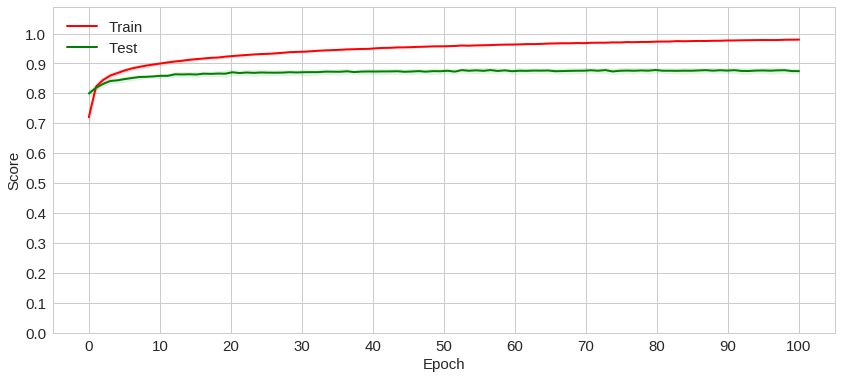

In [37]:
plot_mean_acc(tophistory)

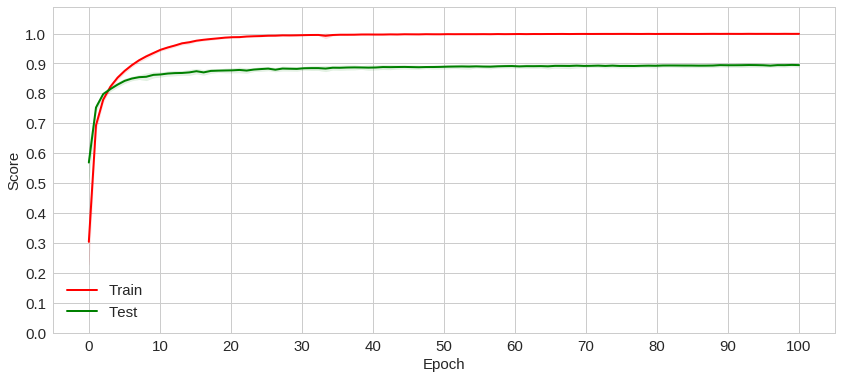

In [38]:
plot_mean_acc(history)

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

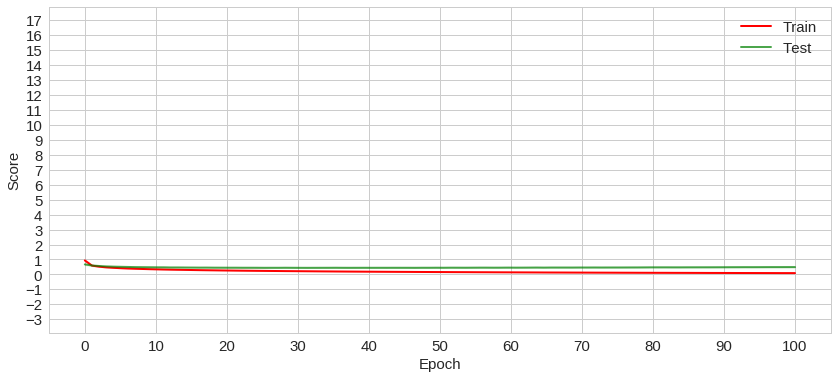

In [40]:
plot_mean_loss(tophistory)

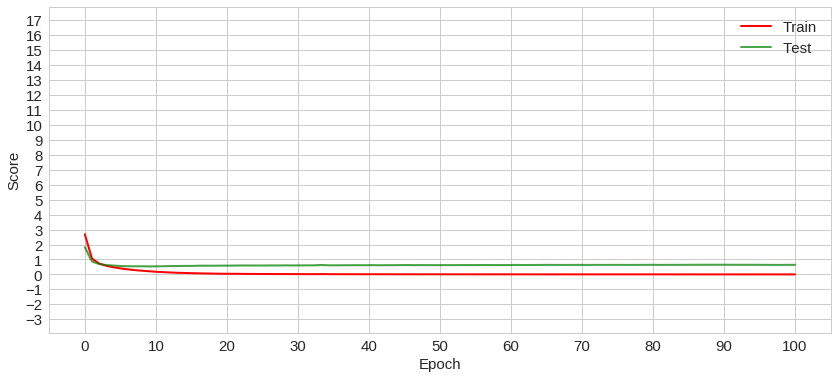

In [41]:
plot_mean_loss(history)